# **Objetivo**

El retraso de los vuelos de un aeropuerto es un problema tanto para los clientes como para los controladores aereos, que tienen que reprogramar los aterrizajes.

El objetivo de este notebook es desarrollar un modelo que permita predecir la probabilidad de que un vuelo se retrase más de 15 minutos, en el aeropuerto JFK de Nueva York.

Para ello se disponen de los datos de los diferentes vuelos que aterrizan en JFK (datos obtenidos del Departamento de transporte de Estados Unidos): https://drive.google.com/file/d/1RjKWadu92BBBBWSkU6xUkqR4oeTz7MJB/view?usp=drive_link

Descargamos los datos y los metemos en la carpeta 'data'.


In [1]:
# Genero las carpetas que se van a utilizar a lo largo del notebook
import os
for i in ['data', 'report', 'pickle', 'final']:
    try:
        os.mkdir(i)
    except FileExistsError:
        pass

In [2]:
from IPython.display import Image
Image(url='https://cdn.bitlysdowssl-aws.com/wp-content/uploads/2021/12/Aeropuerto-JFK.jpg')  

# **Documentación**

- Numpy --> https://numpy.org/doc/stable/reference/index.html
- Pandas --> https://pandas.pydata.org/pandas-docs/stable/reference/index.html
- Scikit-Learn --> https://scikit-learn.org/stable/
- Sklearn (Api Reference) --> https://scikit-learn.org/stable/modules/classes.html

# **Clases y funciones**

**DataFrameReporter**
Nos va a permitir hacer un primer contacto con el dataset.\
Se trata de una clase auxiliar que hará una parte del **EDA**.

In [3]:
class DataFrameReporter(object):
    '''
    Helper class that reports nulls and datatypes of columns
    '''
    def __init__(self, df): # Variables que le tengo que suministrar a la clase
        '''
        Constructor for the class.
        Needs dataframe
        '''
        self.df = df
               
    def analyze_X(self, X):
        '''
        Analyses the DataFrame you pass and returns a report of nulls, distribution and other goodies.
        '''        
               
        dtypes = X.dtypes.to_frame().rename(columns = {0:"Dtypes"}) # Tipos de variables

        nulls_in_X = X.isnull().sum().to_frame().rename(columns = {0:"Absolute_nulls"}) # Número de nulos en las variables
        nulls_in_X["Relative_nulls"] = nulls_in_X["Absolute_nulls"]/X.shape[0]
        nulls_in_X["Relative_nulls"] = nulls_in_X["Relative_nulls"].apply(
            lambda number: round(number, 3) * 100 # Relative_nulls = (Absolute_nulls/Shape)*100 ... con 3 cifras significativas
        )
        
        nulls_in_X = pd.concat([nulls_in_X, dtypes], axis = 1)
        nulls_in_X["Shape"] = X.shape[0] # Número de registros
        nulls_in_X = nulls_in_X[["Dtypes", "Shape", "Absolute_nulls", "Relative_nulls"]] # Ordeno las columnas

         
        describe_values_num = X.describe().T # Describe de las variables numéricas
        report_df = pd.concat([nulls_in_X, describe_values_num], axis = 1)
               
        describe_values_cat = X.describe(exclude = "number").T # Describe de las variables categóricas
        report_df = pd.concat([report_df, describe_values_cat], axis = 1)

        report_df.fillna("", inplace = True) # Imputo los nulos con un vacío
        report_df.sort_values("Dtypes", ascending = True, inplace = True) # Ordeno las variables por tipos
        
        return report_df
        
    def get_reports(self):
        '''
        Calls analyze_X method and returns report DataFrame for train and test.
        '''
        report_df = self.analyze_X(X = self.df)
                
        return report_df

In [4]:
# Elimina duplicados
def drop_duplicates (df):
    '''
    Elimina filas duplicadas del dataset
    '''
    print(f"{df.shape}")
    df_duplicated = df[df.duplicated(keep = False)]
    print(f"Se han eliminado {len(df[df.duplicated()])} registros repetidos")
    df.drop_duplicates(inplace = True)
    print(f"{df.shape}")

    return df_duplicated

In [5]:
# Nulos en variables
def nulos_variable (dataframe):
    ''' 
    Muestra los nulos que hay
    '''
    nulos_numericas = dataframe.select_dtypes(include = np.number).isnull().sum()[dataframe.select_dtypes(include = np.number).isnull().sum() > 0]
    nulos_categoricas =dataframe.select_dtypes(exclude = np.number).isnull().sum()[dataframe.select_dtypes(exclude = np.number).isnull().sum() > 0]

    print ('Las variables numéricas que tienen nulos son:\n', nulos_numericas, '\n\nHay un total de', len(nulos_numericas), 'variables numéricas con nulos')
    print ('\n\nLas variables categóricas que tienen nulos son:\n', nulos_categoricas, '\n\nHay un total de', len(nulos_categoricas), 'variables categóricas con nulos')
    print ('\n\nVARIABLES TOTALES CON NULOS:', len(nulos_numericas)+len(nulos_categoricas))

In [6]:
# Eliminación de variables numéricas con baja varianza
def varianza_nula (dataframe, std):
    ''' 
    Elimina variables numéricas con baja varianza    
    '''

    df_numerical_describe = dataframe.describe(include=np.number).T
    lista_numerica_baja_varianza = df_numerical_describe[(df_numerical_describe['std']<std)].index.tolist() # Indico la desviación típica (0.15)
    dataframe.drop(lista_numerica_baja_varianza, axis=1, inplace=True)
    print('Se han borrado las siguientes variables numéricas por tener baja varianza:\n',lista_numerica_baja_varianza )

    return dataframe.head()

In [7]:
# Separación de variables
#target = ['PRECIO'] # indico quién es la variable a predecir

def obtener_lista_variables(dataset):
  ''' 
  Obtengo listas de variables
  '''

  lista_numerica=[]
  lista_boolean=[] # numerica y con 2 valores
  lista_categorica=[] # object sin datatime

  for i in dataset: # si no especifico, aplica a las columnas (es como poner for i in dataset.columns:)
    if (dataset[i].dtype.kind == 'i'or dataset[i].dtype.kind == 'f' or dataset[i].dtype.kind == 'b') and len(dataset[i].unique())!=2\
     and i not in target:
      lista_numerica.append(i)
    elif (dataset[i].dtype.kind == 'i'or dataset[i].dtype.kind == 'f' or dataset[i].dtype.kind == 'b') and len(dataset[i].unique()) ==2\
     and i not in target:
      lista_boolean.append(i)
    elif (dataset[i].dtype.kind == 'O') and i not in target: # pongo elif y no else para que no me entre el datetime como categorica
      lista_categorica.append(i)


  return lista_numerica, lista_boolean, lista_categorica

In [8]:
# Análisis de las variables numéricas VS target
def analisis_numericas (dataframe, column, target):
    '''
    Pivot-table que me da las medidas de las variables numericas y su correlación con el target
    '''
    
    print(f"\nANÁLISIS DE {column} CON RESPECTO AL {target}\n")
    
    return dataframe.pivot_table(index=column, values=target, aggfunc=[len, min, np.mean, max]).sort_values(by=(column),ascending=True)

In [9]:
# Visualización de las variables numéricas VS target
def plot_numericas(dataframe,column,target):
    '''
    Visualización de las variables numéricas y su correlación con el target
    '''  
      
    plt.figure(figsize=[8,3])
    plt.title(f'Analisis de {column} VS {target}')
    sns.boxplot(x = target, y = column, data = dataframe, palette="coolwarm")    
  
    return plt.show()

In [10]:
# Análisis de las variables categóricas VS target
def analisis_categoricas (dataframe,column,target):
    '''
    Pivot-table que me da las medidas de las variables categóricas y su correlación con el target
    '''

    print(f"\nANÁLISIS DE {column} CON RESPECTO AL {target}\n")
    
    return dataframe.pivot_table(index=column, values=target, aggfunc=[len,sum,np.mean]).sort_values(by=('len', target),ascending=False)

In [11]:
# Visualización de las variables categóricas VS target
def plot_categoricas(dataframe,column,target):
    '''
    Visualización de las variables categóricas y su correlación con el target
    '''    
    if column == 'TAIL_NUM':
        pass
    else:
        plt.figure(figsize=[20,5])
        plt.title(f'Analisis de {column} VS {target}')
        plt.xticks(rotation = 90)   
        sns.countplot(data = dataframe, x = column, hue = target )  

    return plt.show()

# **1. IMPORTACIÓN DE LIBRERÍAS**

En primer lugar, debemos importar las 4 librerías básicas utilizadas en Machine Learning: 
1. **Numpy**: soporte para vectores y matrices (numpy Arrays), sobre el que se apoya pandas
2. **Pandas**: soporte para Series y DataFrames y funciones de análisis de datos
3. **Matplotlib**: librería de gráficos sobre la que se apoya Seaborn y las funciones de visualización de pandas
4. **Seaborn**: librería de *easy ploting*


In [12]:
import time

# sistema operativo
import os

# silence warnings
import warnings
warnings.filterwarnings("ignore")

# Descargas de archivos
#import wget

# Pandas y Numpy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# loading ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
#from matplotlib import pyplot as plt

%matplotlib inline

# visualiza gráficos de diagramas --> DecisionTree
import graphviz

# transformers
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn import __version__ as sklearn_version # versión de sklearn que tengo instalada

# scikits de modelización
from sklearn import model_selection # evaluación de modelos y estrategias de validación de modelos
from sklearn import metrics # métricas de validación de modelos
from sklearn.tree import DecisionTreeClassifier # algoritmo
from sklearn.tree import export_graphviz # exporta el diagrama de arbol en formato DOT (formato con texto plano que se usa para grafos)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # métodos de ensamble
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedKFold, KFold

# config
plt.style.use('ggplot')
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:,.2f}'.format

# Versiones de las librerías instaladas
print("Working with these versions of libraries\n")
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"Scikit-Learn version {sklearn_version}")

Working with these versions of libraries

Numpy version 1.21.5
Pandas version 1.4.4
Scikit-Learn version 1.3.0


# **2. IMPORTACIÓN DE DATOS**

In [13]:
#Si se usa Collab
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

In [14]:
# Asigno la ruta actual
os.chdir('D:\Data_Science\MACHINE_LEARNING\ML_SUPERVISADO\ML_SUPERVISADO_CLASIFICACION\Machine-Learning-Binary-Classifier-JFK-DELAY') 
# Veo la ruta actual
os.getcwd() 

'D:\\Data_Science\\MACHINE_LEARNING\\ML_SUPERVISADO\\ML_SUPERVISADO_CLASIFICACION\\Machine-Learning-Binary-Classifier-JFK-DELAY'

Introducimos los datos en un objeto de pandas, un dataframe, de esa forma podemos utilizar todos los métodos y funciones que tiene disponible el dataframe.

Cargamos los datos

In [15]:
%%time
# tiempo que tarda en cargar los datos 
jfk = pd.read_csv('data/JFK_Flights_Data.csv')
jfk.head()

Wall time: 4.09 s


,FL_DATE,OP_CARRIER_AIRLINE_ID,TAIL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,TAXI_OUT,CRS_ARR_TIME,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE
0,2018-02-01,"20,363.00",N299PQ,BNA,"Nashville, TN",Tennessee,JFK,"New York, NY",New York,1359,27.00,1719,0.00,140.00,765.00
1,2018-02-01,"20,363.00",N920XJ,RDU,"Raleigh/Durham, NC",North Carolina,JFK,"New York, NY",New York,1354,37.00,1541,0.00,107.00,427.00
2,2018-02-01,"20,363.00",N605LR,BUF,"Buffalo, NY",New York,JFK,"New York, NY",New York,1529,21.00,1709,0.00,100.00,301.00
3,2018-02-01,"20,363.00",N800AY,ORF,"Norfolk, VA",Virginia,JFK,"New York, NY",New York,1704,36.00,1845,0.00,101.00,290.00
4,2018-02-01,"20,363.00",N600LR,BOS,"Boston, MA",Massachusetts,JFK,"New York, NY",New York,1325,20.00,1454,0.00,89.00,187.00


Comprobamos que no haya ningún **registro duplicado**

In [16]:
drop_duplicates(df = jfk)

(250152, 15)
Se han eliminado 0 registros repetidos
(250152, 15)


,FL_DATE,OP_CARRIER_AIRLINE_ID,TAIL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,TAXI_OUT,CRS_ARR_TIME,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE


# **3. DATA UNDERSTANDING**  --> *EDA (Exploratory Data analysis)*

## **3.1. Análisis Univariante de Datos**

**A.- Data Size**

In [17]:
# Tamaño del dataset
jfk.size

3752280

In [18]:
# Número de filas y columnas
jfk.shape

(250152, 15)

In [19]:
# Información resumida del dataset
jfk.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250152 entries, 0 to 250151
Columns: 15 entries, FL_DATE to DISTANCE
dtypes: float64(5), int64(2), object(8)
memory usage: 30.5+ MB


**B.- Visualización directa de los datos**

In [20]:
# Columnas del dataset
jfk.columns

Index(['FL_DATE', 'OP_CARRIER_AIRLINE_ID', 'TAIL_NUM', 'ORIGIN',
       'ORIGIN_CITY_NAME', 'ORIGIN_STATE_NM', 'DEST', 'DEST_CITY_NAME',
       'DEST_STATE_NM', 'CRS_DEP_TIME', 'TAXI_OUT', 'CRS_ARR_TIME',
       'ARR_DEL15', 'CRS_ELAPSED_TIME', 'DISTANCE'],
      dtype='object')

In [21]:
# 5 primeros registros
jfk.head().T

,0,1,2,3,4
FL_DATE,2018-02-01,2018-02-01,2018-02-01,2018-02-01,2018-02-01
OP_CARRIER_AIRLINE_ID,"20,363.00","20,363.00","20,363.00","20,363.00","20,363.00"
TAIL_NUM,N299PQ,N920XJ,N605LR,N800AY,N600LR
ORIGIN,BNA,RDU,BUF,ORF,BOS
ORIGIN_CITY_NAME,"Nashville, TN","Raleigh/Durham, NC","Buffalo, NY","Norfolk, VA","Boston, MA"
ORIGIN_STATE_NM,Tennessee,North Carolina,New York,Virginia,Massachusetts
DEST,JFK,JFK,JFK,JFK,JFK
DEST_CITY_NAME,"New York, NY","New York, NY","New York, NY","New York, NY","New York, NY"
DEST_STATE_NM,New York,New York,New York,New York,New York
CRS_DEP_TIME,1359,1354,1529,1704,1325


In [22]:
# 5 registros aleatorios
jfk.sample(5).T

,182652,226923,54984,24157,245716
FL_DATE,2018-05-22,2018-08-27,2019-03-15,2018-12-15,2018-10-19
OP_CARRIER_AIRLINE_ID,"20,452.00","19,790.00","19,790.00","19,790.00","19,805.00"
TAIL_NUM,N401YX,N860DN,N327NW,NaN,N837NN
ORIGIN,DCA,SEA,PBI,MSY,SAN
ORIGIN_CITY_NAME,"Washington, DC","Seattle, WA","West Palm Beach/Palm Beach, FL","New Orleans, LA","San Diego, CA"
ORIGIN_STATE_NM,Virginia,Washington,Florida,Louisiana,California
DEST,JFK,JFK,JFK,JFK,JFK
DEST_CITY_NAME,"New York, NY","New York, NY","New York, NY","New York, NY","New York, NY"
DEST_STATE_NM,New York,New York,New York,New York,New York
CRS_DEP_TIME,1458,1525,1206,1300,746


In [23]:
# 5 últimos registros
jfk.tail().T

,250147,250148,250149,250150,250151
FL_DATE,2018-10-31,2018-10-31,2018-10-31,2018-10-31,2018-10-31
OP_CARRIER_AIRLINE_ID,"20,398.00","20,398.00","20,452.00","20,452.00","20,452.00"
TAIL_NUM,N801AE,N848AE,N870RW,N818MD,N878RW
ORIGIN,BOS,RDU,CMH,CMH,PIT
ORIGIN_CITY_NAME,"Boston, MA","Raleigh/Durham, NC","Columbus, OH","Columbus, OH","Pittsburgh, PA"
ORIGIN_STATE_NM,Massachusetts,North Carolina,Ohio,Ohio,Pennsylvania
DEST,JFK,JFK,JFK,JFK,JFK
DEST_CITY_NAME,"New York, NY","New York, NY","New York, NY","New York, NY","New York, NY"
DEST_STATE_NM,New York,New York,New York,New York,New York
CRS_DEP_TIME,1453,1944,1757,707,1033


***Información del dataset***

Cada fila nos da información de un vuelo determinado que aterriza en el aeropuerto JFK de Nueva York.\
Cada columna nos da la siguiente información:

* **FL_DATE**: flight date (fecha del vuelo)
* **OP_CARRIER_AIRLINE_ID**: Identificador de la compañía aérea que opera el vuelo (se debe tratar como un objeto y no como un número)
* **TAIL_NUM**: Tail Number. Conjunto de números y letras que componen el registro de matrícula de cada aeronave, situados en la cola del avión. Este número es único para cada aeronave y su formato depende del país de matriculación (p.ej. en el caso de EEUU está compuesto de la letra N más un conjunto de dígitos). Número de matrícula de cola del avión (es un identificador único).
* **ORIGIN**: Código del aeropuerto de origen del vuelo, expresado como una cadena de caracteres de tres letras. Código único para cada aeropuerto estandarizado por la Asociación Internacional de Transporte Aéreo (IATA)
* **ORIGIN_CITY_NAME**: nombre de la ciudad de origen
* **ORIGIN_STATE_NM**: nombre del estado de origen
* **DEST**: : Código del aeropuerto de destino del vuelo, expresado como una cadena de caracteres de tres letras. Código único para cada aeropuerto estandarizado por la Asociación Internacional de Transporte Aéreo (IATA).En nuestro caso se trata del JFK
* **DEST_CITY_NAME**: nombre de la ciudad de destino (New York, NY)
* **DEST_STATE_NM**: nombre del estado de destino (New York)
* **CRS_DEP_TIME**: Computerized Reservations Systems (CRS) departure time. Tiempo que cada aerolínea tiene computado como tiempo de salida. Puede definirse como la hora de salida que la compañía estima a la que va a salir cada vuelo. Dato muy útil para comprobar la diferencia entre la hora real de salida y la hora estimada por la compañía. Indicador de la “on-time performace” de cada aerolínea.
* **TAXI_OUT**: Taxi out time. Tiempo de rodadura desde la puerta hasta la pista en el aeropuerto de origen. Expresado como un conjunto de enteros en minutos. Dato útil para identificar retrasos en las fases y operativas de rodadura. Tiempo transcurrido entre la salida de la terminal y el despegue efectivo del avión.
* **CRS_ARR_TIME**: Computerized Reservations Systems (CRS) arrival time. Tiempo que cada aerolínea tiene computado como tiempo de llegada. Puede definirse como la hora de llegada que la compañía estima a la que va a llegar cada vuelo. Dato muy útil para comprobar la diferencia entre la 
hora real de llegada y la hora estimada por la compañía. Indicador de la “on-time performace” de cada aerolínea.
* **ARR_DEL15**: variable booleana (1/0) indicando si el vuelo ha llegado con más de 15 minutos de retraso. Va a ser nuestro target
* **CRS_ELAPSED_TIME**: : Computerized Reservations Systems (CRS) elapsed time. Tiempo que cada aerolínea tiene computado en su sistema como tiempo de vuelo, desde la salida en origen hasta la llegada en destino, expresado en minutos como un conjunto de enteros. Dato útil para la estimación e identificación de comportamientos o retrasos en ruta y la diferencia con el tiempo real de vuelo para el cálculo de la on-time performance. Tiempo previsto de vuelo.
* **DISTANCE**: distancia entre aeropuertos


**NOTA:** A la hora de elegir el target tenemos que tener en cuenta el tipo de modelo que es. Como se trata de un modelo de clasificación binaria, tomaremos como target la variable ARR_DEL15. Si es otro caso tomaríamos como target la variable ARR_DEL.

**C.- Tipo de atributos disponibles**

Vemos si los atributos de nuestro dataframe son numéricos o categóricos. Se clasifican, de menor a mayor espacio que ocupan, en:

Numeros (continuas)
*  Integer: numero sin decimales
*  Float: numero con decimales

Categoricas (discretas)
*   Boolean: Si/No, True/False o 1/0
*   Category: un numero finito de etiquetas (NO permite introducir nuevas etiquetas)
*   Object: un numero "infinito" de etiquetas (SI permite introducir nuevas etiquetas)
*   String: libertad maxima (hay que evitarlas ya que ocupan mucha memoria)

In [24]:
jfk.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250152 entries, 0 to 250151
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   FL_DATE                250152 non-null  object 
 1   OP_CARRIER_AIRLINE_ID  237644 non-null  float64
 2   TAIL_NUM               235143 non-null  object 
 3   ORIGIN                 250152 non-null  object 
 4   ORIGIN_CITY_NAME       250152 non-null  object 
 5   ORIGIN_STATE_NM        250152 non-null  object 
 6   DEST                   250152 non-null  object 
 7   DEST_CITY_NAME         250152 non-null  object 
 8   DEST_STATE_NM          250152 non-null  object 
 9   CRS_DEP_TIME           250152 non-null  int64  
 10  TAXI_OUT               232641 non-null  float64
 11  CRS_ARR_TIME           250152 non-null  int64  
 12  ARR_DEL15              250152 non-null  float64
 13  CRS_ELAPSED_TIME       250152 non-null  float64
 14  DISTANCE               250152 non-nu

**D.- Estadísticos descriptivos básicos y distribución de los nulos**

**Estadísticos descriptivos**

Mediante el método **describe()**, podemos obtener los estadísticos representativos de cada uno de los atributos del DataFrame.

In [25]:
# Atributos numéricos
jfk.describe(include = 'number').T

,count,mean,std,min,25%,50%,75%,max
OP_CARRIER_AIRLINE_ID,"237,644.00","20,152.00",297.88,"19,690.00","19,790.00","20,363.00","20,409.00","21,171.00"
CRS_DEP_TIME,"250,152.00","1,334.61",529.10,3.00,915.00,"1,258.00","1,744.00","2,359.00"
TAXI_OUT,"232,641.00",18.19,9.61,1.00,12.00,16.00,21.00,166.00
CRS_ARR_TIME,"250,152.00","1,419.13",580.99,1.00,944.00,"1,455.00","1,914.00","2,400.00"
ARR_DEL15,"250,152.00",0.21,0.41,0.00,0.00,0.00,0.00,1.00
CRS_ELAPSED_TIME,"250,152.00",195.65,97.37,47.00,109.00,167.00,306.00,595.00
DISTANCE,"250,152.00","1,258.84",898.12,94.00,427.00,"1,028.00","2,248.00","4,983.00"


In [26]:
# Atributos categóricos
jfk.describe(include=['object']).T

,count,unique,top,freq
FL_DATE,250152,730,2018-07-19,394
TAIL_NUM,235143,2645,N110AN,761
ORIGIN,250152,72,LAX,25345
ORIGIN_CITY_NAME,250152,70,"Los Angeles, CA",25345
ORIGIN_STATE_NM,250152,32,California,51137
DEST,250152,1,JFK,250152
DEST_CITY_NAME,250152,1,"New York, NY",250152
DEST_STATE_NM,250152,1,New York,250152


In [27]:
# Otra manera de mostrar las variables categóricas
jfk.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
FL_DATE,250152,730,2018-07-19,394
TAIL_NUM,235143,2645,N110AN,761
ORIGIN,250152,72,LAX,25345
ORIGIN_CITY_NAME,250152,70,"Los Angeles, CA",25345
ORIGIN_STATE_NM,250152,32,California,51137
DEST,250152,1,JFK,250152
DEST_CITY_NAME,250152,1,"New York, NY",250152
DEST_STATE_NM,250152,1,New York,250152


In [28]:
# Otra manera más de mostrar las variables categóricas
jfk.describe(exclude='number').T # excluye integer y float

,count,unique,top,freq
FL_DATE,250152,730,2018-07-19,394
TAIL_NUM,235143,2645,N110AN,761
ORIGIN,250152,72,LAX,25345
ORIGIN_CITY_NAME,250152,70,"Los Angeles, CA",25345
ORIGIN_STATE_NM,250152,32,California,51137
DEST,250152,1,JFK,250152
DEST_CITY_NAME,250152,1,"New York, NY",250152
DEST_STATE_NM,250152,1,New York,250152


In [29]:
# Todas las variables juntas
jfk.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
FL_DATE,250152,730,2018-07-19,394,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OP_CARRIER_AIRLINE_ID,"237,644.00",NaN,NaN,NaN,"20,152.00",297.88,"19,690.00","19,790.00","20,363.00","20,409.00","21,171.00"
TAIL_NUM,235143,2645,N110AN,761,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ORIGIN,250152,72,LAX,25345,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ORIGIN_CITY_NAME,250152,70,"Los Angeles, CA",25345,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ORIGIN_STATE_NM,250152,32,California,51137,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEST,250152,1,JFK,250152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEST_CITY_NAME,250152,1,"New York, NY",250152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEST_STATE_NM,250152,1,New York,250152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CRS_DEP_TIME,"250,152.00",NaN,NaN,NaN,"1,334.61",529.10,3.00,915.00,"1,258.00","1,744.00","2,359.00"


Podemos usar la clase DataFrameReporter que nos permite mostrar un descritivo de todos los atributos juntos, así como los nulos que tienen

In [30]:
report_jfk = DataFrameReporter(df = jfk).get_reports()
report_jfk

,Dtypes,Shape,Absolute_nulls,Relative_nulls,count,mean,std,min,25%,50%,75%,max,count,unique,top,freq
CRS_DEP_TIME,int64,250152,0,0.00,"250,152.00","1,334.61",529.10,3.00,915.00,"1,258.00","1,744.00","2,359.00",,,,
CRS_ARR_TIME,int64,250152,0,0.00,"250,152.00","1,419.13",580.99,1.00,944.00,"1,455.00","1,914.00","2,400.00",,,,
OP_CARRIER_AIRLINE_ID,float64,250152,12508,5.00,"237,644.00","20,152.00",297.88,"19,690.00","19,790.00","20,363.00","20,409.00","21,171.00",,,,
TAXI_OUT,float64,250152,17511,7.00,"232,641.00",18.19,9.61,1.00,12.00,16.00,21.00,166.00,,,,
ARR_DEL15,float64,250152,0,0.00,"250,152.00",0.21,0.41,0.00,0.00,0.00,0.00,1.00,,,,
CRS_ELAPSED_TIME,float64,250152,0,0.00,"250,152.00",195.65,97.37,47.00,109.00,167.00,306.00,595.00,,,,
DISTANCE,float64,250152,0,0.00,"250,152.00","1,258.84",898.12,94.00,427.00,"1,028.00","2,248.00","4,983.00",,,,
FL_DATE,object,250152,0,0.00,,,,,,,,,250152,730,2018-07-19,394
TAIL_NUM,object,250152,15009,6.00,,,,,,,,,235143,2645,N110AN,761
ORIGIN,object,250152,0,0.00,,,,,,,,,250152,72,LAX,25345


*Variables de baja varianza*

Son variables que van a ser irrelevantes para el modelo (no le van a aportar información relevante).

Se eliminan aquellas **variables numéricas** cuya varianza sea inferior a 0.15

In [31]:
varianza_nula (dataframe = jfk, std = 0.15)

Se han borrado las siguientes variables numéricas por tener baja varianza:
 []


,FL_DATE,OP_CARRIER_AIRLINE_ID,TAIL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,TAXI_OUT,CRS_ARR_TIME,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE
0,2018-02-01,"20,363.00",N299PQ,BNA,"Nashville, TN",Tennessee,JFK,"New York, NY",New York,1359,27.00,1719,0.00,140.00,765.00
1,2018-02-01,"20,363.00",N920XJ,RDU,"Raleigh/Durham, NC",North Carolina,JFK,"New York, NY",New York,1354,37.00,1541,0.00,107.00,427.00
2,2018-02-01,"20,363.00",N605LR,BUF,"Buffalo, NY",New York,JFK,"New York, NY",New York,1529,21.00,1709,0.00,100.00,301.00
3,2018-02-01,"20,363.00",N800AY,ORF,"Norfolk, VA",Virginia,JFK,"New York, NY",New York,1704,36.00,1845,0.00,101.00,290.00
4,2018-02-01,"20,363.00",N600LR,BOS,"Boston, MA",Massachusetts,JFK,"New York, NY",New York,1325,20.00,1454,0.00,89.00,187.00


En este dataset, encontramos tres **variables categóricas sin varianza**: DEST, DEST_CITY_NAME y DEST_STATE_NM, ya que todos los registros de vuelo tienen como destino el aeropuerto JFK de Nueva York (unique = 1). Es por ello que la información que le aportan estos atributos al modelo es irrelevante. **Las eliminamos**.

In [32]:
# Elimino variables categoricas sin varianza
jfk.drop(['DEST', 'DEST_CITY_NAME', 'DEST_STATE_NM'], axis = 1, inplace = True)

**Distribución de los nulos**

Trataremos por separado los atributos numéricos y categóricos para mantener una visión clara. 

Seleccionamos las variables utilizando el método selec_types() y a continuación invocamos el método de Pandas isnull().

In [33]:
# Atributos numéricos
jfk.select_dtypes(include=['number']).isnull().sum()

OP_CARRIER_AIRLINE_ID    12508
CRS_DEP_TIME                 0
TAXI_OUT                 17511
CRS_ARR_TIME                 0
ARR_DEL15                    0
CRS_ELAPSED_TIME             0
DISTANCE                     0
dtype: int64

In [34]:
jfk.select_dtypes(include=['object']).isnull().sum()

FL_DATE                 0
TAIL_NUM            15009
ORIGIN                  0
ORIGIN_CITY_NAME        0
ORIGIN_STATE_NM         0
dtype: int64

In [35]:
# Todos los atributos juntos
jfk.isnull().sum()

FL_DATE                      0
OP_CARRIER_AIRLINE_ID    12508
TAIL_NUM                 15009
ORIGIN                       0
ORIGIN_CITY_NAME             0
ORIGIN_STATE_NM              0
CRS_DEP_TIME                 0
TAXI_OUT                 17511
CRS_ARR_TIME                 0
ARR_DEL15                    0
CRS_ELAPSED_TIME             0
DISTANCE                     0
dtype: int64

Tambien podemos usar la función nulos_variable()

In [36]:
nulos_variable (dataframe = jfk)

Las variables numéricas que tienen nulos son:
 OP_CARRIER_AIRLINE_ID    12508
TAXI_OUT                 17511
dtype: int64 

Hay un total de 2 variables numéricas con nulos


Las variables categóricas que tienen nulos son:
 TAIL_NUM    15009
dtype: int64 

Hay un total de 1 variables categóricas con nulos


VARIABLES TOTALES CON NULOS: 3


**Análisis rápido de los atributos**

*Análisis de las variables numéricas*:
- Hay nulos en las variables OP_CARRIER_AIRLINE_ID Y TAXI_OUT
- La información aportada por la variable OP_CARRIER_AIRLINE_ID es irrelevante, ya que aunque nos diga que es un float, es como un objeto identificativo único.

*Análisis de las variables categóricas*:
- Hay nulos en TAIL_NUM
- El 2018-07-19 es el día con más vuelos, con 394.

*Análisis del target* (ARR_DEL15):
- Todas las filas son relevantes ya que no tiene nulos.
- Si hubieses nulos, se eliminan (no podríamos hacer un fillna ya que estaríamos generando ruido al modelo. Si rellenamos un atributo, el ruido es menor ya que hay más atributos).
- La media del target es de 0.21. esto significa que ***el 21% de los vuelos del dataset se retrasan más de 15 minutos***.


In [37]:
# Lo exporto a csv para poder trabajar con el
report_jfk.to_csv('report/jfk_describe.csv')

**E.- Distribución de los atributos**

***Análisis de FL_DATE***

Vemos que se trata de un object. Dos formas de verlo:

In [38]:
jfk['FL_DATE'].dtypes

dtype('O')

In [39]:
jfk[['FL_DATE']].dtypes

FL_DATE    object
dtype: object

Lo convertimos a formato fecha, aplicando la función Datetime de Pandas

In [40]:
jfk['FL_DATE'] = pd.to_datetime(jfk['FL_DATE'])

Separamos las variables numéricas, booleanas y categóricas, así como el target

In [41]:
# Indico cual es la variable a predecir
target = 'ARR_DEL15'

In [42]:
# Guardo las variables en su lista correspondiente
list_num, list_bool, list_cat = obtener_lista_variables(dataset = jfk)

In [43]:
# Variables numéricas
list_num

['OP_CARRIER_AIRLINE_ID',
 'CRS_DEP_TIME',
 'TAXI_OUT',
 'CRS_ARR_TIME',
 'CRS_ELAPSED_TIME',
 'DISTANCE']

In [44]:
# Variable booleanas
list_bool

[]

In [45]:
# Variable categóricas
list_cat

['TAIL_NUM', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_NM']

***Análisis del Target o Clase***

En un problema de clasificación supervisada, es importante conocer la distribución del target.\
Se trata de un target categórico por lo que debemos saber cuantas categorías tiene y el número de registros que hay en cada una de ellas.

In [46]:
# Usamos el método value_counts() de Series Pandas
jfk[target].value_counts(dropna = False) # Con False muestra también los nulos

0.00    197520
1.00     52632
Name: ARR_DEL15, dtype: int64

Asimismo, podemos utilizar Seaborn para obtener una visualización sencilla. 

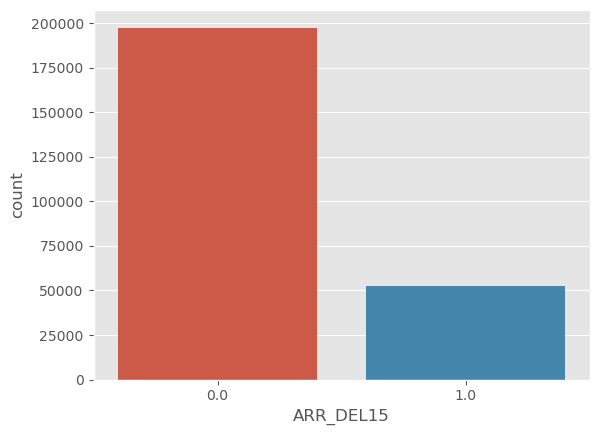

In [47]:
# Visualización del target
sns.countplot(data = jfk, x = target);

Vemos que el target contiene 2 valores: 
- ARR_DEL15 = 1 --> Delay = True (positivo)
- ARR_DEL15 = 0 --> Delay = False (negativo)

***Nota***: En caso de tener valores True/False, SI/NO, YES/NO, los convertimos a 1/0:
- True --> 1
- False --> 0

In [48]:
# Ejemplo de cómo convertirlos los string YES/NO en booleanos 1/0
#df['ARR_DEL15'] = (df['ARR_DEL15'] == 'Yes').astype(int)

A través de la clase **DataFrameReporter** habíamos visto una serie de descriptivos. Para el target:
- Count --> 250152
- Min --> 0
- Mean --> 0.21
- Max --> 1

Todos estos valores también se pueden obtener de forma independiente, aplicando unas funciones sobre la **Serie del target**:

In [49]:
# Número de registros de la Serie
jfk[target].count()

250152

In [50]:
# Valor mínimo de la Serie
jfk[target].min()

0.0

In [51]:
# Valor medio de la Serie
jfk[target].mean()

0.21040007675333397

Me está diciendo que **el 21% de los vuelos se retrasan más de 15 minutos** (*ratio de prevalencia de la clase positiva*). O lo que es lo mismo, **el 79% de los vuelos no se retrasan más de 15 minutos**.

In [52]:
# Valor máximo de la Serie
jfk[target].max()

1.0

In [53]:
# Número de vuelos que se retrasan más de 15 minutos
jfk[target].sum()

52632.0

***Análisis de las variables numéricas***

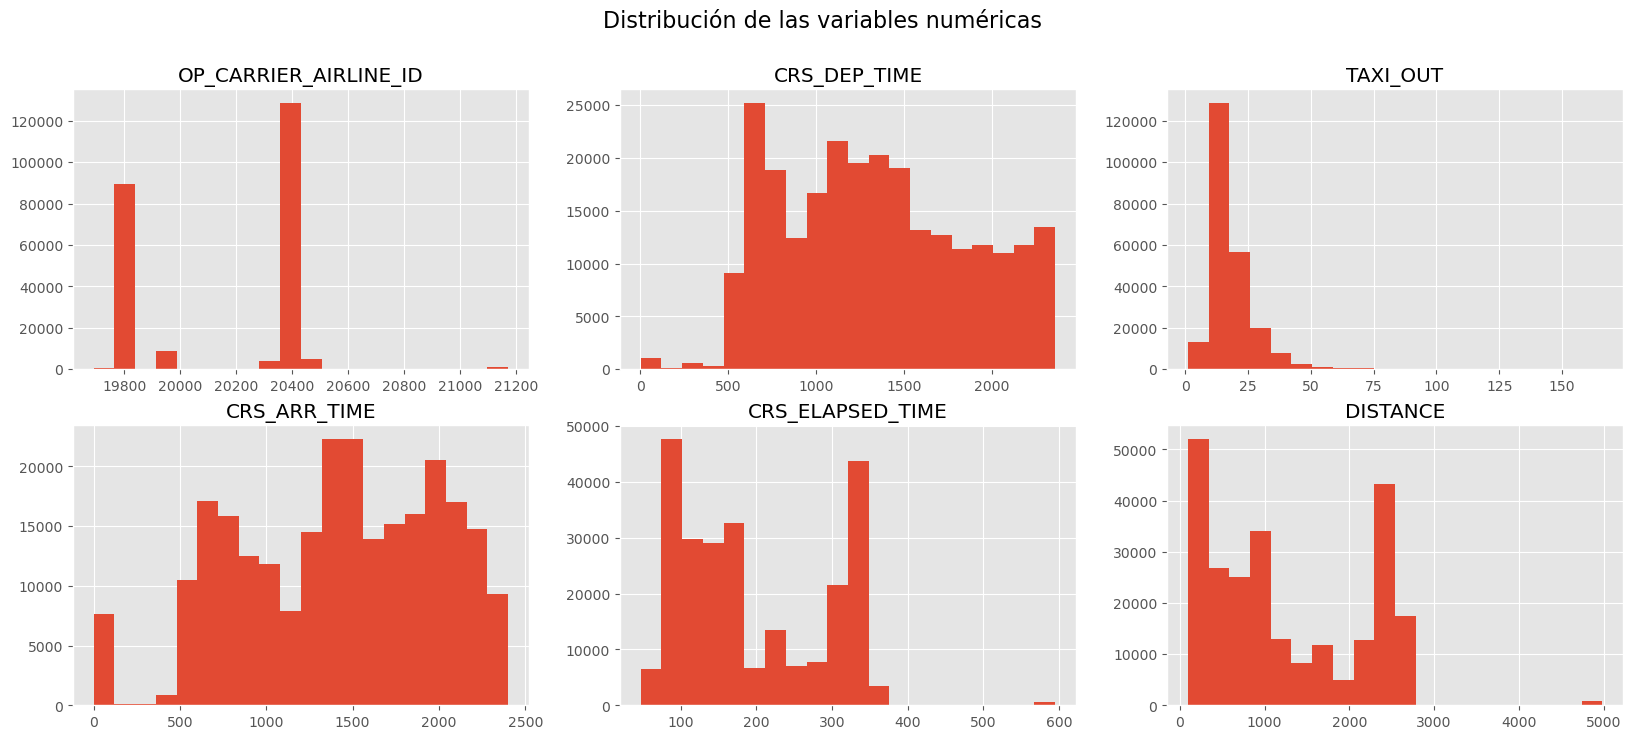

In [54]:
# instanciate the figure
fig = plt.figure(figsize = (20, 8))
for n, num in enumerate (list_num): # for loop aplicado a todas las variables numéricas
    fig.add_subplot(2, 3, n+1) # Método para indicar el número de gráficos por filas y columnas
    jfk[num].hist(bins=20) # Represento con un histograma cada atributo
    plt.title(num) # Método para darle un título a la figura

# create a title for the figure
fig.suptitle ('Distribución de las variables numéricas', fontsize = 16);

*Correlación entre variables numéricas*

In [55]:
corr = jfk.corr()
corr.style.background_gradient(cmap="coolwarm") # parámetros de configuración de la tabla de correlación

,OP_CARRIER_AIRLINE_ID,CRS_DEP_TIME,TAXI_OUT,CRS_ARR_TIME,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE
OP_CARRIER_AIRLINE_ID,1.000000,-0.028113,-0.029900,-0.070828,0.043606,-0.404431,-0.388482
CRS_DEP_TIME,-0.028113,1.000000,0.005575,0.111409,0.121370,0.159306,0.158418
TAXI_OUT,-0.029900,0.005575,1.000000,0.088735,0.280887,-0.020412,-0.039050
CRS_ARR_TIME,-0.070828,0.111409,0.088735,1.000000,0.118796,-0.034389,-0.064273
ARR_DEL15,0.043606,0.121370,0.280887,0.118796,1.000000,-0.004796,-0.008876
CRS_ELAPSED_TIME,-0.404431,0.159306,-0.020412,-0.034389,-0.004796,1.000000,0.995510
DISTANCE,-0.388482,0.158418,-0.039050,-0.064273,-0.008876,0.995510,1.000000


Existe una correlación muy fuerte entre la distancia y la duración del vuelo. Eliminamos una de ellas.

In [56]:
# Elimino la variable
del jfk['DISTANCE']

**Análisis de las variables categóricas**

In [57]:
for i in list_cat: # for loop aplicado a todas las variables categóricas
  print(jfk[i].value_counts(),'\n')

N110AN    761
N113AN    751
N111ZM    748
N115NN    740
N109NN    740
         ... 
N197UW      1
N986AN      1
N315RJ      1
N801AW      1
N945DN      1
Name: TAIL_NUM, Length: 2645, dtype: int64 

LAX    25345
SFO    15228
BOS    11201
MCO     9450
CLT     7769
FLL     7645
LAS     7377
MIA     7071
BUF     7049
ATL     6687
RDU     6665
SEA     6491
SJU     5712
ORD     5647
PHX     5460
TPA     5240
DCA     4930
SLC     4329
SAN     4317
AUS     4257
ROC     4181
JAX     4143
MSY     3707
PBI     3688
CLE     3681
BTV     3674
SYR     3479
CHS     3338
IAD     3267
DFW     3231
BWI     3179
PWM     3155
ORF     3102
BNA     3004
DTW     2911
DEN     2911
SAV     2847
MSP     2806
PIT     2686
CMH     2575
PDX     2528
RSW     2122
IND     2086
RIC     1951
SJC     1699
CVG     1395
LGB     1375
BUR      996
SAT      994
ACK      919
BQN      858
PHL      851
SRQ      764
HNL      754
SMF      684
PSE      653
HOU      648
ABQ      602
ORH      577
OAK      555
RNO      525
STT     

## **3.2. Distribución de atributos y correlación con el target**

**A.- FL_DATE**

En el análisis anterior vimos que la mayoría de los vuelos proceden de Los Angeles. *Veamos cuántos vuelos procedentes de Los Ángeles se retrasan cada día*.

In [58]:
# Vuelos procedentes de Los Ángeles
lax_jfk = jfk[jfk['ORIGIN']=='LAX'] # boolean indexing
lax_jfk.head()

,FL_DATE,OP_CARRIER_AIRLINE_ID,TAIL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,CRS_DEP_TIME,TAXI_OUT,CRS_ARR_TIME,ARR_DEL15,CRS_ELAPSED_TIME
34,2018-02-01,"19,805.00",N104NN,LAX,"Los Angeles, CA",California,1530,40.00,2359,1.00,329.00
35,2018-02-01,"19,805.00",N117AN,LAX,"Los Angeles, CA",California,1045,24.00,1919,0.00,334.00
36,2018-02-01,"19,805.00",N111ZM,LAX,"Los Angeles, CA",California,1630,36.00,59,0.00,329.00
39,2018-02-01,"19,805.00",N101NN,LAX,"Los Angeles, CA",California,1245,17.00,2123,0.00,338.00
100,2018-02-01,"19,790.00",NaN,LAX,"Los Angeles, CA",California,1130,27.00,2000,0.00,330.00


In [59]:
# Agrupamos por días (convirtiéndose FT_DATE en el índice)
lax_jfk_dia = lax_jfk[['FL_DATE', target]].groupby('FL_DATE').agg([len, sum, np.mean]) # número de vuelos, vuelos con retraso, media de los vuelos con retraso
lax_jfk_dia.head()

ARR_DEL15           
                 len   sum mean
FL_DATE                        
2018-01-01        31 10.00 0.32
2018-01-02        35 13.00 0.37
2018-01-03        28  3.00 0.11
2018-01-04         2  1.00 0.50
2018-01-05        29 21.00 0.72

Por ejemplo, el 5 de enero del 2018, aterrizaron 29 vuelos procedentes de Los Ángeles, de los cuales 21 llegaron con retraso. Es decir, un 72% de los vuelos procedentes de Los Ángeles de ese día, llegaron con retraso.

Otra forma de colocar FL_DATE como índice:

In [60]:
lax_jfk.set_index('FL_DATE').head() # para que se guarden los cambios hay que aplicar inplace = True

,OP_CARRIER_AIRLINE_ID,TAIL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,CRS_DEP_TIME,TAXI_OUT,CRS_ARR_TIME,ARR_DEL15,CRS_ELAPSED_TIME
FL_DATE,,,,,,,,,,
2018-02-01,"19,805.00",N104NN,LAX,"Los Angeles, CA",California,1530,40.00,2359,1.00,329.00
2018-02-01,"19,805.00",N117AN,LAX,"Los Angeles, CA",California,1045,24.00,1919,0.00,334.00
2018-02-01,"19,805.00",N111ZM,LAX,"Los Angeles, CA",California,1630,36.00,59,0.00,329.00
2018-02-01,"19,805.00",N101NN,LAX,"Los Angeles, CA",California,1245,17.00,2123,0.00,338.00
2018-02-01,"19,790.00",NaN,LAX,"Los Angeles, CA",California,1130,27.00,2000,0.00,330.00


Visualizamos en un gráfico los retrasos. Para ello, ***la fecha tiene que estar en el índice***

In [61]:
pd.DataFrame.plot?

Init signature: pd.DataFrame.plot(data)
Docstring:     
Make plots of Series or DataFrame.

Uses the backend specified by the
option ``plotting.backend``. By default, matplotlib is used.

Parameters
----------
data : Series or DataFrame
    The object for which the method is called.
x : label or position, default None
    Only used if data is a DataFrame.
y : label, position or list of label, positions, default None
    Allows plotting of one column versus another. Only used if data is a
    DataFrame.
kind : str
    The kind of plot to produce:

    - 'line' : line plot (default)
    - 'bar' : vertical bar plot
    - 'barh' : horizontal bar plot
    - 'hist' : histogram
    - 'box' : boxplot
    - 'kde' : Kernel Density Estimation plot
    - 'density' : same as 'kde'
    - 'area' : area plot
    - 'pie' : pie plot
    - 'scatter' : scatter plot (DataFrame only)
    - 'hexbin' : hexbin plot (DataFrame only)
ax : matplotlib axes object, default None
    An axes of the current figure.
su

*Retrasos diarios*

In [62]:
lax_jfk_daily = lax_jfk_dia[target, 'mean']
lax_jfk_daily.head()

FL_DATE
2018-01-01   0.32
2018-01-02   0.37
2018-01-03   0.11
2018-01-04   0.50
2018-01-05   0.72
Name: (ARR_DEL15, mean), dtype: float64

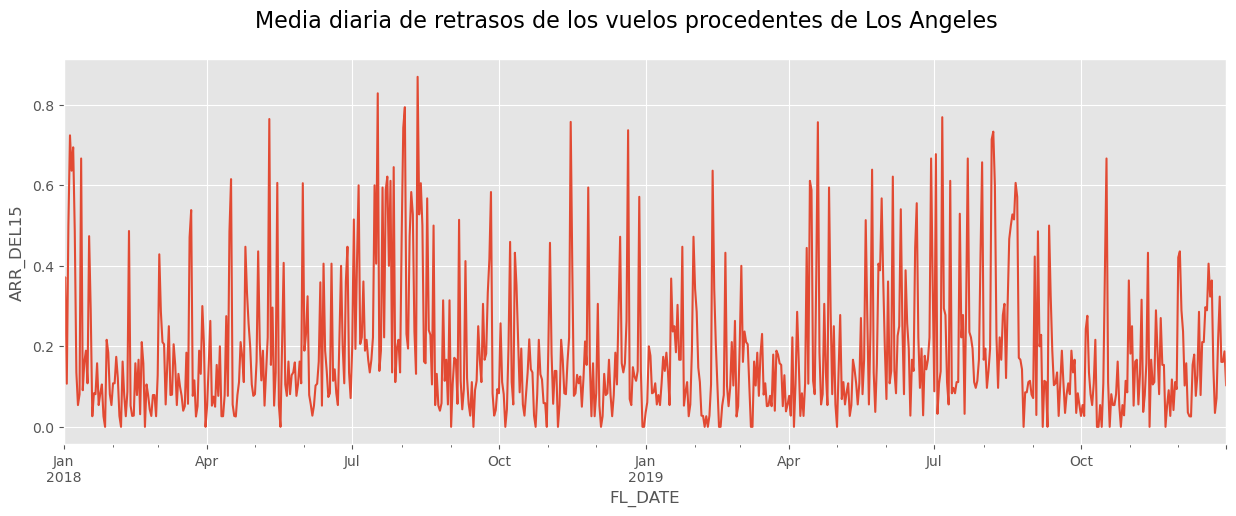

In [63]:
# Representamos el target diario
fig = plt.figure(figsize=[15,5])
lax_jfk_daily.plot(kind = 'line', ylabel = target) # En el eje x automáticamente se coloca el índice (FL_DATE)
fig.suptitle ('Media diaria de retrasos de los vuelos procedentes de Los Angeles', fontsize = 16);

*Retrasos semanales*

Si queremos la **media semanal del target** podemos utilizar la función **resample()**.

In [64]:
# Agrupamos por semanas (convirtiéndose FT_DATE en el índice), aplicando la media para cada una de las semanas
lax_jfk_weekly = lax_jfk_daily.resample('W').mean()
lax_jfk_weekly.head()

FL_DATE
2018-01-07   0.48
2018-01-14   0.24
2018-01-21   0.18
2018-01-28   0.09
2018-02-04   0.12
Freq: W-SUN, Name: (ARR_DEL15, mean), dtype: float64

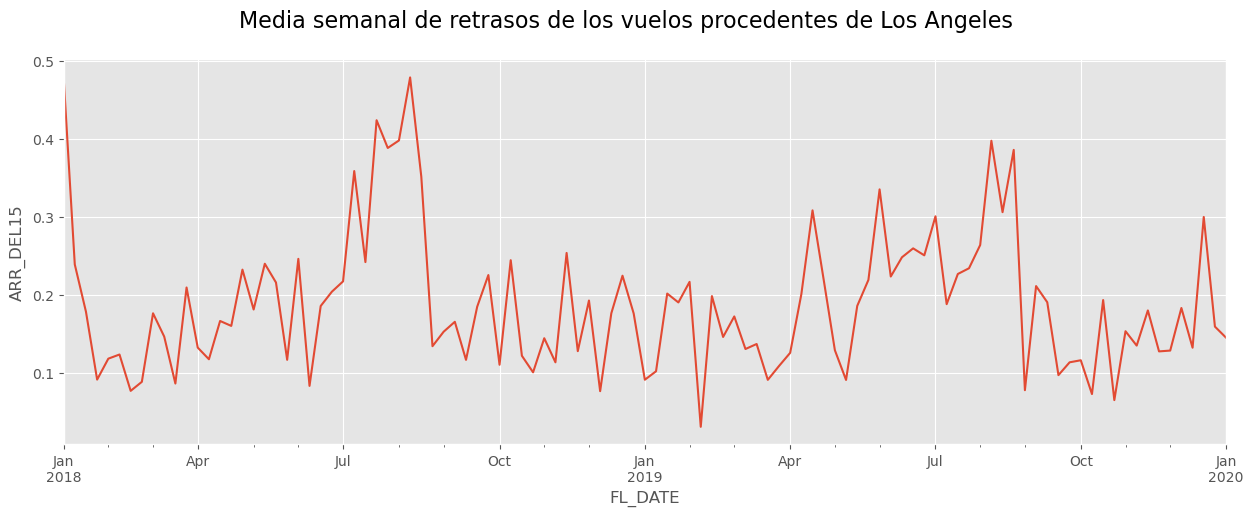

In [65]:
# Representamos el target semanal
fig = plt.figure(figsize = [15,5])
lax_jfk_weekly.plot(kind = 'line', ylabel = target)
fig.suptitle ('Media semanal de retrasos de los vuelos procedentes de Los Angeles', fontsize = 16 );

*Retrasos mensuales*

Si queremos la **media mensual del target**, utilizando la función **resample()**:

In [66]:
lax_jfk_monthly = lax_jfk_daily.resample('M').mean()
lax_jfk_monthly.head()

FL_DATE
2018-01-31   0.23
2018-02-28   0.10
2018-03-31   0.16
2018-04-30   0.16
2018-05-31   0.20
Freq: M, Name: (ARR_DEL15, mean), dtype: float64

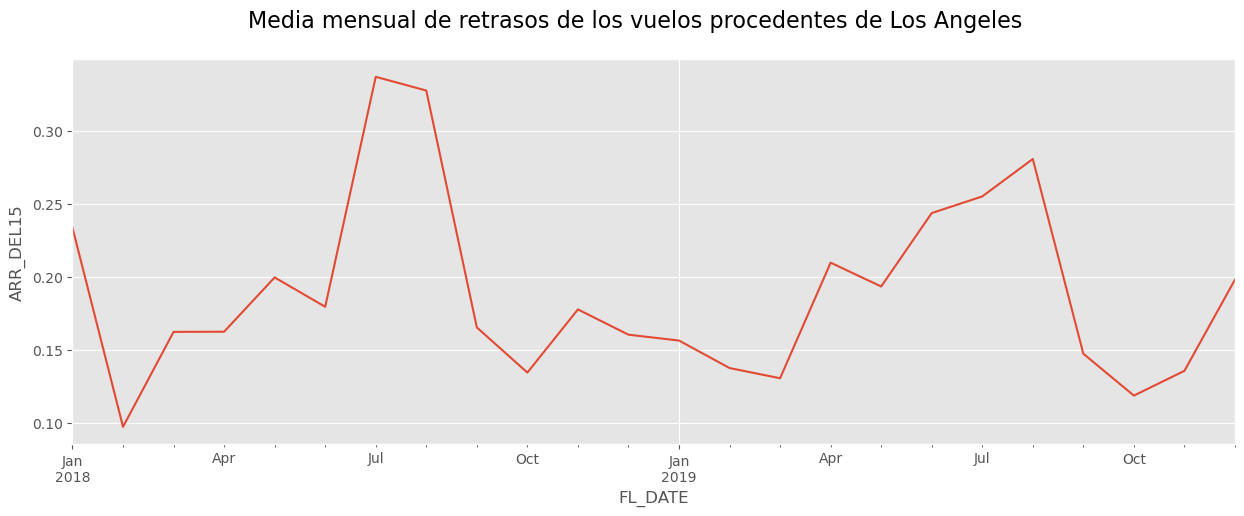

In [67]:
fig = plt.figure(figsize = [15,5])
lax_jfk_monthly.plot(kind = 'line', ylabel = target)
fig.suptitle('Media mensual de retrasos de los vuelos procedentes de Los Angeles', fontsize = 16 );

Vemos en los gráficos que hay ciertos patrones que se repiten según la estación del año. **Hay cierta estacionalidad** (En Verano se producen los mayores retrasos y en invierno los menores retrasos).

In [68]:
# Actualizamos las listas de variables
list_num, list_bool, list_cat = obtener_lista_variables(dataset = jfk)

**B.- VARIABLES NUMÉRICAS**

In [69]:
list_num

['OP_CARRIER_AIRLINE_ID',
 'CRS_DEP_TIME',
 'TAXI_OUT',
 'CRS_ARR_TIME',
 'CRS_ELAPSED_TIME']

Usamos un pivot_table para analizar las variables con respecto al target y las representamos mediante un boxplot.

In [70]:
analisis_numericas??

Signature: analisis_numericas(dataframe, column, target)
Source:   
def analisis_numericas (dataframe, column, target):
    '''
    Pivot-table que me da las medidas de las variables numericas y su correlación con el target
    '''
    
    print(f"\nANÁLISIS DE {column} CON RESPECTO AL {target}\n")
    
    return dataframe.pivot_table(index=column, values=target, aggfunc=[len, min, np.mean, max]).sort_values(by=(column),ascending=True)
File:      c:\users\jagui\appdata\local\temp\ipykernel_11692\2226796377.py
Type:      function


In [71]:
plot_numericas??

Signature: plot_numericas(dataframe, column, target)
Source:   
def plot_numericas(dataframe,column,target):
    '''
    Visualización de las variables numéricas y su correlación con el target
    '''  
      
    plt.figure(figsize=[8,3])
    plt.title(f'Analisis de {column} VS {target}')
    sns.boxplot(x = target, y = column, data = dataframe, palette="coolwarm")    
  
    return plt.show()
File:      c:\users\jagui\appdata\local\temp\ipykernel_11692\3268369109.py
Type:      function



ANÁLISIS DE OP_CARRIER_AIRLINE_ID CON RESPECTO AL ARR_DEL15

                            len       min      mean       max
                      ARR_DEL15 ARR_DEL15 ARR_DEL15 ARR_DEL15
OP_CARRIER_AIRLINE_ID                                        
19,690.00                   695      0.00      0.29      1.00
19,790.00                 58894      0.00      0.17      1.00
19,805.00                 30694      0.00      0.20      1.00
19,930.00                  8591      0.00      0.23      1.00
20,304.00                  3993      0.00      0.25      1.00
20,363.00                 40833      0.00      0.19      1.00
20,397.00                   555      0.00      0.22      1.00
20,398.00                  8814      0.00      0.23      1.00
20,409.00                 78587      0.00      0.25      1.00
20,452.00                  5044      0.00      0.17      1.00
21,171.00                   944      0.00      0.15      1.00


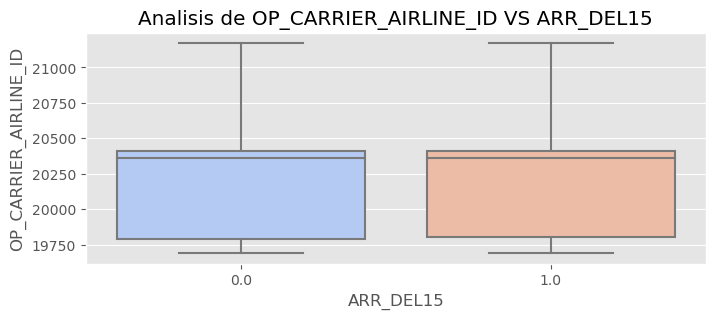


ANÁLISIS DE CRS_DEP_TIME CON RESPECTO AL ARR_DEL15

                   len       min      mean       max
             ARR_DEL15 ARR_DEL15 ARR_DEL15 ARR_DEL15
CRS_DEP_TIME                                        
3                    1      0.00      0.00      0.00
4                   53      0.00      0.25      1.00
5                    1      0.00      0.00      0.00
9                    1      0.00      0.00      0.00
10                   1      0.00      0.00      0.00
...                ...       ...       ...       ...
2355               536      0.00      0.26      1.00
2356               181      0.00      0.29      1.00
2357               142      0.00      0.16      1.00
2358               280      0.00      0.17      1.00
2359              2953      0.00      0.24      1.00

[1200 rows x 4 columns]


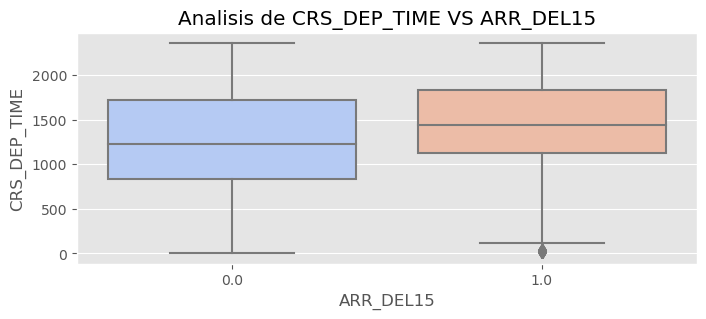


ANÁLISIS DE TAXI_OUT CON RESPECTO AL ARR_DEL15

               len       min      mean       max
         ARR_DEL15 ARR_DEL15 ARR_DEL15 ARR_DEL15
TAXI_OUT                                        
1.00             1      0.00      0.00      0.00
2.00             5      0.00      0.80      1.00
3.00            11      0.00      0.18      1.00
4.00            12      0.00      0.08      1.00
5.00            42      0.00      0.19      1.00
...            ...       ...       ...       ...
156.00           1      1.00      1.00      1.00
159.00           1      1.00      1.00      1.00
161.00           1      1.00      1.00      1.00
162.00           2      1.00      1.00      1.00
166.00           1      1.00      1.00      1.00

[154 rows x 4 columns]


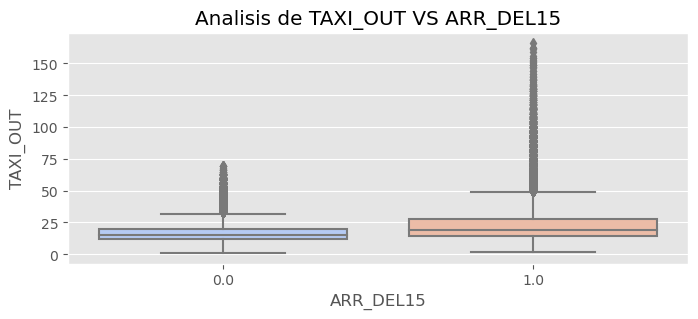


ANÁLISIS DE CRS_ARR_TIME CON RESPECTO AL ARR_DEL15

                   len       min      mean       max
             ARR_DEL15 ARR_DEL15 ARR_DEL15 ARR_DEL15
CRS_ARR_TIME                                        
1                  441      0.00      0.28      1.00
2                   27      0.00      0.07      1.00
3                  162      0.00      0.35      1.00
4                  137      0.00      0.26      1.00
5                  313      0.00      0.24      1.00
...                ...       ...       ...       ...
2356               120      0.00      0.31      1.00
2357               451      0.00      0.25      1.00
2358               305      0.00      0.27      1.00
2359               927      0.00      0.24      1.00
2400                13      0.00      0.31      1.00

[1260 rows x 4 columns]


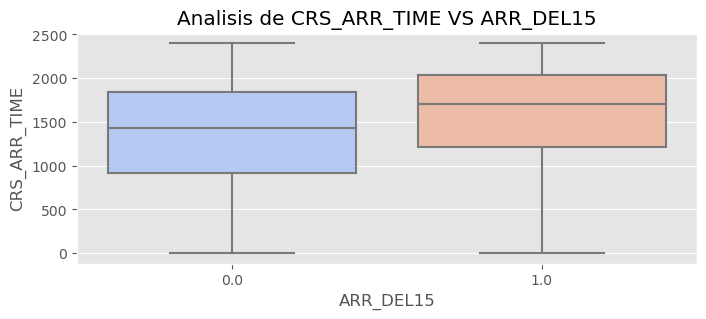


ANÁLISIS DE CRS_ELAPSED_TIME CON RESPECTO AL ARR_DEL15

                       len       min      mean       max
                 ARR_DEL15 ARR_DEL15 ARR_DEL15 ARR_DEL15
CRS_ELAPSED_TIME                                        
47.00                   39      0.00      0.67      1.00
50.00                   22      0.00      0.18      1.00
52.00                   30      0.00      0.43      1.00
54.00                  113      0.00      0.44      1.00
55.00                   50      0.00      0.42      1.00
...                    ...       ...       ...       ...
581.00                  11      0.00      0.64      1.00
585.00                 154      0.00      0.41      1.00
586.00                   2      1.00      1.00      1.00
590.00                 102      0.00      0.21      1.00
595.00                  24      0.00      0.17      1.00

[329 rows x 4 columns]


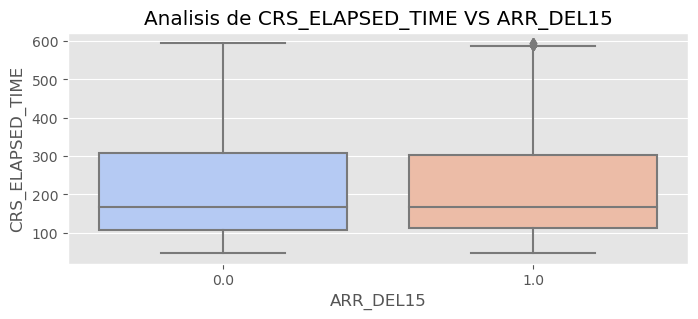

In [72]:
for i in list_num: # for loop para todas las variables numéricas
    print(analisis_numericas(dataframe = jfk, column = i, target = target))
    plot_numericas(dataframe = jfk, column = i, target = target)

Vemos, por ejemplo en el TAXI_OUT, que la caja del 1.0 está por encima de la del 0.0. Eso significa que el TAXI_OUT es mayor en los vuelos que se retrasan. Por lo tanto **el TAXI_OUT va a ser una variable muy importante para el target**

Vemos con más detenimiento alguna de las variables, con otro tipo de gráficos.

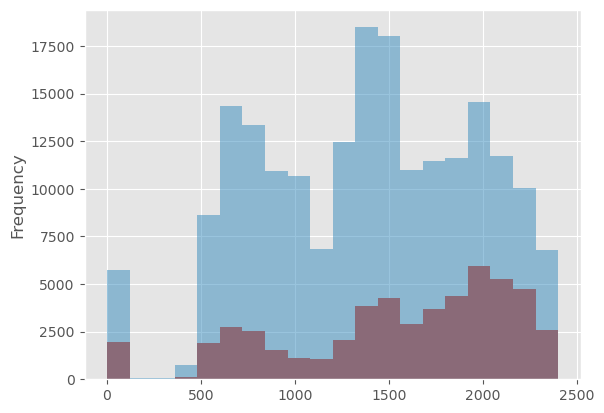

In [73]:
# Hora de salida con vuelos con retraso
jfk[(jfk[target]==1)]['CRS_ARR_TIME'].plot(kind='hist', bins = 20)
# Hora de salida con vuelos sin retraso
jfk[(jfk[target]==0)]['CRS_ARR_TIME'].plot(kind='hist', bins = 20, alpha = 0.5);

En las últimas horas del día es donde se producen los mayores retrasos en la salida de los vuelos.

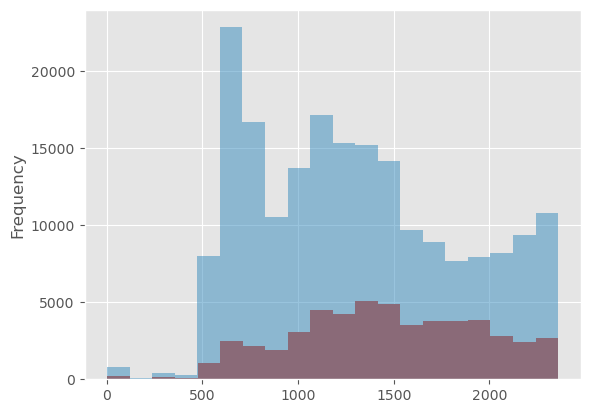

In [74]:
# Hora de llegada con vuelos con retraso
jfk[(jfk[target]==1)]['CRS_DEP_TIME'].plot(kind='hist', bins = 20)
# Hora de llegada con vuelos sin retraso
jfk[(jfk[target]==0)]['CRS_DEP_TIME'].plot(kind='hist', bins = 20, alpha = 0.5);

En las horas centrales del día es donde se producen los mayores retrasos en la llegada de los vuelos.

Como alternativa, podemos utilizar los métodos de seaborn, que nos permiten además mostrar de una manera muy sencilla gráficos combinados con varias variables. 

**C.- VARIABLES CATEGÓRICAS**

In [75]:
list_cat

['TAIL_NUM', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_NM']

Realizamos el análisis utilizando un pivot_table y el countplot de seaborn (utilizando el parámetro hue para hacer un split de las categorías que tiene el target)

In [76]:
sns.countplot?

Signature:
sns.countplot(
    data=None,
    *,
    x=None,
    y=None,
    hue=None,
    order=None,
    hue_order=None,
    orient=None,
    color=None,
    palette=None,
    saturation=0.75,
    width=0.8,
    dodge=True,
    ax=None,
    **kwargs,
)
Docstring:
Show the counts of observations in each categorical bin using bars.

A count plot can be thought of as a histogram across a categorical, instead
of quantitative, variable. The basic API and options are identical to those
for :func:`barplot`, so you can compare counts across nested variables.

Note that the newer :func:`histplot` function offers more functionality, although
its default behavior is somewhat different.

.. note::
    This function always treats one of the variables as categorical and
    draws data at ordinal positions (0, 1, ... n) on the relevant axis,
    even when the data has a numeric or date type.

See the :ref:`tutorial <categorical_tutorial>` for more information.    

Parameters
----------
data : DataF

In [77]:
analisis_categoricas??

Signature: analisis_categoricas(dataframe, column, target)
Source:   
def analisis_categoricas (dataframe,column,target):
    '''
    Pivot-table que me da las medidas de las variables categóricas y su correlación con el target
    '''

    print(f"\nANÁLISIS DE {column} CON RESPECTO AL {target}\n")
    
    return dataframe.pivot_table(index=column, values=target, aggfunc=[len,sum,np.mean]).sort_values(by=('len', target),ascending=False)
File:      c:\users\jagui\appdata\local\temp\ipykernel_11692\4246548799.py
Type:      function


In [78]:
plot_categoricas??

Signature: plot_categoricas(dataframe, column, target)
Source:   
def plot_categoricas(dataframe,column,target):
    '''
    Visualización de las variables categóricas y su correlación con el target
    '''    
    if column == 'TAIL_NUM':
        pass
    else:
        plt.figure(figsize=[20,5])
        plt.title(f'Analisis de {column} VS {target}')
        plt.xticks(rotation = 90)   
        sns.countplot(data = dataframe, x = column, hue = target )  

    return plt.show()
File:      c:\users\jagui\appdata\local\temp\ipykernel_11692\3984434524.py
Type:      function



ANÁLISIS DE TAIL_NUM CON RESPECTO AL ARR_DEL15

               len       sum      mean
         ARR_DEL15 ARR_DEL15 ARR_DEL15
TAIL_NUM                              
N110AN         761    164.00      0.22
N113AN         751    134.00      0.18
N111ZM         748    162.00      0.22
N115NN         740    121.00      0.16
N109NN         740    118.00      0.16
...            ...       ...       ...
N921DN           1      0.00      0.00
N703DN           1      0.00      0.00
N922DX           1      0.00      0.00
N924DN           1      0.00      0.00
N928AM           1      0.00      0.00

[2645 rows x 3 columns]

ANÁLISIS DE ORIGIN CON RESPECTO AL ARR_DEL15

             len       sum      mean
       ARR_DEL15 ARR_DEL15 ARR_DEL15
ORIGIN                              
LAX        25345  4,803.00      0.19
SFO        15228  3,448.00      0.23
BOS        11201  2,283.00      0.20
MCO         9450  2,400.00      0.25
CLT         7769  1,764.00      0.23
FLL         7645  2,019.00      0.26


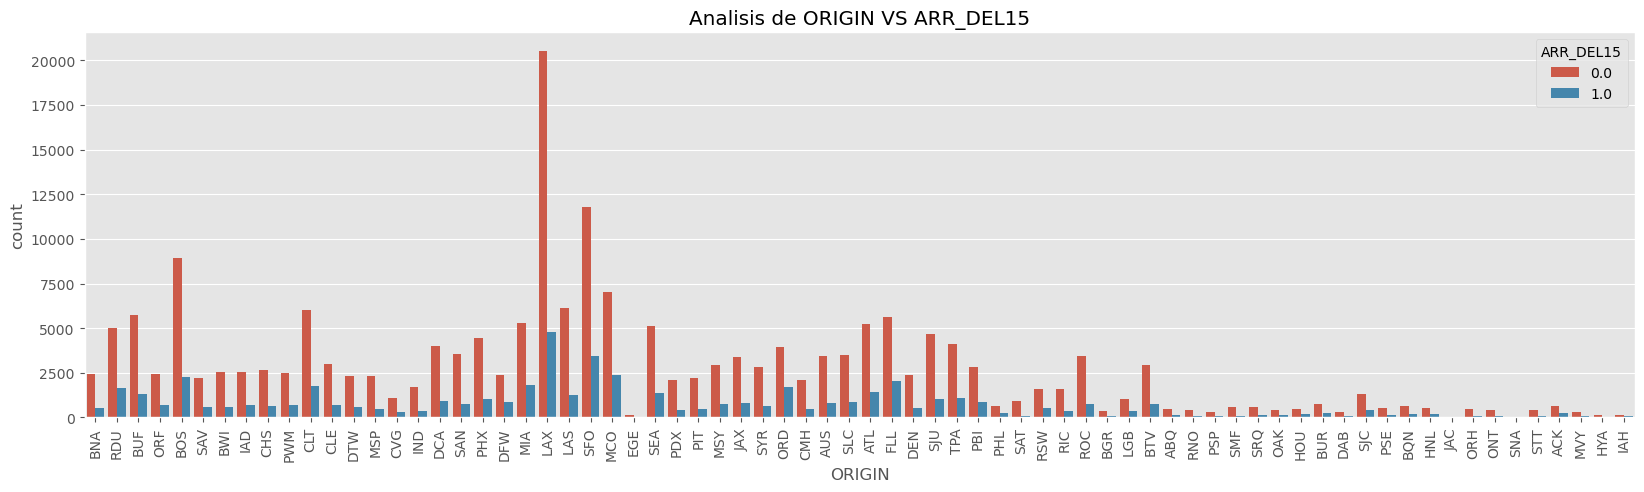


ANÁLISIS DE ORIGIN_CITY_NAME CON RESPECTO AL ARR_DEL15

                                     len       sum      mean
                               ARR_DEL15 ARR_DEL15 ARR_DEL15
ORIGIN_CITY_NAME                                            
Los Angeles, CA                    25345  4,803.00      0.19
San Francisco, CA                  15228  3,448.00      0.23
Boston, MA                         11201  2,283.00      0.20
Orlando, FL                         9450  2,400.00      0.25
Washington, DC                      8197  1,619.00      0.20
Charlotte, NC                       7769  1,764.00      0.23
Fort Lauderdale, FL                 7645  2,019.00      0.26
Las Vegas, NV                       7377  1,258.00      0.17
Miami, FL                           7071  1,803.00      0.25
Buffalo, NY                         7049  1,300.00      0.18
Atlanta, GA                         6687  1,449.00      0.22
Raleigh/Durham, NC                  6665  1,646.00      0.25
Seattle, WA                 

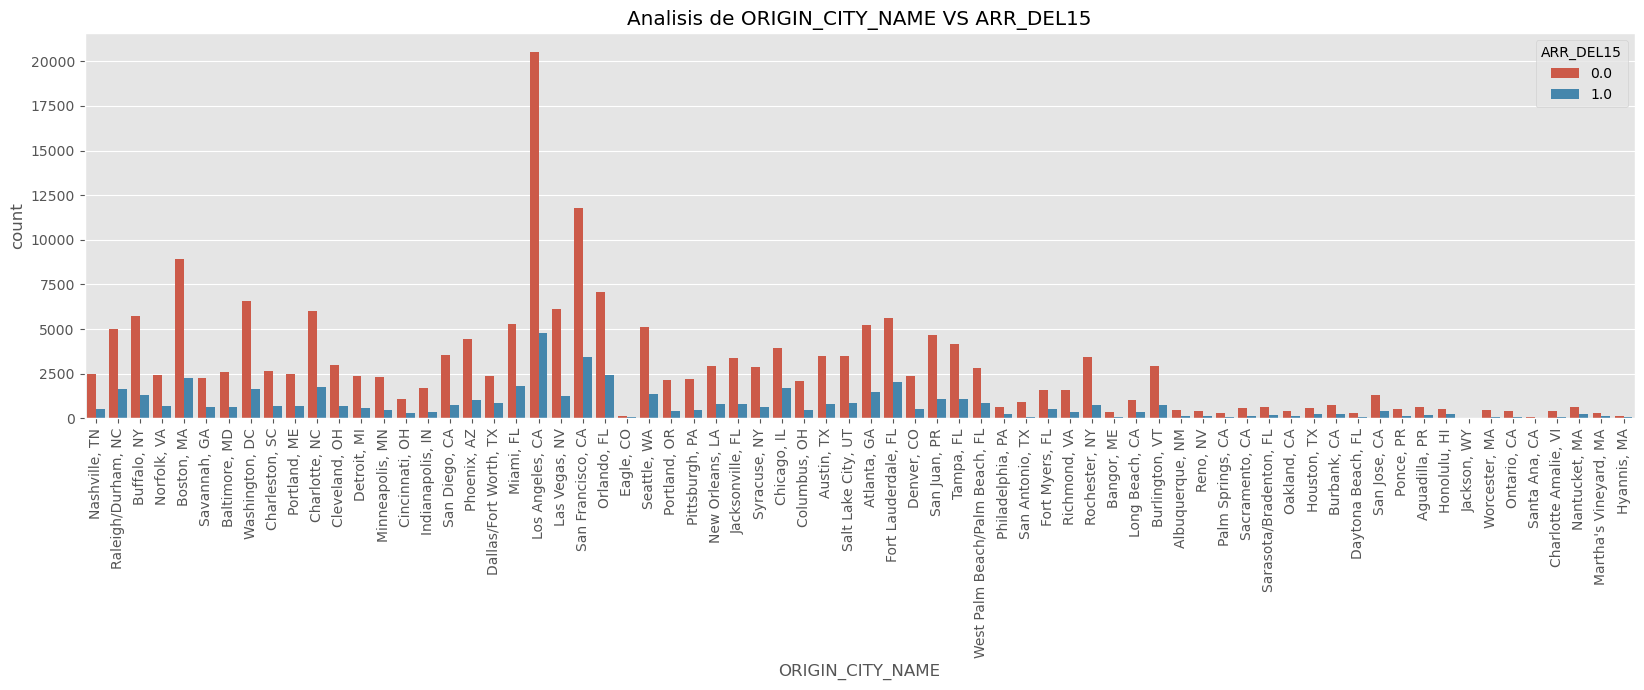


ANÁLISIS DE ORIGIN_STATE_NM CON RESPECTO AL ARR_DEL15

                          len       sum      mean
                    ARR_DEL15 ARR_DEL15 ARR_DEL15
ORIGIN_STATE_NM                                  
California              51137 10,412.00      0.20
Florida                 40488  9,747.00      0.24
New York                14709  2,667.00      0.18
North Carolina          14434  3,410.00      0.24
Massachusetts           13273  2,799.00      0.21
Virginia                13250  2,670.00      0.20
Georgia                  9534  2,059.00      0.22
Texas                    9322  2,012.00      0.22
Nevada                   7902  1,360.00      0.17
Puerto Rico              7223  1,395.00      0.19
Washington               6491  1,375.00      0.21
Ohio                     6256  1,196.00      0.19
Illinois                 5647  1,705.00      0.30
Arizona                  5460  1,021.00      0.19
Utah                     4329    844.00      0.19
Louisiana                3707    772.00     

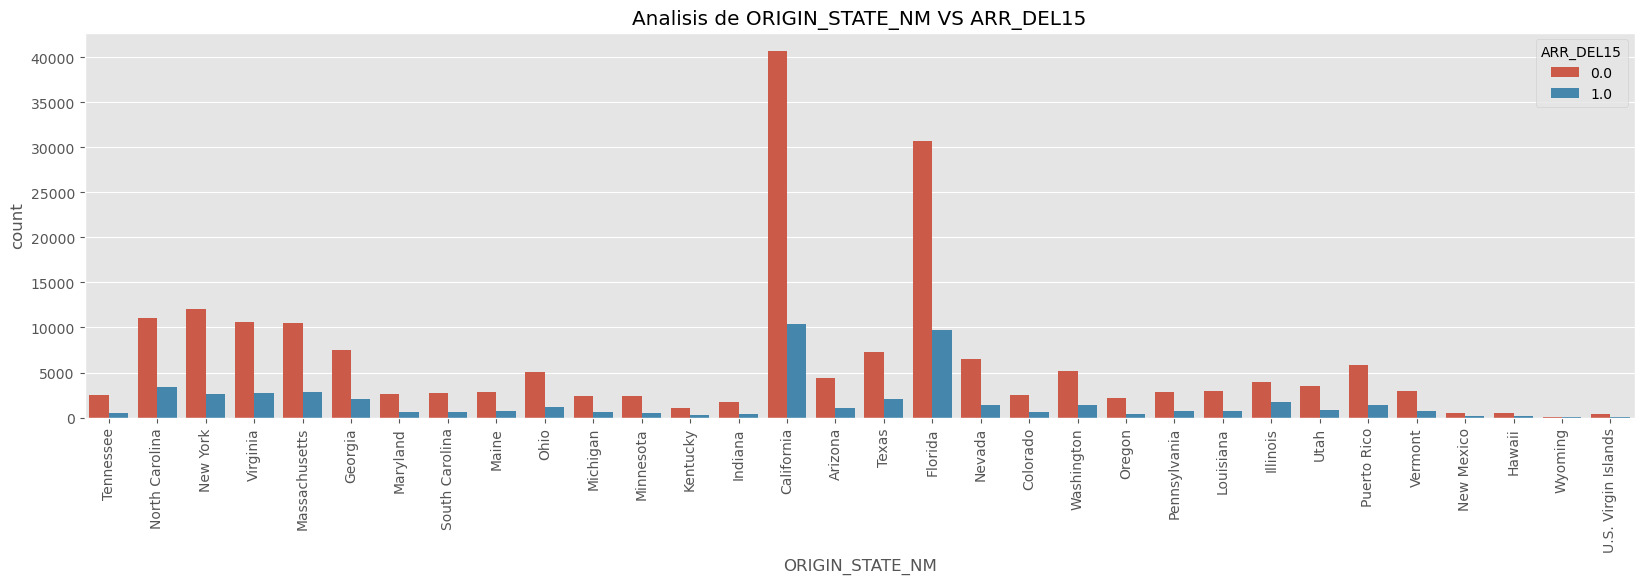

In [79]:
for i in list_cat: # for loop para todas las variables categóricas
    print(analisis_categoricas(dataframe = jfk, column = i, target = target))
    plot_categoricas(dataframe = jfk, column = i, target = target)

Vemos varias cosas importantes para el target:
- En principio el número de vuelos no influye en el retraso
- Hay ciudades y estados que tienen más retrasos que otros.

# **4. DATA PREPARATION**  -->  *Pre-processing*

### 4.1.- Imputación de nulos

**A.- VARIABLES CATEGÓRICAS**

In [80]:
# Listamos los nulos de las variables categóricas
jfk.select_dtypes(include = ['object']).isnull().sum()

TAIL_NUM            15009
ORIGIN                  0
ORIGIN_CITY_NAME        0
ORIGIN_STATE_NM         0
dtype: int64

*OP_CARRIER_AIRLINE_ID*

In [81]:
jfk['OP_CARRIER_AIRLINE_ID'].dtype

dtype('float64')

*Se trata de un número que no tiene ningún significado, más allá que el de identificar de forma única a la compañía aerea. Por lo tanto, convertimos esta variable en una categórica*. 

In [82]:
# Convertimos en categorica
jfk['OP_CARRIER_AIRLINE_ID'] = jfk['OP_CARRIER_AIRLINE_ID'].astype(object)

In [83]:
jfk['OP_CARRIER_AIRLINE_ID'].dtype

dtype('O')

In [84]:
# Cantidad de compañías aereas
jfk['OP_CARRIER_AIRLINE_ID'].nunique()

11

In [85]:
jfk['OP_CARRIER_AIRLINE_ID'].value_counts()

20,409.00    78587
19,790.00    58894
20,363.00    40833
19,805.00    30694
20,398.00     8814
19,930.00     8591
20,452.00     5044
20,304.00     3993
21,171.00      944
19,690.00      695
20,397.00      555
Name: OP_CARRIER_AIRLINE_ID, dtype: int64

In [86]:
# Matrícula de cola de los aviones que tiene la compañia 20409 y número de vuelos de cada uno de ellos
jfk[jfk['OP_CARRIER_AIRLINE_ID']==20409]['TAIL_NUM'].value_counts()

N959JB    569
N957JB    557
N970JB    552
N948JB    541
N907JB    535
         ... 
N527JL     18
N2029J     17
N2038J     10
N977JB      8
N2017J      4
Name: TAIL_NUM, Length: 303, dtype: int64

El avión que más vuelos realiza es el N959JB

In [87]:
# Nulos que tiene
jfk[jfk['OP_CARRIER_AIRLINE_ID'].isnull()]

,FL_DATE,OP_CARRIER_AIRLINE_ID,TAIL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,CRS_DEP_TIME,TAXI_OUT,CRS_ARR_TIME,ARR_DEL15,CRS_ELAPSED_TIME
41,2018-02-01,NaN,N845NN,MCO,"Orlando, FL",Florida,1320,NaN,1603,0.00,163.00
44,2018-02-01,NaN,N897NN,CLT,"Charlotte, NC",North Carolina,1603,13.00,1804,0.00,121.00
87,2018-02-01,NaN,N314NB,MSY,"New Orleans, LA",Louisiana,1140,10.00,1540,0.00,180.00
89,2018-02-01,NaN,N187DN,SFO,"San Francisco, CA",California,830,27.00,1710,0.00,340.00
117,2018-02-01,NaN,NaN,SAN,"San Diego, CA",California,2247,12.00,705,0.00,318.00
...,...,...,...,...,...,...,...,...,...,...,...
250056,2018-10-31,NaN,N996JB,MCO,"Orlando, FL",Florida,1757,18.00,2032,0.00,155.00
250058,2018-10-31,NaN,N905JB,MCO,"Orlando, FL",Florida,1958,16.00,2228,0.00,150.00
250069,2018-10-31,NaN,NaN,LAX,"Los Angeles, CA",California,2114,13.00,532,0.00,318.00
250094,2018-10-31,NaN,N280SY,ORD,"Chicago, IL",Illinois,1200,12.00,1526,0.00,146.00


Para imputar los nulos nos ayudamos de fuentes externas: 
- https://www.airfleets.es/home/
- https://aspm.faa.gov/aspmhelp/index/ASQP__Carrier_Codes_and_Names.html
- https://www.faa.gov/air_traffic/separation_standards/naarmo/rvsm_approvals


Por ejemplo, el avión con TAIL_NUM N115NN, es un Airbus A321, con número de serie 6063, que pertenece a la compañía aerea American Airlines y cuyo código identificativo es AA (IATA code) y AAL (ICAO code). En cambio el dataset nos da un código numérico, por lo que se deduce que estos códigos son inventados.

In [88]:
# cantidad de aviones
jfk['TAIL_NUM'].unique()

array(['N299PQ', 'N920XJ', 'N605LR', ..., 'N226JS', 'N251PS', 'N945DN'],
      dtype=object)

Por otro lado, si fuesen reales, el tratar de imputar los nulos de esta variable buscando con cada uno de los códigos de los aviones a qué compañía pertenecen es inviable, dado que tenemos 2645 aviones diferentes en el dataset.

Al rellenar nulos de una variable categórica, hay que tener en cuenta que las variables categóricas se convierten con One Hot Encoder normalmente. Si creemos que los nulos pueden contener información relevante, los imputamos con un valor único. Si no queremos mantener esta información, no es necesario realizar ningún tratamiento de nulos, ya que al hacer el OHE simplemente no se creará una columna específica para ellos.

Por lo tanto tenemos varias posibilidades:
- Rellenar con el valor más frecuente (avión más frecuente en la companía)
- Rellenar con un valor único
- Dejarlo como nulo

En este caso, como vamos a utilizar modelos con DecisionTree, imputamos los nulos con un valor extremo y único 'ZZZ'. *Los outliers no afectan a los DecisionTree, en cambio sí afectan, y mucho, a las Regresiones*.

In [89]:
pd.DataFrame.fillna?

Signature:
pd.DataFrame.fillna(
    self,
    value: 'object | ArrayLike | None' = None,
    method: 'FillnaOptions | None' = None,
    axis: 'Axis | None' = None,
    inplace: 'bool' = False,
    limit=None,
    downcast=None,
) -> 'DataFrame | None'
Docstring:
Fill NA/NaN values using the specified method.

Parameters
----------
value : scalar, dict, Series, or DataFrame
    Value to use to fill holes (e.g. 0), alternately a
    dict/Series/DataFrame of values specifying which value to use for
    each index (for a Series) or column (for a DataFrame).  Values not
    in the dict/Series/DataFrame will not be filled. This value cannot
    be a list.
method : {'backfill', 'bfill', 'pad', 'ffill', None}, default None
    Method to use for filling holes in reindexed Series
    pad / ffill: propagate last valid observation forward to next valid
    backfill / bfill: use next valid observation to fill gap.
axis : {0 or 'index', 1 or 'columns'}
    Axis along which to fill missing values.
in

In [90]:
jfk['OP_CARRIER_AIRLINE_ID'].fillna(value = 'ZZZ', inplace = True)

In [91]:
jfk['OP_CARRIER_AIRLINE_ID'].value_counts()

20409.0    78587
19790.0    58894
20363.0    40833
19805.0    30694
ZZZ        12508
20398.0     8814
19930.0     8591
20452.0     5044
20304.0     3993
21171.0      944
19690.0      695
20397.0      555
Name: OP_CARRIER_AIRLINE_ID, dtype: int64

*TAIL_NUM*

In [92]:
jfk['TAIL_NUM'].nunique()

2645

In [93]:
jfk['TAIL_NUM'].value_counts(dropna = False)

NaN       15009
N110AN      761
N113AN      751
N111ZM      748
N115NN      740
          ...  
N197UW        1
N986AN        1
N315RJ        1
N801AW        1
N945DN        1
Name: TAIL_NUM, Length: 2646, dtype: int64

Tenemos 2645 aviones, cuyo número identificativo está formado por tres partes:
- La primera letra indica en qué pais está registrado el avión. En nuestro dataset sólo hay aviones con la letra "N" que indica que son de USA.
- A continuación vienen 3 números, a partir de los cuales podemos saber de qué año es el avión, ya que se tratan de números correlativos de más antiguo a más nuevo.
- Las últimas dos letras indican la compañía a la que pertenecen. Aunque esto es relativo, ya que debido a las diferentes fusiones entre compañías un avión que tenga las letras de una compañía puede estar en otra.

Imputamos los nulos con un valor extremo y único 'ZZZ'

In [94]:
jfk['TAIL_NUM'].fillna(value = 'ZZZ', inplace = True)

In [95]:
jfk['TAIL_NUM'].value_counts()

ZZZ       15009
N110AN      761
N113AN      751
N111ZM      748
N115NN      740
          ...  
N197UW        1
N986AN        1
N315RJ        1
N801AW        1
N945DN        1
Name: TAIL_NUM, Length: 2646, dtype: int64

**B.- VARIABLES NUMÉRICAS**

In [96]:
# Listamos los nulos de las variables numéricas
jfk.select_dtypes(include = ['number']).isnull().sum()

CRS_DEP_TIME            0
TAXI_OUT            17511
CRS_ARR_TIME            0
ARR_DEL15               0
CRS_ELAPSED_TIME        0
dtype: int64

*TAXI_OUT*

In [97]:
jfk['TAXI_OUT'].value_counts(dropna = False)

13.00     18840
12.00     18344
14.00     18119
NaN       17511
15.00     16614
          ...  
146.00        1
161.00        1
159.00        1
140.00        1
156.00        1
Name: TAXI_OUT, Length: 155, dtype: int64

En las variables numéricas, podemos imputar con cualquier valor: 
- Valores concretos
- Valores medios o medianas

O bien podemos eliminar los registros que los contienen.

En nuestro caso, imputaremos con una valor extremo, ya que al trabajar con Decision Tress no le va afectar. 

Otra cosa es si trabajamos con regresiones lineales, ya que funcionan mal con valores extremos.

In [98]:
jfk['TAXI_OUT'].fillna(value = -999, inplace = True)

In [99]:
jfk['TAXI_OUT'].value_counts()

13.00      18840
12.00      18344
14.00      18119
-999.00    17511
15.00      16614
           ...  
146.00         1
161.00         1
159.00         1
140.00         1
156.00         1
Name: TAXI_OUT, Length: 155, dtype: int64

In [100]:
# Comprobamos que todos los nulos están imputados
jfk.isnull().sum()

FL_DATE                  0
OP_CARRIER_AIRLINE_ID    0
TAIL_NUM                 0
ORIGIN                   0
ORIGIN_CITY_NAME         0
ORIGIN_STATE_NM          0
CRS_DEP_TIME             0
TAXI_OUT                 0
CRS_ARR_TIME             0
ARR_DEL15                0
CRS_ELAPSED_TIME         0
dtype: int64

### 4.2.- Tratamiento de fechas

Extraemos información relevante de las fechas (día, mes, año, ...) y la guardamos en nuevas variables que van a ser más fáciles de trabajar con ellas en el modelo.

In [101]:
jfk['SEASON'] = jfk['FL_DATE'].dt.quarter
jfk['YEAR'] = jfk['FL_DATE'].dt.year
jfk['MONTH'] = jfk['FL_DATE'].dt.month
jfk['WEEK'] = jfk['FL_DATE'].dt.week
jfk['WEEKDAY'] = jfk['FL_DATE'].dt.weekday

In [102]:
jfk.sample(1).T

,4155
FL_DATE,2018-02-14 00:00:00
OP_CARRIER_AIRLINE_ID,"20,409.00"
TAIL_NUM,N961JB
ORIGIN,LAX
ORIGIN_CITY_NAME,"Los Angeles, CA"
ORIGIN_STATE_NM,California
CRS_DEP_TIME,1415
TAXI_OUT,17.00
CRS_ARR_TIME,2229
ARR_DEL15,0.00


Es importante revisar el orden con el que genera el día de la semana ya que la semana puede empezar en lunes o en domingo. 

Cogemos un registro cualquiera del dataset para checkear la fecha. El 6 de Octubre de 2019 fue Domingo, que equivale al weeekday igual a 6. Eso significa que la semana empieza con 0 (el lunes es un 0 en el weekday):
- 0 --> lunes
- 1 --> martes
- 2 --> miércoles
- 3 --> jueves
- 4 --> viernes
- 5 --> sábado
- 6 --> domingo

In [103]:
jfk['WEEKDAY'].value_counts(dropna=False)

0    37183
4    36848
3    36679
6    36288
1    35945
2    35443
5    31766
Name: WEEKDAY, dtype: int64

Si detectamos que hay mayores retrasos en fin de semana, podemos generar una variable WEEKEND. De esta forma le estamos mostrando al módelo que días son fin de semana.

Los Decision Trees toman cada variable y las divide en dos grupos a partir de un valor en concreto (1, 2, ...), de forma que un grupo se parezca lo más posible al target (grupo puro) y el otro no (grupo impuro).

En nuestro caso, al estar codificado el lunes como 0 y domingo como 6, al modelo le da igual si hacemos la transformación WEEKEND (WEEKDAY>=5) porque tanto si la hacemos como si no, necesita un único corte en ambos casos.

En cambio si la semana empezase en domingo (codificado como 0) y terminase en sábado (codificado como 6), sí que sería útil hacer la transformación WEEKEND, ya que en este caso el modelo necesitaría dos cortes para discriminar los fines de semana.

In [104]:
# Genero la variable booleana WEEKEND
jfk['WEEKEND'] = (jfk['WEEKDAY']>=5).astype(int) # 1 si es fin de semana y 0 si no lo es
jfk['WEEKEND'].value_counts()

0    182098
1     68054
Name: WEEKEND, dtype: int64

In [105]:
jfk['SEASON'].value_counts()

3    64557
2    64008
4    62591
1    58996
Name: SEASON, dtype: int64

In [106]:
jfk['YEAR'].value_counts()

2018    125483
2019    124669
Name: YEAR, dtype: int64

In [107]:
jfk['MONTH'].value_counts()

8     21984
7     21862
5     21712
6     21595
10    21378
12    21082
3     21011
9     20711
4     20701
11    20131
1     19489
2     18496
Name: MONTH, dtype: int64

Como ya hemos extraido toda la información de FL_DATE, podemos eliminarla.

In [108]:
# Elimino la fecha
jfk.drop('FL_DATE', inplace=True, axis=1)

In [109]:
jfk.head().T

,0,1,2,3,4
OP_CARRIER_AIRLINE_ID,"20,363.00","20,363.00","20,363.00","20,363.00","20,363.00"
TAIL_NUM,N299PQ,N920XJ,N605LR,N800AY,N600LR
ORIGIN,BNA,RDU,BUF,ORF,BOS
ORIGIN_CITY_NAME,"Nashville, TN","Raleigh/Durham, NC","Buffalo, NY","Norfolk, VA","Boston, MA"
ORIGIN_STATE_NM,Tennessee,North Carolina,New York,Virginia,Massachusetts
CRS_DEP_TIME,1359,1354,1529,1704,1325
TAXI_OUT,27.00,37.00,21.00,36.00,20.00
CRS_ARR_TIME,1719,1541,1709,1845,1454
ARR_DEL15,0.00,0.00,0.00,0.00,0.00
CRS_ELAPSED_TIME,140.00,107.00,100.00,101.00,89.00


In [110]:
jfk.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250152 entries, 0 to 250151
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   OP_CARRIER_AIRLINE_ID  250152 non-null  object 
 1   TAIL_NUM               250152 non-null  object 
 2   ORIGIN                 250152 non-null  object 
 3   ORIGIN_CITY_NAME       250152 non-null  object 
 4   ORIGIN_STATE_NM        250152 non-null  object 
 5   CRS_DEP_TIME           250152 non-null  int64  
 6   TAXI_OUT               250152 non-null  float64
 7   CRS_ARR_TIME           250152 non-null  int64  
 8   ARR_DEL15              250152 non-null  float64
 9   CRS_ELAPSED_TIME       250152 non-null  float64
 10  SEASON                 250152 non-null  int64  
 11  YEAR                   250152 non-null  int64  
 12  MONTH                  250152 non-null  int64  
 13  WEEK                   250152 non-null  int64  
 14  WEEKDAY                250152 non-nu

### 4.3.- Tratamiento de variables categóricas --> *Conversión a numéricas*

Nuestro objetivo es predecir si un vuelo se retrasa más de 15 minutos. Como los modelos se basan en operaciones matemáticas, todas las variables que le pasemos deben estar en formato numérico, por lo que debemos transformar las variables categóricas en numéricas.

Las variables categóricas pueden ser nominales (no se puede establecer un orden entre sus categorías o etiquetas) u ordinales (sus categorías están ordenadas jerárquicamente).

In [111]:
jfk.describe(include='object').T

,count,unique,top,freq
OP_CARRIER_AIRLINE_ID,"250,152.00",12.00,"20,409.00","78,587.00"
TAIL_NUM,250152,2646,ZZZ,15009
ORIGIN,250152,72,LAX,25345
ORIGIN_CITY_NAME,250152,70,"Los Angeles, CA",25345
ORIGIN_STATE_NM,250152,32,California,51137


Para ello disponemos de diferentes técnicas para codificar las variables categóricas:

1. **OrdinalEncoder**: Codificación ordinal que se encuentra en la librería de scikit-learn que lo que hace es reemplazar cada valor de la variable con un número entero único, estableciendo un orden jerárquico. **Se utiliza cuando las variables son ordinales**. Por ejemplo:

In [112]:
jfk['ORIGIN_STATE_NM'].value_counts().sort_values(ascending = True)

Wyoming                   29
U.S. Virgin Islands      478
New Mexico               602
Hawaii                   754
Kentucky                1395
Indiana                 2086
Oregon                  2528
Minnesota               2806
Michigan                2911
Tennessee               3004
Colorado                3072
Maryland                3179
South Carolina          3338
Pennsylvania            3537
Maine                   3597
Vermont                 3674
Louisiana               3707
Utah                    4329
Arizona                 5460
Illinois                5647
Ohio                    6256
Washington              6491
Puerto Rico             7223
Nevada                  7902
Texas                   9322
Georgia                 9534
Virginia               13250
Massachusetts          13273
North Carolina         14434
New York               14709
Florida                40488
California             51137
Name: ORIGIN_STATE_NM, dtype: int64

In [113]:
jfk['ORIGIN_STATE_NM'].value_counts().sort_values(ascending = True).index.to_list()

['Wyoming',
 'U.S. Virgin Islands',
 'New Mexico',
 'Hawaii',
 'Kentucky',
 'Indiana',
 'Oregon',
 'Minnesota',
 'Michigan',
 'Tennessee',
 'Colorado',
 'Maryland',
 'South Carolina',
 'Pennsylvania',
 'Maine',
 'Vermont',
 'Louisiana',
 'Utah',
 'Arizona',
 'Illinois',
 'Ohio',
 'Washington',
 'Puerto Rico',
 'Nevada',
 'Texas',
 'Georgia',
 'Virginia',
 'Massachusetts',
 'North Carolina',
 'New York',
 'Florida',
 'California']

In [114]:
# Guardamos las categorías en una variable, ordenadas de menor a mayor
categories_origin_state = jfk['ORIGIN_STATE_NM'].value_counts().sort_values(ascending = True).index.to_list()

In [115]:
# Creamos el codificador indicandole el orden de las variables
encoder = OrdinalEncoder(categories = [categories_origin_state])
encoder

OrdinalEncoder(categories=[['Wyoming', 'U.S. Virgin Islands', 'New Mexico',
                            'Hawaii', 'Kentucky', 'Indiana', 'Oregon',
                            'Minnesota', 'Michigan', 'Tennessee', 'Colorado',
                            'Maryland', 'South Carolina', 'Pennsylvania',
                            'Maine', 'Vermont', 'Louisiana', 'Utah', 'Arizona',
                            'Illinois', 'Ohio', 'Washington', 'Puerto Rico',
                            'Nevada', 'Texas', 'Georgia', 'Virginia',
                            'Massachusetts', 'North Carolina', 'New York', ...]])

In [116]:
# Ajustamos el codificador con la variable que queremos codificar y la transformamos
encoder.fit(jfk[['ORIGIN_STATE_NM']])
jfk['ORIGIN_STATE_NM_ENCODED'] = encoder.transform(jfk[['ORIGIN_STATE_NM']])

In [117]:
#Valores antes y después de la codificación
jfk[['ORIGIN_STATE_NM', 'ORIGIN_STATE_NM_ENCODED']].head()

,ORIGIN_STATE_NM,ORIGIN_STATE_NM_ENCODED
0,Tennessee,9.00
1,North Carolina,28.00
2,New York,29.00
3,Virginia,26.00
4,Massachusetts,27.00


In [118]:
# Borramos la variable generada ya que no usaremos este método
del jfk['ORIGIN_STATE_NM_ENCODED']

2. **One-Hot-Encoding**: Se crea una variable binaria 1/0 (llamada dummy) por cada categoría existente en la variable que queremos codificar, de forma que las nuevas variables tendrán un 1 en las observaciones que pertenezcan a esa categoría y un 0 en el resto. **Se utiliza cuando las variables son nominales** (no tienen un orden). Se suele aplicar cuando la variable no tiene demasiadas categorías (para evitar problemas de memoria).
En regresión lineal, es común usar k-1 variables binarias, donde k es el número total de categorías, para evitar añadir una variable redundante (esta es la combinación lineal de las otras), ya que afectará negativamente al rendimiento del modelo. Además, no se pierde información, ya que si el resto de las categorías tienen un 0, se entiende que la categoría correspondiente es la eliminada. Como ejemplo podemos codificar la misma variable:

In [119]:
pd.get_dummies?

Signature:
pd.get_dummies(
    data,
    prefix=None,
    prefix_sep='_',
    dummy_na: 'bool' = False,
    columns=None,
    sparse: 'bool' = False,
    drop_first: 'bool' = False,
    dtype: 'Dtype | None' = None,
) -> 'DataFrame'
Docstring:
Convert categorical variable into dummy/indicator variables.

Parameters
----------
data : array-like, Series, or DataFrame
    Data of which to get dummy indicators.
prefix : str, list of str, or dict of str, default None
    String to append DataFrame column names.
    Pass a list with length equal to the number of columns
    when calling get_dummies on a DataFrame. Alternatively, `prefix`
    can be a dictionary mapping column names to prefixes.
prefix_sep : str, default '_'
    If appending prefix, separator/delimiter to use. Or pass a
    list or dictionary as with `prefix`.
dummy_na : bool, default False
    Add a column to indicate NaNs, if False NaNs are ignored.
columns : list-like, default None
    Column names in the DataFrame to be e

In [120]:
# Creamos las variables binarias usando una función de pandas
dummies_dataframe_ORIGIN_STATE_NM = pd.get_dummies(
    data = jfk['ORIGIN_STATE_NM'], # variable a codificar
    prefix = 'ORIGIN_STATE_NM', # Prefijo de las nuevas variables
    prefix_sep = '_',
    drop_first = False, # No eliminamos la primera categoría
    )
dummies_dataframe_ORIGIN_STATE_NM.head(10).T

,0,1,2,3,4,5,6,7,8,9
ORIGIN_STATE_NM_Arizona,0,0,0,0,0,0,0,0,0,0
ORIGIN_STATE_NM_California,0,0,0,0,0,0,0,0,0,0
ORIGIN_STATE_NM_Colorado,0,0,0,0,0,0,0,0,0,0
ORIGIN_STATE_NM_Florida,0,0,0,0,0,0,0,0,0,0
ORIGIN_STATE_NM_Georgia,0,0,0,0,0,1,0,0,0,0
ORIGIN_STATE_NM_Hawaii,0,0,0,0,0,0,0,0,0,0
ORIGIN_STATE_NM_Illinois,0,0,0,0,0,0,0,0,0,0
ORIGIN_STATE_NM_Indiana,0,0,0,0,0,0,0,0,0,0
ORIGIN_STATE_NM_Kentucky,0,0,0,0,0,0,0,0,0,0
ORIGIN_STATE_NM_Louisiana,0,0,0,0,0,0,0,0,0,0


El siguiente paso es unir el dummies a nuestro dataframe y finalmente eliminar la variable de origen ORIGIN_STATE_NM:

jfk['ORIGIN_STATE_NM'] = pd.concat([jfk, dummies_dataframe_ORIGIN_STATE_NM])

3. **Label Encoding** (Label Encoder --> clase de scikit-learn): Identificamos los diferentes valores existentes en la variable y sustituimos cada uno de ellos por un número entero, comenzando por el 0.

In [121]:
# Instanciamos la clase
le = LabelEncoder()
le

LabelEncoder()

In [122]:
# Entrenamos el codificador con el método fit y transformamos la variable
le.fit(jfk['TAIL_NUM'])
jfk['TAIL_NUM_le'] = le.transform(jfk['TAIL_NUM'])
jfk['TAIL_NUM_le'].head()

0     467
1    2224
2    1258
3    1651
4    1248
Name: TAIL_NUM_le, dtype: int32

In [123]:
# Obtenemos el mismo resultado haciéndolo todo junto
jfk['TAIL_NUM_le'] = le.fit_transform(jfk['TAIL_NUM'])
jfk['TAIL_NUM_le'].head()


0     467
1    2224
2    1258
3    1651
4    1248
Name: TAIL_NUM_le, dtype: int32

In [124]:
# Comprobamos que están todos los aviones
jfk['TAIL_NUM_le'].nunique()

2646

Una vez entrenado el codificador, podemos acceder a sus clases

In [125]:
le.classes_

array(['8805', '8809', 'N101DU', ..., 'N999JB', 'N999JQ', 'ZZZ'],
      dtype=object)

El valor numérico por el que se sustituye a cada una de estas categorías es el índice que ocupa en el array anterior. El avión 8805 tiene un índice 0, por lo que debería ser sustituido por un 0. Lo comprobamos:

In [126]:
jfk[jfk['TAIL_NUM_le'] == 0]['TAIL_NUM']

214806    8805
215526    8805
215527    8805
Name: TAIL_NUM, dtype: object

Eliminamos la variable creada, ya que no utilizaremos esta técnica

In [127]:
del jfk['TAIL_NUM_le']

En aquellas variable categóricas que no tengan un orden y no tengan muchas etiquetas, podemos realizar un One Hot Encoding.

*Veamos qué tecnicas de codificación emplearemos*

In [128]:
jfk.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
OP_CARRIER_AIRLINE_ID,"250,152.00",12.00,"20,409.00","78,587.00"
TAIL_NUM,250152,2646,ZZZ,15009
ORIGIN,250152,72,LAX,25345
ORIGIN_CITY_NAME,250152,70,"Los Angeles, CA",25345
ORIGIN_STATE_NM,250152,32,California,51137


Todas nuestras variables categóricas son candidatas a ser codificadas mediante un One Hot:
- OP_CARRIER_AIRLINE_ID --> generará 12 variables
- TAIL_NUM --> generará 2646 variables
- ORIGIN --> 72 variables
- ORIGIN_CITY_NAME --> 70 variables
- ORIGIN_STATE_NM --> 32 variables

Entre cuatro variables se generarán 186 variables nuevas, que no supone ningún problema para el Decision Tress y tampoco nos va a dar problemas de memoria en nuestro equipo.

En cambio la variable TAIL_NUMBER va a generar demasiadas variables nuevas. Debemos tratarla de otra manera.

Como regla general usaremos la siguiente:
- Si una variable tiene **menos de 100 etiquetas**, aplicaremos **OHE**.
- Si una variable tiene **100 o más etiquetas**, aplicaremos **Frecuency Encoding**.

**TAIL_NUMBER**

Analizamos la correlación que existe entre la variable y el target. Para ello utilizamos un pivot_table y ordenamos los registros en función del número de vuelos que realiza cada avión. 

In [129]:
jfk.pivot_table(index = 'TAIL_NUM', values = target, aggfunc = [len, sum, np.mean]).sort_values(by = [('len', target)], ascending = False)

,len,sum,mean
,ARR_DEL15,ARR_DEL15,ARR_DEL15
TAIL_NUM,,,
ZZZ,15009,"3,109.00",0.21
N110AN,761,164.00,0.22
N113AN,751,134.00,0.18
N111ZM,748,162.00,0.22
N109NN,740,118.00,0.16
...,...,...,...
N745VJ,1,0.00,0.00
N744P,1,0.00,0.00


In [130]:
((jfk['TAIL_NUM'] == 'N110AN').value_counts()[1])/(jfk.shape[0])*100

0.30421503725734755

El avión con mayor número de registros es el N110AN con 761, que tan sólo representa un 0,3% de todos los vuelos. Hacer una codificación One Hot de esta variable va a aportar muy poca información al modelo. Aplicaremos la técnica del **Frecuency Encoding**

Vamos a hacer un conteo de el número de vuelos que realiza cada avión y sustituiremos el valor del número de vuelos por cada avión correspondiente. Con esto conseguimos sustituir la variable categórica por una de numérica. Además, mantenemos cierta información del avión, el número de vuelos puede tener relación con la antigüedad y uso del avión. En consecuencia, aviones que se utilizan más podrían ser más propensos a sufrir averias. Esto son solo hipótesis, dejaremos después que el algoritmo decida si es una buena variable.

In [131]:
# Frecuency Encoding de TAIL_NUM
df_TAIL_NUM = pd.DataFrame (jfk['TAIL_NUM'].value_counts(dropna = False)) # Hago un conteo
df_TAIL_NUM.columns = ['TAIL_NUM_COUNT'] # Renombro la columna
df_TAIL_NUM['TAIL_NUM'] = df_TAIL_NUM.index # Añado la columna TAIL_NUM al df, porque me va a servir para hacer el merge posterior
jfk = jfk.merge(df_TAIL_NUM, on = 'TAIL_NUM') # Hacemos un merge con el dataframe original
jfk.drop('TAIL_NUM', axis = 1, inplace = True) # Eliminamos la variable original

In [132]:
jfk.head().T

,0,1,2,3,4
OP_CARRIER_AIRLINE_ID,"20,363.00","20,363.00","20,363.00","20,363.00","20,363.00"
ORIGIN,BNA,PIT,BOS,PHL,CHS
ORIGIN_CITY_NAME,"Nashville, TN","Pittsburgh, PA","Boston, MA","Philadelphia, PA","Charleston, SC"
ORIGIN_STATE_NM,Tennessee,Pennsylvania,Massachusetts,Pennsylvania,South Carolina
CRS_DEP_TIME,1359,1021,1325,600,1715
TAXI_OUT,27.00,11.00,31.00,19.00,11.00
CRS_ARR_TIME,1719,1158,1454,711,1930
ARR_DEL15,0.00,0.00,0.00,0.00,1.00
CRS_ELAPSED_TIME,140.00,97.00,89.00,71.00,135.00
SEASON,1,1,1,1,1


Sobre el resto de variables categóricas, aplicaremos un OHE que nos generará un total de 186 nuevas columnas.

In [133]:
jfk.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
OP_CARRIER_AIRLINE_ID,"250,152.00",12.00,"20,409.00","78,587.00"
ORIGIN,250152,72,LAX,25345
ORIGIN_CITY_NAME,250152,70,"Los Angeles, CA",25345
ORIGIN_STATE_NM,250152,32,California,51137


In [134]:
list_OHE = ['OP_CARRIER_AIRLINE_ID','ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_NM']

In [135]:
# genera las nuevas variables y elimina al mismo tiempo las antiguas
jfk = pd.get_dummies(data = jfk, prefix=None, prefix_sep="_", columns = list_OHE, drop_first = False)

O bien, podríamos aplicar el OHE a cada una de las variables por separado, aplicando la siguiente función:

In [136]:
def OHE(dataframe, column_name):
  dummies_df= pd.get_dummies(dataframe[column_name], prefix = column_name) # uso el prefix para asegurarme que las etiquetas son únicas
  dataframe=pd.concat([dataframe,dummies_df], axis=1) # Concateno el dataframe con el dummies_df
  #dataframe.drop(column_name, axis = 1, inplace=True) # Una vez hecho el tratamiento, borro la etiqueta original

  return dataframe

In [137]:
# Comprobamos que no queda ninguna variable categórica
jfk.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250152 entries, 0 to 250151
Columns: 198 entries, CRS_DEP_TIME to ORIGIN_STATE_NM_Wyoming
dtypes: float64(3), int32(1), int64(8), uint8(186)
memory usage: 68.2 MB


### 4.4.- Tratamiento de variables numéricas --> *Estandarización y Normalización*

Estandarizar una variable es transformarla de manera que, en lugar de ver los valores reales, vemos que van de 1 a -1, siendo 0 la media, y 1 y -1 los valores que corresponderia a sumar o resta a la media la máxima desviacion típica (que no necesariamente son los valores máximos y mínimos). Existen diferentes formas de hacerlo:

1. **zscore**: es la estandarización más habitual consiste en convertir cada valor en su puntuación típica, es decir, restarle el valor medio y dividirlo por su desviación típica.

In [138]:
from scipy import stats
zscore_df_1 = stats.zscore(jfk, axis=1)
zscore_df_1.head().T

,0,1,2,3,4
CRS_DEP_TIME,6.29,5.52,6.49,3.66,7.25
TAXI_OUT,-0.01,-0.07,0.02,-0.00,-0.09
CRS_ARR_TIME,8.00,6.28,7.13,4.36,8.18
ARR_DEL15,-0.13,-0.13,-0.13,-0.12,-0.13
CRS_ELAPSED_TIME,0.53,0.41,0.31,0.33,0.45
...,...,...,...,...,...
ORIGIN_STATE_NM_Utah,-0.13,-0.13,-0.13,-0.12,-0.13
ORIGIN_STATE_NM_Vermont,-0.13,-0.13,-0.13,-0.12,-0.13
ORIGIN_STATE_NM_Virginia,-0.13,-0.13,-0.13,-0.12,-0.13
ORIGIN_STATE_NM_Washington,-0.13,-0.13,-0.13,-0.12,-0.13


2. **StandarScaler**

In [139]:
z_scaler = StandardScaler()
jfk_z = z_scaler.fit_transform(jfk) # Me devuelve un array
zscore_df_2 = pd.DataFrame(jfk_z)
zscore_df_2.head().T

,0,1,2,3,4
0,0.05,-0.59,-0.02,-1.39,0.72
1,0.31,0.25,0.32,0.28,0.25
2,0.52,-0.45,0.06,-1.22,0.88
3,-0.52,-0.52,-0.52,-0.52,1.94
4,-0.57,-1.01,-1.10,-1.28,-0.62
...,...,...,...,...,...
193,-0.13,-0.13,-0.13,-0.13,-0.13
194,-0.12,-0.12,-0.12,-0.12,-0.12
195,-0.24,-0.24,-0.24,-0.24,-0.24
196,-0.16,-0.16,-0.16,-0.16,-0.16


3. **MinMaxScaler**(Normalización): Transforma linealmente los datos originales. A cada dato se le resta el mínimo, y esa diferencia se divide entre maximo menos minimo. 
Cuando X es el valor máximo, se convertirá a 1; cuando X es un valor mínimo, el nuevo valor correspondiente es 0; El conjunto completo de datos se distribuye dentro del intervalo de 0 a 1.

In [140]:
minMaxResultado=MinMaxScaler()
jfk_mm = minMaxResultado.fit_transform(jfk)
jfk_mm_df = pd.DataFrame(jfk_mm)
jfk_mm_df.head().T

,0,1,2,3,4
0,0.58,0.43,0.56,0.25,0.73
1,0.88,0.87,0.88,0.87,0.87
2,0.72,0.48,0.61,0.30,0.80
3,0.00,0.00,0.00,0.00,1.00
4,0.17,0.09,0.08,0.04,0.16
...,...,...,...,...,...
193,0.00,0.00,0.00,0.00,0.00
194,0.00,0.00,0.00,0.00,0.00
195,0.00,0.00,0.00,0.00,0.00
196,0.00,0.00,0.00,0.00,0.00


In [141]:
# Función que aplica el MinMax a la variable
def minmaxTransformacion(dataframe, variable_transformar):
    minMaxResultado=MinMaxScaler() 
    dataframe[variable_transformar]=minMaxResultado.fit_transform(dataframe[variable_transformar].values.reshape(-1,1))
    return minMaxResultado

***Como vamos a trabajar con un modelo Decision Tress no es necesario hacer ningún tratamiento de estandarización***.

### 4.5.- Dataset final

In [142]:
jfk.head().T

,0,1,2,3,4
CRS_DEP_TIME,"1,359.00","1,021.00","1,325.00",600.00,"1,715.00"
TAXI_OUT,27.00,11.00,31.00,19.00,11.00
CRS_ARR_TIME,"1,719.00","1,158.00","1,454.00",711.00,"1,930.00"
ARR_DEL15,0.00,0.00,0.00,0.00,1.00
CRS_ELAPSED_TIME,140.00,97.00,89.00,71.00,135.00
...,...,...,...,...,...
ORIGIN_STATE_NM_Utah,0.00,0.00,0.00,0.00,0.00
ORIGIN_STATE_NM_Vermont,0.00,0.00,0.00,0.00,0.00
ORIGIN_STATE_NM_Virginia,0.00,0.00,0.00,0.00,0.00
ORIGIN_STATE_NM_Washington,0.00,0.00,0.00,0.00,0.00


In [143]:
jfk.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250152 entries, 0 to 250151
Data columns (total 198 columns):
 #    Column                                           Dtype  
---   ------                                           -----  
 0    CRS_DEP_TIME                                     int64  
 1    TAXI_OUT                                         float64
 2    CRS_ARR_TIME                                     int64  
 3    ARR_DEL15                                        float64
 4    CRS_ELAPSED_TIME                                 float64
 5    SEASON                                           int64  
 6    YEAR                                             int64  
 7    MONTH                                            int64  
 8    WEEK                                             int64  
 9    WEEKDAY                                          int64  
 10   WEEKEND                                          int32  
 11   TAIL_NUM_COUNT                                   int64  
 12   

In [144]:
# Ruta actual
print(os.getcwd())

D:\Data_Science\MACHINE_LEARNING\ML_SUPERVISADO\ML_SUPERVISADO_CLASIFICACION\Machine-Learning-Binary-Classifier-JFK-DELAY


In [145]:
# Guardamos el dataset
jfk.to_pickle('pickle/jfk_final.pkl')
jfk.to_csv('final/jfk_final.csv')

# **5. MODELLING**

In [146]:
# Cargo el modelo
df = pd.read_pickle('pickle/jfk_final.pkl')
df.head().T

,0,1,2,3,4
CRS_DEP_TIME,"1,359.00","1,021.00","1,325.00",600.00,"1,715.00"
TAXI_OUT,27.00,11.00,31.00,19.00,11.00
CRS_ARR_TIME,"1,719.00","1,158.00","1,454.00",711.00,"1,930.00"
ARR_DEL15,0.00,0.00,0.00,0.00,1.00
CRS_ELAPSED_TIME,140.00,97.00,89.00,71.00,135.00
...,...,...,...,...,...
ORIGIN_STATE_NM_Utah,0.00,0.00,0.00,0.00,0.00
ORIGIN_STATE_NM_Vermont,0.00,0.00,0.00,0.00,0.00
ORIGIN_STATE_NM_Virginia,0.00,0.00,0.00,0.00,0.00
ORIGIN_STATE_NM_Washington,0.00,0.00,0.00,0.00,0.00


En este punto iniciamos con la fase de modelización, que ocupa los pasos de generación de la estrategia de validación, el entrenamiento del modelo y el desarrollo de predicciones y la validación de éstas. 

Algunas de las ***estrategias de validación***:
1. **Random Holdout**(Train/Test Split): Con la partición del train (que contiene atributos y target) entrena y obtengo un modelo. Ese modelo se lo entrego a la particion del test (que contine todos los atributos excepto el target). El test con esos atributos va a hacer una predicción. Y finalmente validamos el modelo (cuando el modelo me de la predicción lo comparo con la realidad para ver si lo ha hecho bien o mal). Train y test son particiones aleatorias, pero ambas tienen que tener la misma distribución. La partición de validación no es aleatoria, ya que quiero que se parezca a la realidad (la decidimos nosotros). La partición train debe ser lo suficientemente grande para ajustar el modelo y la partición de validación debe ser lo suficientemente grande para obtener una métrica de validación que sea significativa. Pueden ocurrir dos cosas:
- Si el modelo va bien en train pero mal en test significa que hay un problema de overfiting (el modelo está memorizando).
- Si el modelo va bien en train y test pero mal en validación, el problema es de distribución.
2. **k-Folk Cross Validation**: Se usan cuando nuestro dataset tiene pocos datos. En estas condiciones el Random Holdout no tiene un buen comportamiento. Consiste en hacer "k" particiones diferentes y repetir el proceso de modelización en Train/Test "k" veces con el mismo algoritmo, opteniendo una métrica de rendimiento promedio. Si las métricas de los "k" modelos son similares significa que el modelo no está overfiteando. Las particiones Train/Test son aleatorias, mientras que la partición de validación es la misma en los "k" modelos.
3. **boostrap**

Podemos analizar los métodos disponibles con "??"

In [147]:
model_selection??

Type:        module
String form: <module 'sklearn.model_selection' from 'c:\\Users\\jagui\\anaconda3\\lib\\site-packages\\sklearn\\model_selection\\__init__.py'>
File:        c:\users\jagui\anaconda3\lib\site-packages\sklearn\model_selection\__init__.py
Source:     
import typing

from ._plot import LearningCurveDisplay, ValidationCurveDisplay
from ._search import GridSearchCV, ParameterGrid, ParameterSampler, RandomizedSearchCV
from ._split import (
    BaseCrossValidator,
    BaseShuffleSplit,
    GroupKFold,
    GroupShuffleSplit,
    KFold,
    LeaveOneGroupOut,
    LeaveOneOut,
    LeavePGroupsOut,
    LeavePOut,
    PredefinedSplit,
    RepeatedKFold,
    RepeatedStratifiedKFold,
    ShuffleSplit,
    StratifiedGroupKFold,
    StratifiedKFold,
    StratifiedShuffleSplit,
    TimeSeriesSplit,
    check_cv,
    train_test_split,
)
from ._validation import (
    cross_val_predict,
    cross_val_score,
    cross_validate,
    learning_curve,
    permutation_test_score,
    validation

Y vemos que disponemos de métodos para el random holdout (**train_test_split**) y k-fold (**KFold**).

### 5.1.- Train/Test Split (Random Holdout) --> DecisionTreeClassifier

#### 5.1.1.- Validación tomando como medida el "año" (year)

**A.- Development/Validation**

Nuestro dataset está **particionado temporalmente**, de forma que tenemos un registro único para cada fecha, hora y avión.

En este tipo de datasets, es conveniente guardar las particiones más recientes para hacer la validación del modelo, contrastando que nuestro modelo se pueda generalizar en el tiempo futuro (es de esperar que los retrasos tengan un patrón de comportamiento similar si tomamos como medida el "año").

Para decidir qué partición utilizamos para la validación, vemos el número de registros que hay cada año (**hay que recordar que la partición de validación no es aleatoria, debe ser lo más parecido a la realidad**)

In [148]:
df['YEAR'].value_counts()

2018    125483
2019    124669
Name: YEAR, dtype: int64

Analizamos también el comportamiento en cada partición año/mes

In [149]:
df.pivot_table(
    index = ['YEAR','MONTH'], # Por año y por mes para no mezclar los meses de diferentes años
    values = target, 
    aggfunc = [len, sum, np.mean] # len(nº vuelos), sum(nº vuelos con retraso), mean(promedio de los vuelos con retraso)
)

len       sum      mean
           ARR_DEL15 ARR_DEL15 ARR_DEL15
YEAR MONTH                              
2018 1          9244  1,968.00      0.21
     2          9115  1,418.00      0.16
     3          9927  1,825.00      0.18
     4         10393  2,184.00      0.21
     5         10915  2,478.00      0.23
     6         11052  2,504.00      0.23
     7         11201  3,463.00      0.31
     8         11202  3,345.00      0.30
     9         10591  2,304.00      0.22
     10        10952  1,628.00      0.15
     11        10194  2,138.00      0.21
     12        10697  2,199.00      0.21
2019 1         10245  2,154.00      0.21
     2          9381  1,817.00      0.19
     3         11084  1,812.00      0.16
     4         10308  2,236.00      0.22
     5         10797  2,122.00      0.20
     6         10543  2,743.00      0.26
     7         10661  2,735.00      0.26
     8         10782  2,912.00      0.27
     9         10120  1,544.00      0.15
     10        10426  1,418.00      0.14
     11         9937  1,205.00      0.12
     12        10385  2,480.00      0.24

*Vamos a imaginarnos que queremos hacer una predicción para los primeros meses del 2020*. ¿Qué partición podemos hacer?:
- Podemos tirar de fechas
- Podemos elegir el mismo periodo del año anterior (partición estacional)
- Podemos comparar con los datos más recientes (tendencia)
- Podemos utilizar los datos de un aeropuerto parecido al que vamos a aplicar el modelo

Elegimos los registros de los últimos 6 meses del 2019 para realizar la validación (**validation split**) y el resto para realizar el entrenamiento del modelo (**train/test --> development split**).

In [150]:
dev_df = jfk[(jfk['YEAR'] == 2018) | (jfk['MONTH'] < 7) ] # development split = train + test
val_df = jfk[(jfk['YEAR'] == 2019) & (jfk['MONTH'] >= 7)] # validation split

In [151]:
# Train/Test
dev_df.shape

(187841, 198)

In [152]:
# Validation
val_df.shape

(62311, 198)

*La partición de validación de be tener como mínimo 1000 o 2000 filas, por lo que vamos sobrados (tenemos 62311 filas)*

In [153]:
#Compruebo que no me he dejado ningún registro
len(dev_df)+len(val_df)==len(df)

True

*Me aseguro de que la distribucion de train y test sean la misma*, porque si funciona bien en train y no funciona bien en test, sabré que la causa es que está memorizando (**overfiting**).

Para hacer esto tengo que **separar atributos y target** (sin meter el inplace=True porque el original no quiero modificarlo) --> esto lo hago **tanto para validacion como para development**.

- A los atributos le asigno la variable X
- Al target le asigno la variable y

In [154]:
# Dataframe Train/Test
dev_df_X = dev_df.drop(target, axis=1) # no aplico inplace = True
dev_df_y = dev_df[[target]] # ponemos doble claudator ya que usaremos un dataframe

In [155]:
# Dataframe Validation
val_df_X = val_df.drop(target, axis=1) # no aplico inplace = True
val_df_y = val_df[[target]] # ponemos doble claudator ya que usaremos un dataframe

In [156]:
dev_df_X.head().T

,0,1,2,3,4
CRS_DEP_TIME,"1,359.00","1,021.00","1,325.00",600.00,"1,715.00"
TAXI_OUT,27.00,11.00,31.00,19.00,11.00
CRS_ARR_TIME,"1,719.00","1,158.00","1,454.00",711.00,"1,930.00"
CRS_ELAPSED_TIME,140.00,97.00,89.00,71.00,135.00
SEASON,1.00,1.00,1.00,1.00,1.00
...,...,...,...,...,...
ORIGIN_STATE_NM_Utah,0.00,0.00,0.00,0.00,0.00
ORIGIN_STATE_NM_Vermont,0.00,0.00,0.00,0.00,0.00
ORIGIN_STATE_NM_Virginia,0.00,0.00,0.00,0.00,0.00
ORIGIN_STATE_NM_Washington,0.00,0.00,0.00,0.00,0.00


In [157]:
dev_df_y.head().T

,0,1,2,3,4
ARR_DEL15,0.00,0.00,0.00,0.00,1.00


In [158]:
dev_df_X.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187841 entries, 0 to 250151
Columns: 197 entries, CRS_DEP_TIME to ORIGIN_STATE_NM_Wyoming
dtypes: float64(2), int32(1), int64(8), uint8(186)
memory usage: 49.8 MB


In [159]:
dev_df_y.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187841 entries, 0 to 250151
Columns: 1 entries, ARR_DEL15 to ARR_DEL15
dtypes: float64(1)
memory usage: 2.9 MB


In [160]:
val_df_X.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62311 entries, 120 to 250004
Columns: 197 entries, CRS_DEP_TIME to ORIGIN_STATE_NM_Wyoming
dtypes: float64(2), int32(1), int64(8), uint8(186)
memory usage: 16.5 MB


In [161]:
val_df_y.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62311 entries, 120 to 250004
Columns: 1 entries, ARR_DEL15 to ARR_DEL15
dtypes: float64(1)
memory usage: 973.6 KB


**B.- Train/Test Split (Random Holdout)**

Como el dataset de validación es lo suficientemente grande (62311 registros), usaremos como estrategia de validación el Random Holdout (no sería necesario hacer un k-Fold)

In [162]:
model_selection.train_test_split??

Signature:
model_selection.train_test_split(
    *arrays,
    test_size=None,
    train_size=None,
    random_state=None,
    shuffle=True,
    stratify=None,
)
Source:   
@validate_params(
    {
        "test_size": [
            Interval(RealNotInt, 0, 1, closed="neither"),
            Interval(numbers.Integral, 1, None, closed="left"),
            None,
        ],
        "train_size": [
            Interval(RealNotInt, 0, 1, closed="neither"),
            Interval(numbers.Integral, 1, None, closed="left"),
            None,
        ],
        "random_state": ["random_state"],
        "shuffle": ["boolean"],
        "stratify": ["array-like", None],
    },
    prefer_skip_nested_validation=True,
)
def train_test_split(
    *arrays,
    test_size=None,
    train_size=None,
    random_state=None,
    shuffle=True,
    stratify=None,
):
    """Split arrays or matrices into random train and test subsets.

    Quick utility that wraps input validation,
    ``next(ShuffleSplit().split(X, 

In [163]:
# Hacemos el train/test split
X_train, X_test, y_train, y_test = model_selection.train_test_split(
                                        dev_df_X, # dataset development de los atributos (X)
                                        dev_df_y, # dataset development del target (y)
                                        test_size = 0.30, # tamaño del split aleatorio 
                                        random_state = 42 # normalmente usaremos este valor
                                     )                        

*Comprobamos que las distribuciones son similares*

In [164]:
X_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131488 entries, 207503 to 156518
Columns: 197 entries, CRS_DEP_TIME to ORIGIN_STATE_NM_Wyoming
dtypes: float64(2), int32(1), int64(8), uint8(186)
memory usage: 34.9 MB


In [165]:
X_test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56353 entries, 91964 to 105925
Columns: 197 entries, CRS_DEP_TIME to ORIGIN_STATE_NM_Wyoming
dtypes: float64(2), int32(1), int64(8), uint8(186)
memory usage: 14.9 MB


In [166]:
X_train.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
CRS_DEP_TIME,"131,488.00","1,337.92",526.82,4.00,917.00,"1,300.00","1,745.00","2,359.00"
TAXI_OUT,"131,488.00",-53.87,261.58,-999.00,12.00,15.00,21.00,166.00
CRS_ARR_TIME,"131,488.00","1,418.96",579.74,1.00,939.00,"1,457.00","1,910.00","2,400.00"
CRS_ELAPSED_TIME,"131,488.00",195.14,97.35,47.00,108.00,167.00,306.00,595.00
SEASON,"131,488.00",2.20,1.06,1.00,1.00,2.00,3.00,4.00


In [167]:
X_test.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
CRS_DEP_TIME,"56,353.00","1,335.12",525.68,3.00,915.00,"1,300.00","1,740.00","2,359.00"
TAXI_OUT,"56,353.00",-52.08,258.55,-999.00,12.00,15.00,21.00,154.00
CRS_ARR_TIME,"56,353.00","1,419.65",580.85,1.00,944.00,"1,457.00","1,912.00","2,400.00"
CRS_ELAPSED_TIME,"56,353.00",195.47,97.49,47.00,108.00,167.00,306.00,595.00
SEASON,"56,353.00",2.20,1.06,1.00,1.00,2.00,3.00,4.00


Todas los atributos del train tienen una distribución similar a los del test (medias y desviaciones parecidas)

In [168]:
y_train.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
ARR_DEL15,"131,488.00",0.21,0.41,0.00,0.00,0.00,0.00,1.00


In [169]:
y_test.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
ARR_DEL15,"56,353.00",0.21,0.41,0.00,0.00,0.00,0.00,1.00


La distribución del target se comporta igual en el train y en el test

**C.- Model Definition**

Procedimiento para entrenar el modelo:
1. Instanciar el modelo (definir los parámetros)
2. Realizar el entrenamiento (inducción de las reglas concretas a partir de los datos)
3. Predecir (calcular la probabilidad de retraso sobre un dataset nuevo, test, que nos permita medir la bonanza del modelo)

In [170]:
DecisionTreeClassifier??

Init signature:
DecisionTreeClassifier(
    *,
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0,
)
Source:        
class DecisionTreeClassifier(ClassifierMixin, BaseDecisionTree):
    """A decision tree classifier.

    Read more in the :ref:`User Guide <tree>`.

    Parameters
    ----------
    criterion : {"gini", "entropy", "log_loss"}, default="gini"
        The function to measure the quality of a split. Supported criteria are
        "gini" for the Gini impurity and "log_loss" and "entropy" both for the
        Shannon information gain, see :ref:`tree_mathematical_formulation`.

    splitter : {"best", "random"}, default="best"
        The strategy used to choose the split at each node. Supported
        strategies are "best" to choose the bes

In [171]:
# Instanciamos el modelo
dt = DecisionTreeClassifier(
                        criterion = 'gini', # criterio para medir la entropía (desorden). Se puede utilizar: "gini", "entropy" (los dos funcionan bien)
                        splitter = 'best', # Estrategia para elegir la división en cada nodo. Se puede utilizar: "best", "random", ... Normalmente "best"
                        max_depth = 4, # Profundidad máxima del arbol. Importante, regulará el sobreajuste
                        min_samples_split = 500, # Número mínimo de muestras requeridas en cada subgrupo después de cada corte
                        # min_samples_leaf=1, # Importante en regresión (ayuda a suavizar el modelo)
                        # min_weight_fraction_leaf=0.0,
                        # max_features=None, # Número máximo de atributos que se usarán al hacer la división en cada nodo
                        random_state=42, # Controla la aleatoriedad del estimador. Normalmente usaremos 42
                        # max_leaf_nodes=None,
                        # min_impurity_decrease=0.0,
                        # min_impurity_split=None,
                        # class_weight=None,
                        # presort=False,  
                )

In [172]:
dt.fit??

Signature: dt.fit(X, y, sample_weight=None, check_input=True)
Source:   
    @_fit_context(prefer_skip_nested_validation=True)
    def fit(self, X, y, sample_weight=None, check_input=True):
        """Build a decision tree classifier from the training set (X, y).

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csc_matrix``.

        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels) as integers or strings.

        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted. Splits
            that would create child nodes with net zero or negative weight are
            ignored while searching for a split in each node. Splits 

Entrenamos el modelo dándole unas reglas a partir de los datos

In [173]:
%%time
dt.fit(
    X = X_train, # Dataframe de entrenamiento con atributos y sin target
    y = y_train, # Dataframe de entrenamiento con el target
    # sample_weight=None, # Ponderación de las muestras
    # check_input=True, # No se suele usar
)

Wall time: 652 ms


DecisionTreeClassifier(max_depth=4, min_samples_split=500, random_state=42)

Exportamos con formato DOT y lo visualizamos

In [174]:
export_graphviz??

Signature:
export_graphviz(
    decision_tree,
    out_file=None,
    *,
    max_depth=None,
    feature_names=None,
    class_names=None,
    label='all',
    filled=False,
    leaves_parallel=False,
    impurity=True,
    node_ids=False,
    proportion=False,
    rotate=False,
    rounded=False,
    special_characters=False,
    precision=3,
    fontname='helvetica',
)
Source:   
@validate_params(
    {
        "decision_tree": "no_validation",
        "out_file": [str, None, HasMethods("write")],
        "max_depth": [Interval(Integral, 0, None, closed="left"), None],
        "feature_names": ["array-like", None],
        "class_names": ["array-like", "boolean", None],
        "label": [StrOptions({"all", "root", "none"})],
        "filled": ["boolean"],
        "leaves_parallel": ["boolean"],
        "impurity": ["boolean"],
        "node_ids": ["boolean"],
        "proportion": ["boolean"],
        "rotate": ["boolean"],
        "rounded": ["boolean"],
        "special_characters"

In [175]:
# Exportamos el árbol con formato DOT (texto) utilizando la librería graphviz (sirve para visualizar diagramas)
dot_data = export_graphviz(
                        decision_tree = dt, # DecisionTree que queremos exportar
                        out_file = None, # Nombre del archivo para poder exportarlo (None-->Se devuelve como un string)
                        max_depth = None, # Profundidad máxima de la representación (visualiza las X primeras divisiones)
                        feature_names = X_test.columns, # Nombre de los atributos (variables del X_test)
                        class_names = ['No Delay', 'Delay'], # Nombre de las clases del target (0-->No delay, 1-->Delay)
                        # label='all',
                        filled = True, # True --> en Clasificación pinta los nodos para indicar la clase mayoritaria
                        # leaves_parallel=False,
                        impurity = True, # Muestra la impureza de cada nodo
                        # node_ids=False, # Muestra el ID de cada nodo
                        proportion = True, # Visualización de las muestras en proporciones (Si es false, aparecen los totales)
                        rotate = True, # Orienta el árbol de izquierda a derecha en lugar de arriba a abajo
                        rounded = True, # Redondea las esquinas de las cajas de los nodos
                        # special_characters=False,
                        precision = 3, # Dígitos de precisión en la impureza, el threshold y los atributos de cada nodo
                        fontname = 'helvetica'
)

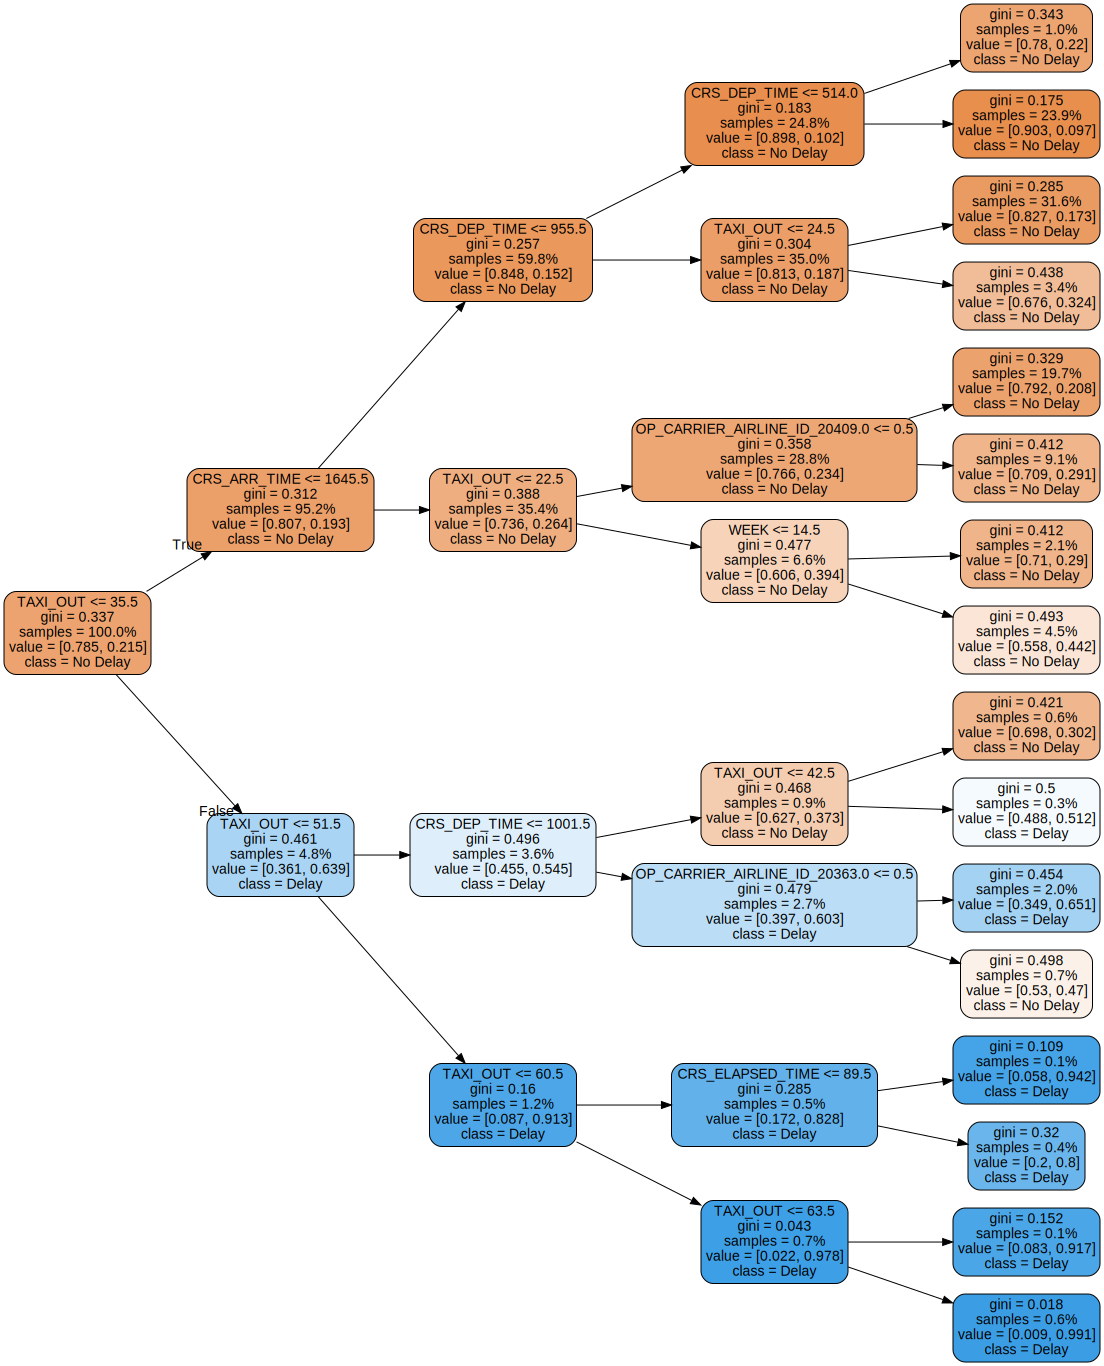

<Figure size 800x800 with 0 Axes>

In [176]:
# Visualizamos el árbol
plt.figure(figsize=(8,8))
graph_dt = graphviz.Source(dot_data, format = 'png') # transformo el texto (formato DOT) en una imagen
graph_dt

La construcción del árbol de decisión se basa en encontrar una **métrica capaz de medir el desorden** en un conjunto de datos en relación al valor del atributo, y que se llama **entropía** (). Por lo tanto, la entropía mide la cantidad de desorden o incertidumbre en el sistema.
- La métrica valdrá 0 cuando todos los individuos de la población (registros) tengan el mismo valor de target (sea 0 o 1). Es decir uno de los grupos tienen casi todos los registros de una de las clases y el otro muy pocos (está muy ordenada).
- la métrica será mayor que cero cuanto mayor sea el desorden en el sistema (cuantos más individuos haya con un valor de target distinto dentro del mismo grupo), hasta un valor máximo de 0,5 en el que la población se divida en dos mitades idénticas (si tenemos dos clases).

Existen varias fórmulas para el cálculo de la entropía. Una de ellas:

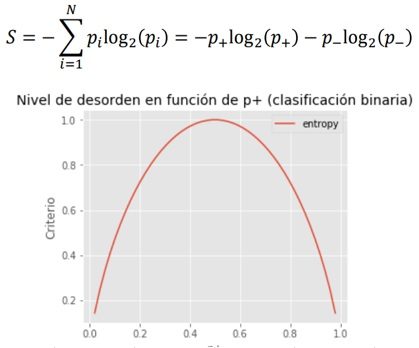

In [177]:
Image('pictures/entropia.jpg')

También se suele utilizar para medir la entopía el **índice Gini**.

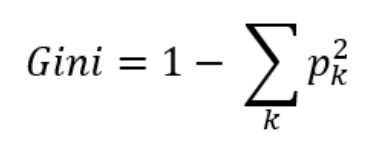

In [178]:
Image('pictures/gini.jpg')

donde pi es la probabilidad de cada una de las clases

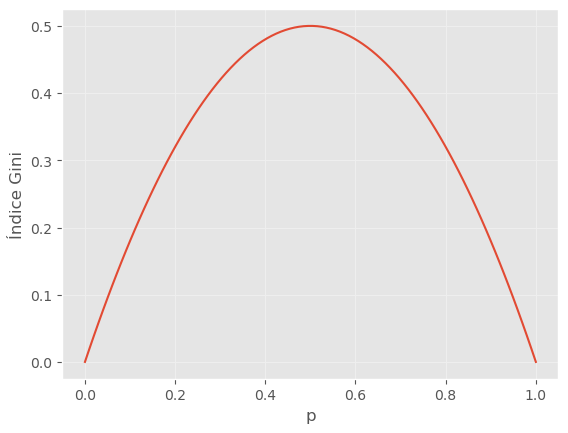

In [179]:
# Gráfica del gini
x = np.linspace(0, 1, 100)
y = 1 - x ** 2 - (1 - x) ** 2
fig, ax = plt.subplots()
ax.plot(x, y)
ax.grid(color = "#EEEEEE", zorder = 0)
ax.set_xlabel("p")
ax.set_ylabel("Índice Gini")
plt.show()

Esto es para dos clases. El índice Gini aumenta a medida que aumenta el número de clases. Por ejemplo, si tenemos 4 clases, el valor máximo de Gini sería:

In [180]:
1 - 0.25**2 - 0.25**2 - 0.25**2 - 0.25**2

0.75

En cada nodo o iteracción nos encontramos con la siguiente información:
- Mejor variable o atributo seleccionado por el algoritmo y a la cual hace una pregunta de Tru/False.
- gini (0,0.5): es la entropía o dispersión
- samples: número total de vuelos
- value: distribución de los vuelos en cuanto al target

* PRIMERA ITERACCIÓN. El algoritmo elige como **variable mas relevante el TAXI_OUT** y pregunta a cada vuelo si tiene un TAXI_OUT<=35.5 (el 95,2% de todos los vuelos es True y el 4,8% es False). De todos los vuelos el 78,5% no se retrasan (No Delay) y el 21,5% se retrasan (Delay). Por lo tanto, tenemos que en este nodo la clase es "No Delay" con un gini de 0,337.
* SEGUNDA ITERACIÓN.
    - TAXI_OUT<=35,5 (95,2% de los vuelos). El algoritmo elige como **variable más relevante el CRS_ARR_TIME** y pregunta a los vuelos de este grupo si tiene un CRS_ARR_TIME <=1645,5.
    - TAXI_OUT>35,5 (4,8% de los vuelos). El algoritmo elige como **variable más relevante el TAXI_OUT** y pregunta a los vuelos de este grupo si tiene un TAXI_OUT <=51,5. En este caso, vemos que el porcentage de vuelos con retraso pasa de un 21,48% a 63,9%.

Y así sucesivamente hasta un total de 4 iteracciones, que es la profundidad de árbol que le hemos dado.

A la última capa se le llama **nodo terminal**. El número de nodos terminales será: 2^profundidad. Por lo tanto, el número de probabilidades diferentes que obtenemos será:

In [181]:
# 16 nodos terminales --> 16 probabilidades diferentes
2**4

16

El cálculo del Gini se ha hecho de la siguiente manera:
- p1 --> P[ "No Delay" ]
- p2 --> P[ "Delay" ]

Gini = 1 - p1^2 - p2^2

In [182]:
# Primera iteración
Gini_1 = 1 - 0.785**2 - 0.215**2
Gini_1

0.33754999999999996

In [183]:
# Segunda iteración. CRS_ARR_TIME
Gini_2A = 1 - 0.807**2 - 0.193**2
Gini_2A

0.31150199999999995

In [184]:
# Segunda iteración. TAXI_OUT
Gini_2B = 1 - 0.361**2 - 0.639**2
Gini_2B

0.461358

**Gini vs Entropía**:
- Gini --> tiende a seleccionar splits que ponen una clase mayoritaria en un sólo nodo y el resto en otros nodos (splits desbalanceados). Es decir, Gini tiende a aislar clases numerosas de otras clases.
- Entropía --> favorece los splits balanceados en número de datos. Es decir, tiende a buscar grupos de clases que sumen más del 50% de los datos.

El fín del DecisionTree es la reducción de la entropía. A la reducción de la entropía se la conoce como **Ganancia de Información (Information Gain)**. IQ para un corte basado en el atributo Q vendría dado por la expresión:

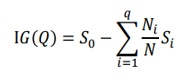

In [185]:
Image('pictures/information_gain.jpg')

siendo:
- q --> número de grupos después del corte (número de clases)
- N --> número de muestras en en ese corte
- Si --> entropía de cada grupo o clase

**En cada corte, el algoritmo se quedará con el atributo con el que se obtenga una IG más alta, o lo que es lo mismo, con el que se obtenga una entropía más baja**

Se puede apreciar que, para el algoritmo, la variable más relevante es TAXI_OUT.

Recordamos el análisis de estas variables relevantes con el target:

In [186]:
# df sin valores nulos de TAXI_OUT (recordemos que les habíamos dado un valor extremo de -999)
df_taxi_out_NotNull = df[(df['TAXI_OUT'] >= 0)]
df_taxi_out_NotNull.head()

,CRS_DEP_TIME,TAXI_OUT,CRS_ARR_TIME,ARR_DEL15,CRS_ELAPSED_TIME,SEASON,YEAR,MONTH,WEEK,WEEKDAY,...,ORIGIN_STATE_NM_Puerto Rico,ORIGIN_STATE_NM_South Carolina,ORIGIN_STATE_NM_Tennessee,ORIGIN_STATE_NM_Texas,ORIGIN_STATE_NM_U.S. Virgin Islands,ORIGIN_STATE_NM_Utah,ORIGIN_STATE_NM_Vermont,ORIGIN_STATE_NM_Virginia,ORIGIN_STATE_NM_Washington,ORIGIN_STATE_NM_Wyoming
0,1359,27.00,1719,0.00,140.00,1,2018,2,5,3,...,0,0,1,0,0,0,0,0,0,0
1,1021,11.00,1158,0.00,97.00,1,2018,2,5,5,...,0,0,0,0,0,0,0,0,0,0
2,1325,31.00,1454,0.00,89.00,1,2018,2,6,1,...,0,0,0,0,0,0,0,0,0,0
3,600,19.00,711,0.00,71.00,1,2018,2,6,3,...,0,0,0,0,0,0,0,0,0,0
4,1715,11.00,1930,1.00,135.00,1,2018,2,6,6,...,0,1,0,0,0,0,0,0,0,0


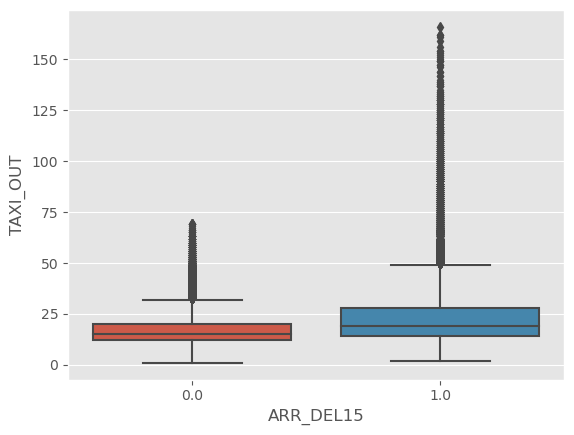

In [187]:
# Análisis de TAXI_OUT
sns.boxplot(data = df_taxi_out_NotNull, x = target, y = 'TAXI_OUT' );

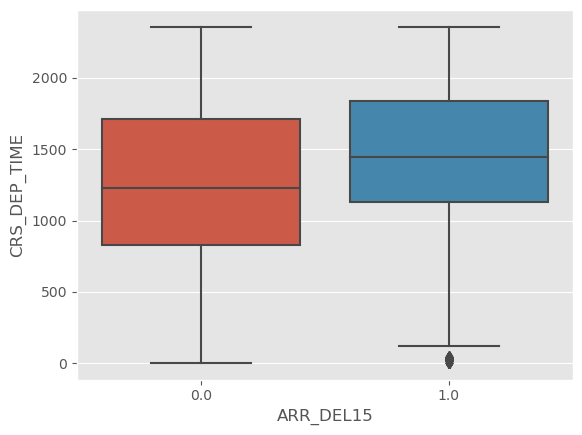

In [188]:
# Análisis de CRS_DEP_TIME
sns.boxplot(data = df, x = target, y = 'CRS_DEP_TIME' );

Otra forma de ver las variables más relevantes es mediante el **feature_importances**

In [189]:
# Variables más relevantes
dt.feature_importances_ # array de coeficientes que el modelo aplica a cada atributo para ponderar

array([0.08728815, 0.70279531, 0.15668835, 0.00095434, 0.        ,
       0.        , 0.        , 0.0188241 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00952253, 0.        , 0.        , 0.02392722,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [190]:
# Convertimos el array en Series Pandas
dt_feature_importance = pd.Series(
    data = dt.feature_importances_, # array de coeficientes
    index = X_train.columns, # nombre de los atributos
).sort_values(ascending = False) # Ordeno de mayor a menor importancia
dt_feature_importance

TAXI_OUT                        0.70
CRS_ARR_TIME                    0.16
CRS_DEP_TIME                    0.09
OP_CARRIER_AIRLINE_ID_20409.0   0.02
WEEK                            0.02
                                ... 
ORIGIN_PHX                      0.00
ORIGIN_PIT                      0.00
ORIGIN_PSE                      0.00
ORIGIN_PSP                      0.00
ORIGIN_STATE_NM_Wyoming         0.00
Length: 197, dtype: float64

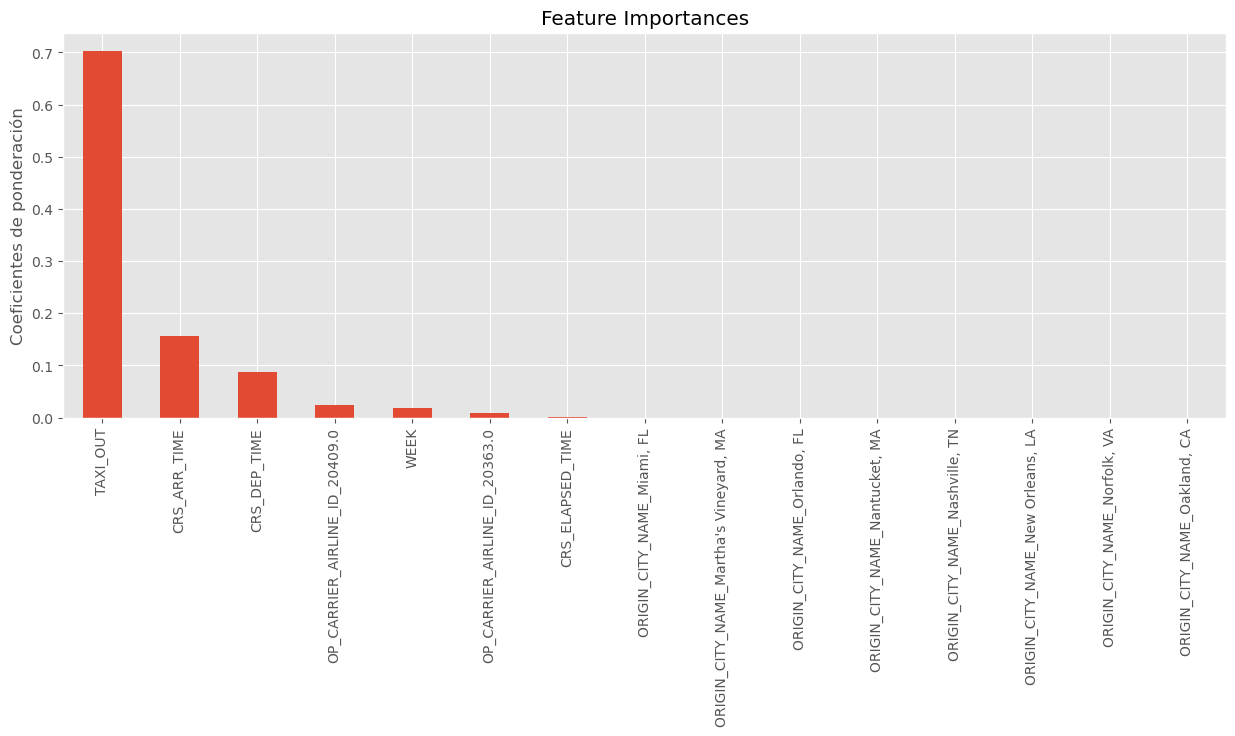

In [191]:
# Visualizamos los atributos importantes
plt.figure(figsize=(15,5))
dt_feature_importance.head(15).plot(kind = 'bar', ylabel = 'Coeficientes de ponderación') # Vemos las 15 más importantes
plt.title('Feature Importances');

Podemos ver que las variables más importantes son el TAXI_OUT y el CRS_ARR_TIME, como ya habíamos visto en la representación del diagrama de árbol.

*En el primer entrenamiento del modelo suelen utilizarse todas las variables y el modelo final se suele entrenar con las 10-15 variables más importantes*

**D.- Model Evaluation**

El modelo ha generado una serie de reglas en base al X_train que le he pasado. Ahora le paso el X_test para que cada uno de sus registros recorran el árbol que se ha generado y obtener una predicción de cada vuelo (de cada registro). Finalmente se comparan los valores de predicción del X_test con el valor correspondiente del y_test (valores del target).

In [192]:
X_test.info(verbose = False)    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56353 entries, 91964 to 105925
Columns: 197 entries, CRS_DEP_TIME to ORIGIN_STATE_NM_Wyoming
dtypes: float64(2), int32(1), int64(8), uint8(186)
memory usage: 14.9 MB


In [193]:
dt.predict??

Signature: dt.predict(X, check_input=True)
Source:   
    def predict(self, X, check_input=True):
        """Predict class or regression value for X.

        For a classification model, the predicted class for each sample in X is
        returned. For a regression model, the predicted value based on X is
        returned.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The input samples. Internally, it will be converted to
            ``dtype=np.float32`` and if a sparse matrix is provided
            to a sparse ``csr_matrix``.

        check_input : bool, default=True
            Allow to bypass several input checking.
            Don't use this parameter unless you know what you're doing.

        Returns
        -------
        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            The predicted classes, or the predict values.
        """
        check_is_fitted(self)
        X = self._

#### OPCIÓN 1: *A través de los resultados*

In [194]:
# Dataframe de la predicción de X_test
y_test_prediction = pd.DataFrame(
    dt.predict(X = X_test), # Array de la predicción de X_test 
    index = y_test.index, # Le doy el mismo índice que el de y_test
    columns=['DelayPrediction']) # Le doy un nombre a la columna

y_test_prediction.head()

,DelayPrediction
91964,1.00
205250,0.00
156190,0.00
117192,0.00
33706,0.00


Podemos unir en un mismo dataframe y_test e y_test_prediction, ya que comparten el mismo índice

In [195]:
# Comparación entre el target y la predicción del X_test
results_df = y_test.join(y_test_prediction, how= 'inner')
results_df

,ARR_DEL15,DelayPrediction
91964,1.00,1.00
205250,1.00,0.00
156190,0.00,0.00
117192,0.00,0.00
33706,0.00,0.00
...,...,...
53676,0.00,0.00
23519,0.00,0.00
22023,0.00,0.00
14082,0.00,0.00


Podemos añadir al dataframe una columna que nos indique si el modelo hecho la predicción bien (1) o no (0).

In [196]:
results_df['Success'] = (results_df[target] == results_df['DelayPrediction']).astype(int)

In [197]:
results_df.sample(20)

,ARR_DEL15,DelayPrediction,Success
138032,0.00,0.00,1
79697,1.00,0.00,0
242727,0.00,0.00,1
121409,0.00,0.00,1
60318,1.00,0.00,0
191881,0.00,0.00,1
189967,0.00,0.00,1
180416,0.00,0.00,1
58620,0.00,0.00,1
151020,0.00,0.00,1


Determinamos el porcentaje de acierto del modelo

In [198]:
# Número de vuelos del X_test
numero_vuelos = results_df['Success'].count()
numero_vuelos

56353

In [199]:
# Número de aciertos del modelo
numero_aciertos = results_df['Success'].sum()
numero_aciertos

45147

In [200]:
# Media de aciertos del modelo (probabilidad de que el modelo acierte) --> Accuracy
probabilidad_acierto = results_df['Success'].mean()
probabilidad_acierto

0.8011463453587209

In [201]:
print('El modelo acierta {} registros de un total de {} vuelos, por lo tanto el Accuracy es {}.'.format(numero_aciertos, numero_vuelos, probabilidad_acierto))

El modelo acierta 45147 registros de un total de 56353 vuelos, por lo tanto el Accuracy es 0.8011463453587209.


#### Opción 2: *A través de la matriz de confusión (**Confusion Matrix**)*

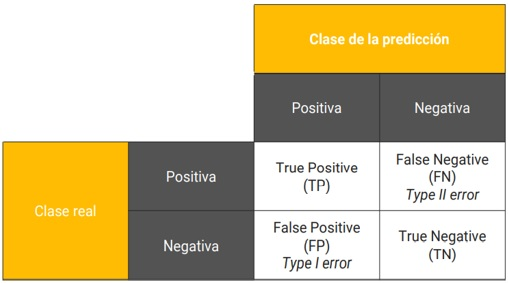

In [202]:
Image('pictures/confusion_matrix.jpg')

- La primera letra indica el grado de acierto: T(True) --> Acierto y F(False) --> Error
- La segunda letra indica la clase de predicción: P(Positive) y N(Negative)

- TP --> Es un 1 y el modelo predice que es un 1
- FN --> Es un 1 y el modelo predice que es un 0
- FP --> Es un 0 y el modelo predice que es un 1
- TN --> Es un 0 y el modelo predice que es un 0

Lo ideal en un modelo sería que se equivocase la mitad en FN y la otra mitad en FP. Aunque hay casos de uso donde es preferible que se equivoque menos en uno que en otro. Por ejemplo en un diagnóstico médico es preferible que se equivoque menos en el FN (si estoy enfermo y predice que no lo estoy, es más costoso) que en el FP (si no estoy enfermo y predice que sí lo estoy, es menos costoso).

Para determinar la Confusion Matriz vamos a utilizar la función **crosstab()** de Pandas, que nos creará una tabla de conteo a partir de los datos del target del X_test y de la predicción del X_test.

In [203]:
pd.crosstab?

Signature:
pd.crosstab(
    index,
    columns,
    values=None,
    rownames=None,
    colnames=None,
    aggfunc=None,
    margins: 'bool' = False,
    margins_name: 'str' = 'All',
    dropna: 'bool' = True,
    normalize=False,
) -> 'DataFrame'
Docstring:
Compute a simple cross tabulation of two (or more) factors. By default
computes a frequency table of the factors unless an array of values and an
aggregation function are passed.

Parameters
----------
index : array-like, Series, or list of arrays/Series
    Values to group by in the rows.
columns : array-like, Series, or list of arrays/Series
    Values to group by in the columns.
values : array-like, optional
    Array of values to aggregate according to the factors.
    Requires `aggfunc` be specified.
rownames : sequence, default None
    If passed, must match number of row arrays passed.
colnames : sequence, default None
    If passed, must match number of column arrays passed.
aggfunc : function, optional
    If specified, re

In [204]:
confusion_matrix = pd.crosstab(
    results_df[target], # le paso el target del X_test (Es una Serie --> 1 dimensión)
    results_df['DelayPrediction'] # le paso la predicción del X_test (Es una Serie --> 1 dimensión)
)
confusion_matrix

DelayPrediction,0.00,1.00
ARR_DEL15,,
0.00,43705,559
1.00,10647,1442


In [205]:
# Asignamos los valores correspondientes a cada parte de la matriz de confusión
TP = confusion_matrix.iloc[1,1]
TN = confusion_matrix.iloc[0,0]
FP = confusion_matrix.iloc[0,1]
FN = confusion_matrix.iloc[1,0]

In [206]:
print('TP = {}, FN = {}, FP = {}, TN = {}'.format(TP, FN, FP, TN))

TP = 1442, FN = 10647, FP = 559, TN = 43705


Una vez calculada la matriz de confusión, podemos determinar diferentes **métricas de validación** con ella: 
- Accuracy
- Precision-Recall
- F1
- AUC

**Accuracy o Precisión**

- Mide el porcentaje de aciertos
- Hay que evaluar la métrica con respecto al target
- *PROBLEMA*: depende de la tasa de aprendizaje (número de instancias de la clase positiva respecto al total)
- *PROBLEMA*: es muy sensible a datasets desbalanceados (proporción muy diferente entre el 0 y el 1)

In [207]:
dt_acc = (TP + TN) / (TP + TN + FP + FN) # Número de aciertos entre el número total
dt_acc

0.8011463453587209

*Otra forma de obtener la metrica es **utilizando la librería metrics** de scikit-learn (calcula la Confusion Matrix internamente)*

In [208]:
metrics??

Type:        module
String form: <module 'sklearn.metrics' from 'c:\\Users\\jagui\\anaconda3\\lib\\site-packages\\sklearn\\metrics\\__init__.py'>
File:        c:\users\jagui\anaconda3\lib\site-packages\sklearn\metrics\__init__.py
Source:     
"""
The :mod:`sklearn.metrics` module includes score functions, performance metrics
and pairwise metrics and distance computations.
"""


from . import cluster
from ._classification import (
    accuracy_score,
    balanced_accuracy_score,
    brier_score_loss,
    class_likelihood_ratios,
    classification_report,
    cohen_kappa_score,
    confusion_matrix,
    f1_score,
    fbeta_score,
    hamming_loss,
    hinge_loss,
    jaccard_score,
    log_loss,
    matthews_corrcoef,
    multilabel_confusion_matrix,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    zero_one_loss,
)
from ._dist_metrics import DistanceMetric
from ._plot.confusion_matrix import ConfusionMatrixDisplay
from ._plot.det_curve import DetCurveDispl

In [209]:
dt_acc = metrics.accuracy_score(y_test, y_test_prediction)
dt_acc

0.8011463453587209

*Otra forma de obtener la metrica es **utilizando el modelo** (calcula la Confusion Matrix internamente)*

In [210]:
DecisionTreeClassifier.score??

Signature: DecisionTreeClassifier.score(self, X, y, sample_weight=None)
Source:   
    def score(self, X, y, sample_weight=None):
        """
        Return the mean accuracy on the given test data and labels.

        In multi-label classification, this is the subset accuracy
        which is a harsh metric since you require for each sample that
        each label set be correctly predicted.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test samples.

        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            True labels for `X`.

        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights.

        Returns
        -------
        score : float
            Mean accuracy of ``self.predict(X)`` w.r.t. `y`.
        """
        from .metrics import accuracy_score

        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
File:      c:\users\jagui\

In [211]:
dt_acc = dt.score(X_test, y_test)
dt_acc

0.8011463453587209

Normalmente usaremos esta forma, el score del modelo por comodidad, pero es bueno ser capaces de generar los distintos métodos para obtener la puntuación para ver otros casos (por ejemplo, que tal han validado las días según mes).

Para saber si el Accuracy es bueno o malo, debemos compararlo con la media del target

In [212]:
df[target].mean()

0.21040007675333397

El 79% de los vuelos no se retrasan --> tasa de aprendizaje del 79%

El modelo predice bien en el 80% de las veces. Este dato puede parecer bueno a simple vista, pero si lo comparamos con la media del target, no es tan bueno.

El modelo más simple podría hacer una predicción de que todos los vuelos no se retrasan y obtendría un 79% de aciertos. En cambio nuestro modelo ha obtenido muy poco más, un 80%. Por lo tanto es un modelo muy malo.

**F1-Score**

- Se utiliza en datasets desbalanceados (no depende de la tasa de aprendizaje)
- Se calcula haciendo la media harmónica de **Precision**(Precisión) y el **Recall**(Alcance).
- **Recall**: Cuántos consigue identificar (TP) del total de positivos reales (TP + FN).
- **Precision**: Del total de positivos predecidos (TP + FP), cuántos lo son realmete (TP).
- Tanto el Recall como el Precision sólo se fijan en la clase positiva o 1 ( no es sensible a datasets desbalanceados)
- *VENTAJAS*: Resume la confusion matrix en una sóla métrica

Recall y Precision normalmente van en direcciones opuestas. Es dificil conseguir que los dos sean altos. El F1, de la forma en que podera, penaliza mucho si uno es muy bajo y el otro muy alto.

In [213]:
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
print('Precision = {}, Recall = {}'.format(Precision, Recall))

Precision = 0.7206396801599201, Recall = 0.11928199189345687


Tenemos un alcance muy bajo. Es un problema porque va a penalizar mucho en el f1_score

In [214]:
f1_score = 2 / ( 1/Precision + 1/Recall )
f1_score


0.20468417317246274

Otra forma de obtener el F1_Score:

In [215]:
metrics.f1_score(y_test, y_test_prediction)

0.20468417317246274

Podemos observar que al tener un Recall tan bajo, ha penalizado mucho en la métrica, obteniendo tan sólo un 0.205

- *PROBLEMAS*: está basado en la Confusion Matrix, fijándose en el 0 y el 1. El modelo me da una predicción con una probabilidad cuyo valor está entre 0 y 1. Tengo que convertir esta probabilidad en un 0 o un 1. Para ello establezco un umbral llamado **threshold** y se hace la predición en función de ese valor. Por ejemplo:

Threshold = 0.5:
* si prob >= 0.5 --> la predicción será 1
* si prob < 0.5 --> la predicción será 0

Si muevo el thresshold:

* muevo las predicciones
* muevo el Recall y el Precision (son sensibles al tresshold)
* muevo el F1-Score

1. Si tengo un *thresshold alto* --> soy muy restrictivo
    * Recall bajo (va a tener un alcance pequeño ya que el modelo predice pocos positivos)
    * Precisión alta (los pocos positivos que predice, son realmente positivos)
2. Si tengo un *thresshold bajo* --> soy muy poco restrictivo
    * Recall alto (va a tener un alcance grande ya que el modelo predice muchos positivos)
    * Precision bajo (muchos de los positivos que predice, no son realmente positivos)

El problema del thresshold lo soluciono con la Curva ROC

**ROC Curve y AUC (Area Under the Curve)**

- Es la métrica de validación más usada en clasificación.
- Permite evaluar el modelo cuando este predice probabilidades.
- Se obtiene una representación gráfica del rendimiento y una métrica agregada (AUC)
- *PROBLEMA*: Sólo debe usarse cuando el dataset está balanceado (hay el mismo número de observaciones para cada clase), ya que si el dataset tiene un gran sesgo en la distribución de clases (desequilibrio de clases), las curvas ROC son demasiado optimistas en cuanto al rendimiento del modelo.

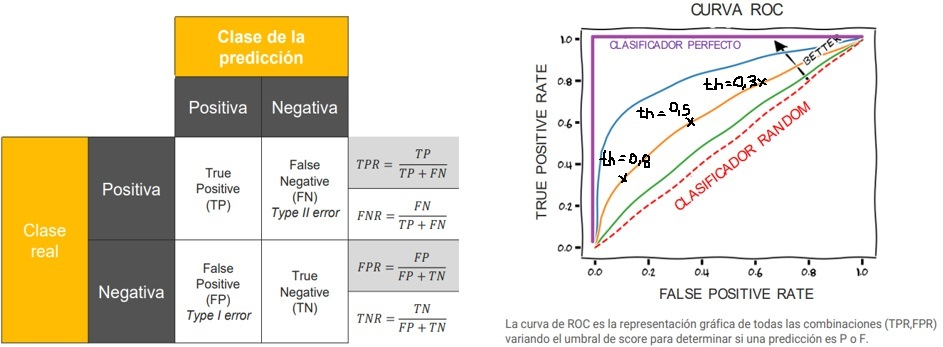

In [216]:
Image('pictures/curva_roc_auc.jpg')

La curva ROC nos ayudará a elegir el mejor umbral, el mejor thresshold. La curva empieza en el (0,0) y termina en el (1,1) que corresponde a un thresshold de 0, y este va aumentando a medida que se acerca al (0,0).

Si tomamos por ejemplo el punto (0.5, 0.85), significa que el modelo predice correctamente el 85% del total de valores positivos, con una tasa de falsos positivos del 50%.

Cada curve ROC que vemos en la figura, corresponde con un clasificador diferente. Es una buena forma de visualizar y comparar diferentes clasificadores de cada modelo se que se vaya ajustando para el mismo problema de clasificación.\
Un clasificador ramdon sería, por ejemplo, lanzar una moneda (la probabilidad de obtener cara es igual a la probabilidad de obtener cruz) --> FP = TP

El área bajo la curva (AUC) se puede utilizar como resumen de la habilidad del modelo. Un clasificador sin habilidad en cada umbral, es aquel que no puede discriminar entre las clases y predeciría una clase aleatoria o contante en todos los casos (clasificador random). El AUC de un modelo sin habilidad es de 0.5. Un modelo con habilidad perfecta tiene un AUC de 1.


- True Positive Rate o Sensitivity (tasa de aciertos) --> número de positivos que predice entre el total de los positivos reales. **Cuanto mayor sea mejor** --> *buena métrica*
- False Positive Rate o Inverted Specificity (tasa de alsas alarmas) --> número de negativos que predice entre el total de los negativos reales. **Cuanto mayor sea peor** --> *mala métrica*
- True Negative Rate o Speficity

TPR = 1 - FNR\
FPR = 1 - TNR

TPR y FPR, se ajustan a través del threshold

*¿Qué umbral elegimos?*

Debemos tener en cuenta:
1. El coste de no detectar positivos
2. El coste de generar falsos positivos

* Si nos preocupa más el primero --> elijo el thresshold que minimice el FPR y a la vez que tenga un TPR muy alta.
* Si nos preocupa más  el segundo --> elijo el thresshold que maximice el TPR y a la vez que tenga un FPR muy bajo

***Validación del modelo de forma probabilista (score)***

En vez de predecir la clase (utilizando el método *predict*) de cada registro, vamos a predecir las probabilidades de la clase (utilizando el método *predict_proba*) para cada registro.

In [217]:
# Array de listas que contienen las probabilidades de clase para los registros de X_test
print(dt.predict_proba(X = X_test))

[[0.2        0.8       ]
 [0.90293986 0.09706014]
 [0.79220779 0.20779221]
 ...
 [0.82749644 0.17250356]
 [0.82749644 0.17250356]
 [0.82749644 0.17250356]]


* En la primera columna de la matriz aparecen las probabilidades de que la clase sea un 0, para cada registro del X_test.
* En la segunda columna de la matriz aparecen las probabilidades de que la clase sea un 1, para cada registro del X_test

In [218]:
# Me quedo con la segunda columna del array --> probabilidad de obtener 1
print(dt.predict_proba(X = X_test)[:,1])

[0.8        0.09706014 0.20779221 ... 0.17250356 0.17250356 0.17250356]


In [219]:
# Dataframe de los scorings de X_test
y_test_score = pd.DataFrame(
    dt.predict_proba(X = X_test)[:,1], # Array con las probabilidades de obtener 1 para cada valor del X_test 
    index = y_test.index, # Le doy el mismo índice que el de y_test
    columns=['DelayScore']) # Le doy un nombre a la columna

y_test_score.head()

,DelayScore
91964,0.80
205250,0.10
156190,0.21
117192,0.17
33706,0.21


In [220]:
results_df = results_df.join(y_test_score)
results_df

,ARR_DEL15,DelayPrediction,Success,DelayScore
91964,1.00,1.00,1,0.80
205250,1.00,0.00,0,0.10
156190,0.00,0.00,1,0.21
117192,0.00,0.00,1,0.17
33706,0.00,0.00,1,0.21
...,...,...,...,...
53676,0.00,0.00,1,0.10
23519,0.00,0.00,1,0.17
22023,0.00,0.00,1,0.17
14082,0.00,0.00,1,0.17


In [221]:
results_df['DelayScore'].mean()

0.21541493586672045

Comparamos el Success y el DelayScore

In [222]:
# Success según el DelayScore
results_df_score = results_df.pivot_table(
    index = 'DelayScore', 
    values='Success', 
    aggfunc=[len, sum, np.mean]
)
results_df_score

,len,sum,mean
,Success,Success,Success
DelayScore,,,
0.10,13426,12134,0.90
0.17,17707,14645,0.83
0.21,11042,8777,0.79
0.22,595,465,0.78
0.29,1218,867,0.71
0.29,5161,3632,0.70
0.30,309,227,0.73
0.32,1954,1322,0.68


In [223]:
results_df_score.columns

MultiIndex([( 'len', 'Success'),
            ( 'sum', 'Success'),
            ('mean', 'Success')],
           )

In [224]:
results_df_score['mean', 'Success']

DelayScore
0.10   0.90
0.17   0.83
0.21   0.79
0.22   0.78
0.29   0.71
0.29   0.70
0.30   0.73
0.32   0.68
0.44   0.56
0.47   0.55
0.51   0.48
0.65   0.63
0.80   0.81
0.92   0.86
0.94   0.95
0.99   0.99
Name: (mean, Success), dtype: float64

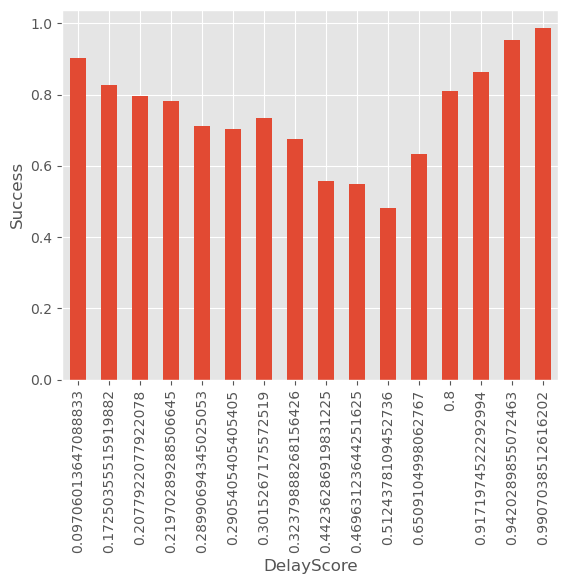

In [225]:
#Representamos mediante un plot de barras el DelayScore frente al Success
results_df_score['mean', 'Success'].plot(kind='bar', ylabel = 'Success');

*Utilizamos la librería metrics de scikit-learn para calcular el AUC y la ROC Curve*

In [226]:
metrics.roc_auc_score??

Signature:
metrics.roc_auc_score(
    y_true,
    y_score,
    *,
    average='macro',
    sample_weight=None,
    max_fpr=None,
    multi_class='raise',
    labels=None,
)
Source:   
@validate_params(
    {
        "y_true": ["array-like"],
        "y_score": ["array-like"],
        "average": [StrOptions({"micro", "macro", "samples", "weighted"}), None],
        "sample_weight": ["array-like", None],
        "max_fpr": [Interval(Real, 0.0, 1, closed="right"), None],
        "multi_class": [StrOptions({"raise", "ovr", "ovo"})],
        "labels": ["array-like", None],
    },
    prefer_skip_nested_validation=True,
)
def roc_auc_score(
    y_true,
    y_score,
    *,
    average="macro",
    sample_weight=None,
    max_fpr=None,
    multi_class="raise",
    labels=None,
):
    """Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) \
    from prediction scores.

    Note: this implementation can be used with binary, multiclass and
    multilabel classification, but s

In [227]:
# AUC
dt_AUC = metrics.roc_auc_score(
    y_test, 
    y_test_score)
print('AUC: %.3f' % dt_AUC)

AUC: 0.680


No está mal. *A partir de 0.75 es un muy buen modelo*

Dibujamos la Curva ROC

In [228]:
metrics.roc_curve??

Signature:
metrics.roc_curve(
    y_true,
    y_score,
    *,
    pos_label=None,
    sample_weight=None,
    drop_intermediate=True,
)
Source:   
@validate_params(
    {
        "y_true": ["array-like"],
        "y_score": ["array-like"],
        "pos_label": [Real, str, "boolean", None],
        "sample_weight": ["array-like", None],
        "drop_intermediate": ["boolean"],
    },
    prefer_skip_nested_validation=True,
)
def roc_curve(
    y_true, y_score, *, pos_label=None, sample_weight=None, drop_intermediate=True
):
    """Compute Receiver operating characteristic (ROC).

    Note: this implementation is restricted to the binary classification task.

    Read more in the :ref:`User Guide <roc_metrics>`.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True binary labels. If labels are not either {-1, 1} or {0, 1}, then
        pos_label should be explicitly given.

    y_score : array-like of shape (n_samples,)
        Target scores, can eith

In [229]:
# Obtenemos los arrays de los ejes y el threshold
fpr, tpr, th = metrics.roc_curve(y_test, y_test_score)

In [230]:
fpr

array([0.00000000e+00, 9.03668896e-05, 1.58142057e-04, 3.61467558e-04,
       1.49105368e-03, 1.07084764e-02, 1.26287728e-02, 1.73278511e-02,
       4.95888307e-02, 7.94550877e-02, 8.45834086e-02, 1.66636544e-01,
       1.86223568e-01, 1.96728719e-01, 3.95016266e-01, 7.25872040e-01,
       1.00000000e+00])

In [231]:
tpr

array([0.        , 0.02688394, 0.03192985, 0.03664488, 0.05434693,
       0.11274713, 0.11928199, 0.13342708, 0.22714865, 0.27942758,
       0.2862106 , 0.41268922, 0.44172388, 0.45247746, 0.63983787,
       0.89312598, 1.        ])

In [232]:
# Ha usado 17 thresholds
th

array([       inf, 0.99070385, 0.94202899, 0.91719745, 0.8       ,
       0.6509105 , 0.51243781, 0.46963124, 0.44236287, 0.32379888,
       0.30152672, 0.29054054, 0.28990694, 0.21970289, 0.20779221,
       0.17250356, 0.09706014])

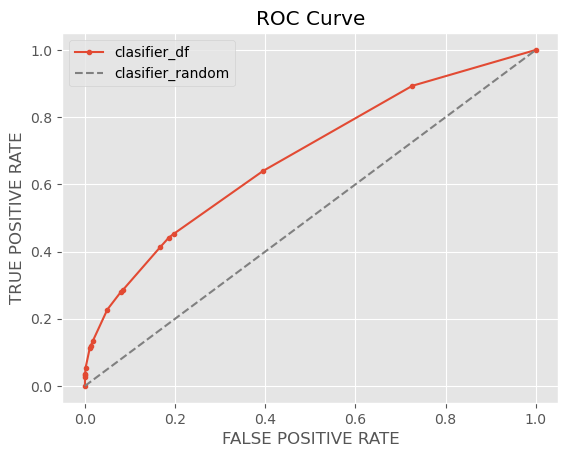

In [233]:
# Dibujo la Curva ROC
plt.clf() # función del módulo Pyplot de la librería Matplotlib que borra el contenido de la figura
plt.plot(fpr, tpr, marker = '.', label = 'clasifier_df')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label = 'clasifier_random')

# axis labels
plt.xlabel('FALSE POSITIVE RATE')
plt.ylabel('TRUE POSITIVE RATE')
plt.title('ROC Curve')

# show the legend
plt.legend()
# show the plot
plt.show()

#### 5.1.2.- Validación tomando como medida el "mes" (month)

Vemos cómo se comporta el modelo con respecto al mes, es decir vemos los aciertos (Success) por meses.

In [234]:
results_df.head()

,ARR_DEL15,DelayPrediction,Success,DelayScore
91964,1.00,1.00,1,0.80
205250,1.00,0.00,0,0.10
156190,0.00,0.00,1,0.21
117192,0.00,0.00,1,0.17
33706,0.00,0.00,1,0.21


In [235]:
# añadimos la variable YEAR
results_df['YEAR'] = X_test['YEAR']

In [236]:
# añadimos la variable MONTH
results_df['MONTH'] = X_test['MONTH']

In [237]:
results_df.pivot_table(
    index = ['YEAR', 'MONTH'], # indexo por año y por mes, para no mezclar los datos de los meses de años diferentes
    values = 'Success',
    aggfunc = [len, sum, np.mean]
)

len     sum    mean
           Success Success Success
YEAR MONTH                        
2018 1        2796    2222    0.79
     2        2694    2319    0.86
     3        2900    2402    0.83
     4        3132    2515    0.80
     5        3245    2568    0.79
     6        3356    2595    0.77
     7        3327    2365    0.71
     8        3444    2507    0.73
     9        3155    2545    0.81
     10       3300    2849    0.86
     11       3042    2499    0.82
     12       3196    2576    0.81
2019 1        3117    2532    0.81
     2        2814    2328    0.83
     3        3315    2802    0.85
     4        3065    2452    0.80
     5        3305    2716    0.82
     6        3150    2355    0.75

#### 5.1.3.- Diversas estrategias de validación variando los parámetros (**control del overfitting**)

*¿Cómo controlo el overfitting?*

* **Número de iteracciones** (profundidad del árbol): Si el algoritmo hace demasiadas preguntas, puede llegar a especificar demasiado y por lo tanto, corremos el riesgo de que memorice y haya overfitting.
* **Número mínimo de filas en cada subgrupo**: Para estar seguro de la probabilidad que se genera, las poblaciones tienen que ser significativas (hay que evitar cortes muy pequeños).

**Accuracy variando la profundidad del árbol**

Determinamos el accuracy de las particiones del train y del test variando  el max_depth entre 1 y 18

In [238]:
# Vemos donde se produce el overfitting
for i in range(1, 18):
    df_overfit = DecisionTreeClassifier(max_depth=i, random_state=42) # Instanciamos el modelo
    df_overfit.fit(X_train, y_train) # Entrenamos el modelo
    train_accuracy = df_overfit.score(X_train, y_train) # acc del train
    test_accuracy = df_overfit.score(X_test, y_test) # acc del test
    val_accuracy = df_overfit.score(val_df_X, val_df_y) # acc del val
    print('Profundidad del árbol: {}. Acc_train: {} - Acc_test: {} - Acc_val: {}'.format(i, train_accuracy, test_accuracy, val_accuracy))

Profundidad del árbol: 1. Acc_train: 0.7984835118033585 - Acc_test: 0.7979167036360088 - Acc_val: 0.8134679270112821
Profundidad del árbol: 2. Acc_train: 0.7984835118033585 - Acc_test: 0.7979167036360088 - Acc_val: 0.8134679270112821
Profundidad del árbol: 3. Acc_train: 0.8007802993429058 - Acc_test: 0.8005962415488084 - Acc_val: 0.815072780086983
Profundidad del árbol: 4. Acc_train: 0.8012822462886348 - Acc_test: 0.8011463453587209 - Acc_val: 0.814960440371684
Profundidad del árbol: 5. Acc_train: 0.8019515088829399 - Acc_test: 0.8015367416109169 - Acc_val: 0.8155381874789362
Profundidad del árbol: 6. Acc_train: 0.8038300073010465 - Acc_test: 0.8030450907671286 - Acc_val: 0.8153295565790952
Profundidad del árbol: 7. Acc_train: 0.8059899002190314 - Acc_test: 0.8033999964509432 - Acc_val: 0.8153456051098522


Profundidad del árbol: 8. Acc_train: 0.8094198710148455 - Acc_test: 0.8037903927031391 - Acc_val: 0.8148320521256279
Profundidad del árbol: 9. Acc_train: 0.8128194207836457 - Acc_test: 0.8025837133781698 - Acc_val: 0.8125692092888896
Profundidad del árbol: 10. Acc_train: 0.8170935750790946 - Acc_test: 0.8044647135023867 - Acc_val: 0.8065831073165252
Profundidad del árbol: 11. Acc_train: 0.8221586760769044 - Acc_test: 0.8036839209979948 - Acc_val: 0.8068238352778803
Profundidad del árbol: 12. Acc_train: 0.8286915916281333 - Acc_test: 0.8024240058204533 - Acc_val: 0.7969379403315626
Profundidad del árbol: 13. Acc_train: 0.8361675590167924 - Acc_test: 0.8001171188756588 - Acc_val: 0.7941454959798431
Profundidad del árbol: 14. Acc_train: 0.8454839985397907 - Acc_test: 0.798413571593349 - Acc_val: 0.7884803646226188
Profundidad del árbol: 15. Acc_train: 0.8554697006570942 - Acc_test: 0.7938530335563324 - Acc_val: 0.7811461860666656
Profundidad del árbol: 16. Acc_train: 0.8668471647602823 - 

- El accuracy del train siempre va a aumentar
- El accuracy del test va a ir aumentando hasta un punto en el que empieza a disminuir (es el momento en el que el acc del train y el acc del test se cruzan). Es ahí donde tenemos que fijarnos ya que eso significa que el modelo empieza a memorizar.

En nuestro caso se produce entre la profundidad de 8 y la de 11

En este ejemplo, podemos ver claramente como el árbol hace Overfit a medida que incrementamos la profundidad, y es por este motivo que tendremos que recurrir a mecanismos de **poda**

Apropiate fit:
- Profundidad máxima --> El máximo test_acc se produce a una profundidad de 11 --> por encima tendemos al overfit (estamos siendo poco restrictivos)
- profundidad mínima --> La diferencia entre el train_acc y el test_acc "explota" a una profundidad de 8 --> por debajo tendemos al underfit (estamos siendo muy restrictivos)

El overfit funciona mejor en el train que en el test. Con el underfit todavía tenemos margen para mejorar el modelo

*Tomamos como mejor profundidad la de 9*

**Accuracy variando el número mínimo de filas**

Determinamos el accuracy de las particiones del train y del test variando  el max_depth entre 1 y 18 y un min_samples_split de 500

In [239]:
for i in range(1, 18):
    df_overfit = DecisionTreeClassifier(max_depth=i, random_state=42, min_samples_split=500) # Instanciamos el modelo con un mínimo de 500 registros por subgrupo
    df_overfit.fit(X_train, y_train) # Entrenamos el modelo
    train_accuracy = df_overfit.score(X_train, y_train) # acc del train
    test_accuracy = df_overfit.score(X_test, y_test) # acc del test
    val_accuracy = df_overfit.score(val_df_X, val_df_y) # acc del val
    print('Profundidad del árbol: {}. Acc_train: {} - Acc_test: {} - Acc_val: {}'.format(i, train_accuracy, test_accuracy, val_accuracy))

Profundidad del árbol: 1. Acc_train: 0.7984835118033585 - Acc_test: 0.7979167036360088 - Acc_val: 0.8134679270112821
Profundidad del árbol: 2. Acc_train: 0.7984835118033585 - Acc_test: 0.7979167036360088 - Acc_val: 0.8134679270112821
Profundidad del árbol: 3. Acc_train: 0.8007802993429058 - Acc_test: 0.8005962415488084 - Acc_val: 0.815072780086983
Profundidad del árbol: 4. Acc_train: 0.8012822462886348 - Acc_test: 0.8011463453587209 - Acc_val: 0.814960440371684
Profundidad del árbol: 5. Acc_train: 0.8017765879776101 - Acc_test: 0.8013592887690096 - Acc_val: 0.8156023816019643
Profundidad del árbol: 6. Acc_train: 0.8031455341932343 - Acc_test: 0.8027256756516956 - Acc_val: 0.8154097992328803
Profundidad del árbol: 7. Acc_train: 0.8048871379897785 - Acc_test: 0.8031160719038916 - Acc_val: 0.8153937507021232
Profundidad del árbol: 8. Acc_train: 0.8067732416646386 - Acc_test: 0.8030273454829379 - Acc_val: 0.8143826932644317
Profundidad del árbol: 9. Acc_train: 0.8076706619615478 - Acc_test

#### 5.1.4.- Efectividad del mejor estimador

Determinamos el accuracy de la partición de validación utilizando el estimador con una profundidad de 11 y un mínimo de 500 registros en cada subgrupo.

In [240]:
dt = DecisionTreeClassifier(max_depth = 11, random_state = 42, min_samples_split = 500) # Instancio el modelo
dt.fit(X_train, y_train) # Lo entreno

DecisionTreeClassifier(max_depth=11, min_samples_split=500, random_state=42)

In [241]:
acc_train = dt.score(X_train, y_train) # acc del train
acc_test = dt.score(X_test, y_test) # acc del test
acc_val = dt.score(val_df_X, val_df_y) # acc del val

In [242]:
# Comparamos las métricas accuracy de las tres particiones
pd.DataFrame({'Acc_train':[acc_train], 'Acc_test':[acc_test], 'Acc_val':[acc_val]})

,Acc_train,Acc_test,Acc_val
0,0.81,0.80,0.81


- El acc del train y del test son similares por lo que el modelo no está overfiteando.
- El acc del train y de validación son iguales por lo que no hay problema de distribución de datos. 

*AUC para diferentes profundidades*

*Normalmente se mide con el AUC mejor que con el ACCURACY*

**NOTA**: *Nunca dejar más de 2 puntos de diferencia en el overfit* en el AUC ( si tengo un 0,82 en train, el de test como mínimo 0,80 ). Si esto ocurre hay que ser MÁS RESTRICTIVOS --> tenemos que dar menos profundidad y más min_sample_split
- Si es menor que 1 --> genial
- Si está entre 1 y 1,5 --> aceptable
- Si es entre 1,5 y 2 --> vale

In [243]:
# Para un min_samples_split de 2
for i in range(1, 18):
    df_overfit = DecisionTreeClassifier(max_depth=i, random_state=42, min_samples_split=2)
    df_overfit.fit(X_train, y_train) # Entrenamos el modelo
    y_train_score = pd.DataFrame(df_overfit.predict_proba(X = X_train)[:,1], index = y_train.index, columns=['DelayScore']) 
    AUC_train = metrics.roc_auc_score(y_train, y_train_score)
    y_test_score = pd.DataFrame(df_overfit.predict_proba(X = X_test)[:,1], index = y_test.index, columns=['DelayScore']) 
    AUC_test = metrics.roc_auc_score(y_test, y_test_score)
    y_val_score = pd.DataFrame(df_overfit.predict_proba(X = val_df_X)[:,1], index = val_df_y.index, columns=['DelayScore']) 
    AUC_val = metrics.roc_auc_score(val_df_y, y_val_score)
    print('Profundidad del árbol: {}. AUC_train: {} - AUC_test: {} - AUC_Val: {}'.format(i, AUC_train, AUC_test, AUC_val))

Profundidad del árbol: 1. AUC_train: 0.5602715929722952 - AUC_test: 0.5588769681522083 - AUC_Val: 0.5520433659355883
Profundidad del árbol: 2. AUC_train: 0.6310958859216068 - AUC_test: 0.6299719094198598 - AUC_Val: 0.6249751414436124
Profundidad del árbol: 3. AUC_train: 0.6623357304272056 - AUC_test: 0.6616678800926384 - AUC_Val: 0.655989065556006
Profundidad del árbol: 4. AUC_train: 0.6794643252716981 - AUC_test: 0.6795882513669739 - AUC_Val: 0.6714058443490203
Profundidad del árbol: 5. AUC_train: 0.6940423055578773 - AUC_test: 0.6936594988383418 - AUC_Val: 0.6794336923981718
Profundidad del árbol: 6. AUC_train: 0.705330023397478 - AUC_test: 0.7025370917248372 - AUC_Val: 0.6950269387666368
Profundidad del árbol: 7. AUC_train: 0.7139626157558411 - AUC_test: 0.7096309476853228 - AUC_Val: 0.6984662257292258
Profundidad del árbol: 8. AUC_train: 0.7223656300927249 - AUC_test: 0.7122414951182071 - AUC_Val: 0.7023453533851199
Profundidad del árbol: 9. AUC_train: 0.7316034794121453 - AUC_test

Podemos apreciar que el AUC de la validación llega a un máximo de 0.7023 con una profundidad de 8, y la diferencia entre el train y el test es de 1 punto. Esta sería la mejor profundidad.

In [244]:
# Para un min_samples_split de 500
for i in range(1, 18):
    df_overfit = DecisionTreeClassifier(max_depth=i, random_state=42, min_samples_split=500)
    df_overfit.fit(X_train, y_train) # Entrenamos el modelo
    y_train_score = pd.DataFrame(df_overfit.predict_proba(X = X_train)[:,1], index = y_train.index, columns=['DelayScore']) 
    AUC_train = metrics.roc_auc_score(y_train, y_train_score)
    y_test_score = pd.DataFrame(df_overfit.predict_proba(X = X_test)[:,1], index = y_test.index, columns=['DelayScore']) 
    AUC_test = metrics.roc_auc_score(y_test, y_test_score)
    y_val_score = pd.DataFrame(df_overfit.predict_proba(X = val_df_X)[:,1], index = val_df_y.index, columns=['DelayScore']) 
    AUC_val = metrics.roc_auc_score(val_df_y, y_val_score)
    print('Profundidad del árbol: {}. AUC_train: {} - AUC_test: {} - AUC_Val: {}'.format(i, AUC_train, AUC_test, AUC_val))

Profundidad del árbol: 1. AUC_train: 0.5602715929722952 - AUC_test: 0.5588769681522083 - AUC_Val: 0.5520433659355883
Profundidad del árbol: 2. AUC_train: 0.6310958859216068 - AUC_test: 0.6299719094198598 - AUC_Val: 0.6249751414436124
Profundidad del árbol: 3. AUC_train: 0.6623357304272056 - AUC_test: 0.6616678800926384 - AUC_Val: 0.655989065556006
Profundidad del árbol: 4. AUC_train: 0.6794643252716981 - AUC_test: 0.6795882513669739 - AUC_Val: 0.6714058443490203
Profundidad del árbol: 5. AUC_train: 0.694008612631609 - AUC_test: 0.6936243264661723 - AUC_Val: 0.6795082611557426
Profundidad del árbol: 6. AUC_train: 0.7050699509152232 - AUC_test: 0.702713999169991 - AUC_Val: 0.6952820204136938
Profundidad del árbol: 7. AUC_train: 0.7128195488918901 - AUC_test: 0.7097155755411059 - AUC_Val: 0.698184591372657
Profundidad del árbol: 8. AUC_train: 0.7191814846595909 - AUC_test: 0.7124659789852767 - AUC_Val: 0.7036508172872761
Profundidad del árbol: 9. AUC_train: 0.7254215142479201 - AUC_test: 

Podemos apreciar que el AUC de la validación llega a un máximo de 0.7047 con una profundidad de 9, y la diferencia entre el train y el test es de 1 punto. Esta sería la mejor profundidad.

Al meter una mayor restricción en el min_samples_split, el modelo tiene que aumentar su profundidad para conseguir el mejor AUC.

### 5.2.- k-Fold Cross Validation --> DecisionTreeClassifier

Consiste en aplicar el procedimiento de modelización del train/test split "k" veces y obtener la métrica de rendimiento promedio de los "k" modelos.

Utilizamos el módulo de model_selection de scikit-learn para aplicar el k-Fold.

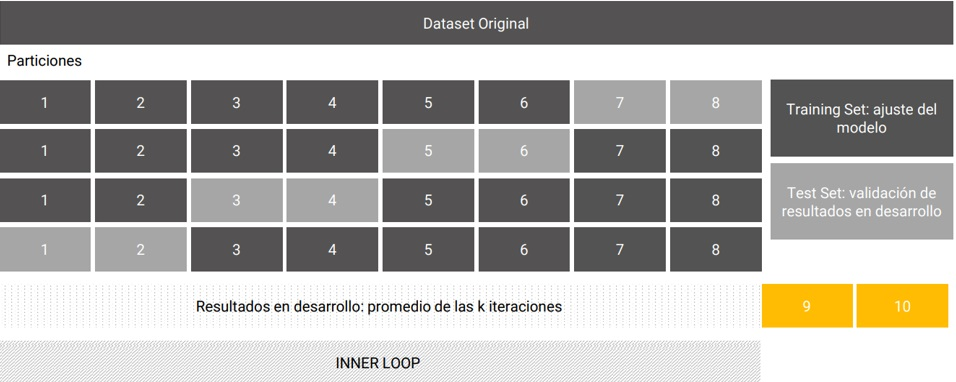

In [245]:
Image('pictures/kfold.jpg')

En cada iteracción:

- El número de muestras que tendrá el test será de:

Nº muestras develoment / k

- El número de muestras que tendrá el train:

[Nº muestras develoment * ( k - 1 )] / k

Si hacemos 10 iteracciones (k=10):

In [246]:
# Número de muestras del test
round(len(dev_df)/10, 0)

18784.0

In [247]:
# Número de muestras del train
round((len(dev_df)*9)/10, 0)

169057.0

In [248]:
model_selection??

Type:        module
String form: <module 'sklearn.model_selection' from 'c:\\Users\\jagui\\anaconda3\\lib\\site-packages\\sklearn\\model_selection\\__init__.py'>
File:        c:\users\jagui\anaconda3\lib\site-packages\sklearn\model_selection\__init__.py
Source:     
import typing

from ._plot import LearningCurveDisplay, ValidationCurveDisplay
from ._search import GridSearchCV, ParameterGrid, ParameterSampler, RandomizedSearchCV
from ._split import (
    BaseCrossValidator,
    BaseShuffleSplit,
    GroupKFold,
    GroupShuffleSplit,
    KFold,
    LeaveOneGroupOut,
    LeaveOneOut,
    LeavePGroupsOut,
    LeavePOut,
    PredefinedSplit,
    RepeatedKFold,
    RepeatedStratifiedKFold,
    ShuffleSplit,
    StratifiedGroupKFold,
    StratifiedKFold,
    StratifiedShuffleSplit,
    TimeSeriesSplit,
    check_cv,
    train_test_split,
)
from ._validation import (
    cross_val_predict,
    cross_val_score,
    cross_validate,
    learning_curve,
    permutation_test_score,
    validation

In [249]:
model_selection.KFold??

Init signature: model_selection.KFold(n_splits=5, *, shuffle=False, random_state=None)
Source:        
class KFold(_BaseKFold):
    """K-Folds cross-validator

    Provides train/test indices to split data in train/test sets. Split
    dataset into k consecutive folds (without shuffling by default).

    Each fold is then used once as a validation while the k - 1 remaining
    folds form the training set.

    Read more in the :ref:`User Guide <k_fold>`.

    Parameters
    ----------
    n_splits : int, default=5
        Number of folds. Must be at least 2.

        .. versionchanged:: 0.22
            ``n_splits`` default value changed from 3 to 5.

    shuffle : bool, default=False
        Whether to shuffle the data before splitting into batches.
        Note that the samples within each split will not be shuffled.

    random_state : int, RandomState instance or None, default=None
        When `shuffle` is True, `random_state` affects the ordering of the
        indices, which con

Vamos a hacer 10 iteracciones.
- En la primera iteracción, el primel fold se usa para el test y el resto para el train.
- En la segunda iteracción, el segundo fold se usa para el test y el resto para el train.
- Así sucesivamente hasta hacer las 10 iteracciones

In [250]:
# Defino el cross validation
kf = model_selection.KFold(
    n_splits = 10, 
    # k=10 (10 iteracciones con diferentes particiones aleatorias Train/Test)
    # Tengo 10 datasets distintos --> 10 modelos distintos
    random_state = 42, 
    # Si shuffle=True, random_state afectaría el orden de los índices, que controla la aleatoriedad de los fold 
    # Si shuffle=False, random_state no tiene efecto
    shuffle = True # mezclar los datos antes de dividirlos en batches.
)

In [251]:
# Genera los índices de las muestras del train y del test
kf.split(
    dev_df,
    y = None, # array del target
    groups = None # array de etiquetas para las muestras usadas en el split
)

<generator object _BaseKFold.split at 0x000001E2EDB8AC80>

In [252]:
# Indices del train y del train de las 10 iteracciones
for train_index, test_index in kf.split(dev_df):
    print("TRAIN:", train_index, "Samples_Train:", len(train_index), '\n')
    print("TEST:", test_index, "Samples_Test:", len(test_index))

TRAIN: [     0      1      2 ... 187836 187838 187839] Samples_Train: 169056 

TEST: [     6     12     22 ... 187835 187837 187840] Samples_Test: 18785
TRAIN: [     1      2      3 ... 187838 187839 187840] Samples_Train: 169057 

TEST: [     0     11     20 ... 187801 187810 187813] Samples_Test: 18784
TRAIN: [     0      1      2 ... 187838 187839 187840] Samples_Train: 169057 

TEST: [    24     30     42 ... 187825 187827 187829] Samples_Test: 18784
TRAIN: [     0      1      2 ... 187837 187838 187840] Samples_Train: 169057 

TEST: [     4     23     39 ... 187808 187811 187839] Samples_Test: 18784
TRAIN: [     0      1      2 ... 187838 187839 187840] Samples_Train: 169057 

TEST: [     3     21     41 ... 187822 187832 187834] Samples_Test: 18784
TRAIN: [     0      1      2 ... 187837 187839 187840] Samples_Train: 169057 

TEST: [     8     14     25 ... 187824 187830 187838] Samples_Test: 18784
TRAIN: [     0      2      3 ... 187838 187839 187840] Samples_Train: 169057 

TES

In [253]:
scores_list = [] # almaceno los acc de los modelos
for train_index, test_index in kf.split(dev_df):
    print("TRAIN:", train_index, "Samples_Train:", len(train_index)) # índices y número de filas del train
    print("TEST:", test_index, "Samples_Test:", len(test_index)) # índices y número de filas del test
    X_train, X_test = dev_df_X.iloc[train_index], dev_df_X.iloc[test_index]
    y_train, y_test = dev_df_y.iloc[train_index], dev_df_y.iloc[test_index]
    dt = DecisionTreeClassifier(max_depth = 9, random_state = 42) # Instancio el modelo
    dt.fit(X_train, y_train) # Entreno el modelo
    _score = dt.score(X_test, y_test) # Determino el accuracy del modelo
    scores_list.append(_score) # Almaceno el accuracy del modelo en una lista
    print("Acc:",_score,"\n") # Imprimo el acc del modelo
print("Accuracy de cada iteracción:")
scores_list # lista de acc de todos los modelos

TRAIN: [     0      1      2 ... 187836 187838 187839] Samples_Train: 169056
TEST: [     6     12     22 ... 187835 187837 187840] Samples_Test: 18785


Acc: 0.8011179132286399 

TRAIN: [     1      2      3 ... 187838 187839 187840] Samples_Train: 169057
TEST: [     0     11     20 ... 187801 187810 187813] Samples_Test: 18784
Acc: 0.8040353492333902 

TRAIN: [     0      1      2 ... 187838 187839 187840] Samples_Train: 169057
TEST: [    24     30     42 ... 187825 187827 187829] Samples_Test: 18784
Acc: 0.806697189097104 

TRAIN: [     0      1      2 ... 187837 187838 187840] Samples_Train: 169057
TEST: [     4     23     39 ... 187808 187811 187839] Samples_Test: 18784
Acc: 0.8045144804088586 

TRAIN: [     0      1      2 ... 187838 187839 187840] Samples_Train: 169057
TEST: [     3     21     41 ... 187822 187832 187834] Samples_Test: 18784
Acc: 0.8030238500851788 

TRAIN: [     0      1      2 ... 187837 187839 187840] Samples_Train: 169057
TEST: [     8     14     25 ... 187824 187830 187838] Samples_Test: 18784
Acc: 0.806324531516184 

TRAIN: [     0      2      3 ... 187838 187839 187840] Samples_Train: 169057
TEST: [     1 

[0.8011179132286399,
 0.8040353492333902,
 0.806697189097104,
 0.8045144804088586,
 0.8030238500851788,
 0.806324531516184,
 0.798818143100511,
 0.8040885860306644,
 0.8048871379897785,
 0.805951873935264]

In [254]:
# Determino el accuracy promedio de todos los modelos
kf_Acc = np.mean(scores_list)
kf_Acc

0.8039459054625574

In [255]:
# Desviación típica de los accuracy
kf_Acc_std = np.std(scores_list)
kf_Acc_std

0.0023158272854942007

In [256]:
print("Accuracy: %0.3f (+/- %0.3f)" % (kf_Acc, kf_Acc_std*2))

Accuracy: 0.804 (+/- 0.005)


**Otra manera de calcular el accuracy del k-Fold**

In [257]:
model_selection??

Type:        module
String form: <module 'sklearn.model_selection' from 'c:\\Users\\jagui\\anaconda3\\lib\\site-packages\\sklearn\\model_selection\\__init__.py'>
File:        c:\users\jagui\anaconda3\lib\site-packages\sklearn\model_selection\__init__.py
Source:     
import typing

from ._plot import LearningCurveDisplay, ValidationCurveDisplay
from ._search import GridSearchCV, ParameterGrid, ParameterSampler, RandomizedSearchCV
from ._split import (
    BaseCrossValidator,
    BaseShuffleSplit,
    GroupKFold,
    GroupShuffleSplit,
    KFold,
    LeaveOneGroupOut,
    LeaveOneOut,
    LeavePGroupsOut,
    LeavePOut,
    PredefinedSplit,
    RepeatedKFold,
    RepeatedStratifiedKFold,
    ShuffleSplit,
    StratifiedGroupKFold,
    StratifiedKFold,
    StratifiedShuffleSplit,
    TimeSeriesSplit,
    check_cv,
    train_test_split,
)
from ._validation import (
    cross_val_predict,
    cross_val_score,
    cross_validate,
    learning_curve,
    permutation_test_score,
    validation

In [258]:
model_selection.cross_val_score??

Signature:
model_selection.cross_val_score(
    estimator,
    X,
    y=None,
    *,
    groups=None,
    scoring=None,
    cv=None,
    n_jobs=None,
    verbose=0,
    fit_params=None,
    pre_dispatch='2*n_jobs',
    error_score=nan,
)
Source:   
def cross_val_score(
    estimator,
    X,
    y=None,
    *,
    groups=None,
    scoring=None,
    cv=None,
    n_jobs=None,
    verbose=0,
    fit_params=None,
    pre_dispatch="2*n_jobs",
    error_score=np.nan,
):
    """Evaluate a score by cross-validation.

    Read more in the :ref:`User Guide <cross_validation>`.

    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.

    X : array-like of shape (n_samples, n_features)
        The data to fit. Can be for example a list, or an array.

    y : array-like of shape (n_samples,) or (n_samples, n_outputs), \
            default=None
        The target variable to try to predict in the case of
        supervised learnin

In [259]:
dt = DecisionTreeClassifier(max_depth = 9, random_state = 42) # Instancio el modelo

In [260]:
# Array de los accuracy de las 10 iteracciones (k = 10)
scores = model_selection.cross_val_score(
    estimator = dt, # modelo
    X = dev_df_X, # atributos sin target
    y = dev_df_y, # target
    groups = None,
    scoring = None,
    cv = kf, # estrategia de validación
    n_jobs = None,
    verbose = 0,
    fit_params = None,
    pre_dispatch = '2*n_jobs',
    error_score = np.nan
)
scores

array([0.80111791, 0.80403535, 0.80669719, 0.80451448, 0.80302385,
       0.80632453, 0.79881814, 0.80408859, 0.80488714, 0.80595187])

In [261]:
# Valor promedio de los 10 accuracy
scores.mean()

0.8039459054625574

In [262]:
# Desviación típica
scores.std()

0.0023158272854942007

In [263]:
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.804 (+/- 0.005)


### 5.3.- Modelos alternativos al DecisionTree --> Métodos de Ensambles

Los métodos de ensamble consisten en combinar distintos modelos de base (estimadores de base o base learners) en un nuevo modelo (metamodelo o ensamble) que considera el resultado de todos estos para dar una predicción, esperando que la predicción combinada mejore la predicción de cada uno por separado.

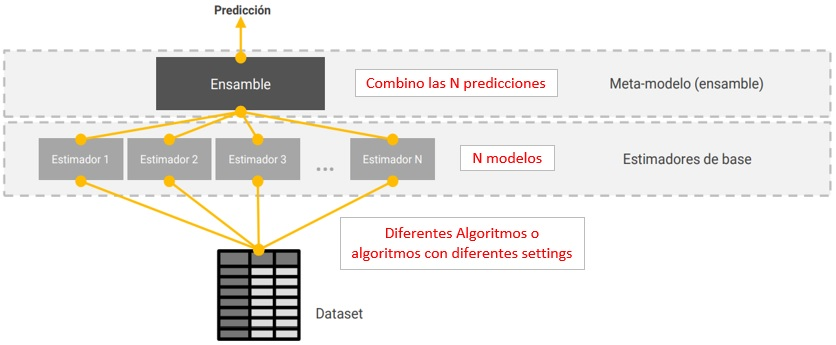

In [264]:
Image('pictures/metodo_ensambles.jpg')

Combinamos algoritmos de diferentes familias o algoritmos de una misma familia o el mismo algoritmo con diferentes settings, trabajando a la vez sobre una misma tarea. Por ejemplo, podemos usar:
- Algunos algoritmos con un poco de under-fit
- Otros con un apropiate_fit
- otros con un poco de over_fit

- *VENTAJA*: Se trata de un método mucho más preciso que el DecisionTree, sin perjudicar la capacidad de generalización.
    - Si uno coje un outlier, o tiende al overfit, o tiende al underfit, lo compensan los demás.

- *INCONVENIENTE*: Necesitan mucha capacidad de computación.

*Los estimadores de base deben cumplir*: 
- VARIEDAD: cada uno de ellos tiene que ser algo diferente.
- PRECISIÓN: cada uno de ellos tiene que ser preciso.

*Técnicas para construir el meta_modelo*:
- VOTING (ensambles por votación). Es el más sencillo. Funciona bien si tienen variedad y precisión. Se generan distintos *clasificadores o regresores* y la predicción se hace por **Hard Voting** en clasificación binaria (voto mayoritario. Dos con un 1 y uno con un 0, es un 1) o por **Average Voting** en clasificación probabilistica o regresión (voto promedio. Dos con un 1 y uno con un 0, es un 66%).
- STACKING o STACKED GENERALIZATION. Es una versión sotisficada del Voting. Se pierde explicabilidad del modelo. Casi no se utiliza por su complejidad. Los resultados de los estimadores base se utilizan como predictores para el nuevo modelo (meta-modelo), y el meta-modelo genera una nueva predicción (resultado final del ensamble).
- BAGGING (Bootstrap Agregation). Es un algoritmo de Voting que se basa en generar N estimadores o **réplicas boostrap** (en cada réplica puede haber repetición de muestras) a partir del dataset original, obteniendo una predicción para cada uno de ellos (utilizando el mismo algoritmo con la misma configuración, que sea **precisa**, en los N estimadores, por ejemplo un DeccisionTree) y finalmente aplicando la tecnica de voting (average voting) obtenemos una predicción final. Por ejemplo, si el dataset original está formado por 10 filas, podemos hacer 50 réplicas de 10 filas cada una, ligeramente distintas entre ellas (**variedad**). Un ejemplo es el **Random Forest** (aplicando la técnica del Bagging a un DecisionTree).
- BOOSTING: Parte de generar distintos clasificadores débiles (weak learners) y obtener un clasificador robusto (strong classifier). Utiliza réplicas balanceadas (con peso). Son muy costosos computacionalmente (tarda mucho en entrenarse). Partimos de una réplica del dataset original, determinamos su predicción y compruebo los aciertos en la réplica. Generamos una segunda réplica ponderando los errores y desponderando los aciertos, aplico el mismo algoritmo que antes y determino la predicción. Y así sucesivamente durante N iteracciones ( es imposible de predecir todo aciertos, siempre va a haber algún error). Finalmente hacemos un voting con las predicciones de las N iteracciones, obteniendo la predicción final. La ponderación se hace en base a una **Loss Fucction** (función de coste), de forma que el algoritmo trata de minimizarla. Los más conocidos son los **Gradient Boosting** (aplicando la técnica de un boosting a un DecisionTree). Algunos de ellos:
    - Gradient Boosting de scikit-learn --> no es el más optimo y tarda mucho.
    - XGBOST (Extreme Gradient Boosting: refuerzo de gradientes extremo). La lógica es la misma que la de sklearn, pero es mejor.
    - Light GBM. Desarrollado por Microsoft.


### **Random Forest**

Del dataset original train/test se realizan N réplicas bootstrap o estimadores, cada una de las cuales tiene el mismo número de muestras aleatorias que el dataset train/test. En cada réplica pueden haber muestras repetidas. Todas estas muestras formarán el train del estimador y el resto de muestras del dataset train/test formará el test. A cada una de las réplicas le aplicamos el DecisionTree (con la misma configuración en todas), obteniendo un conjunto de estimadores ( "bosque de árboles") con una predicción cada uno de ellos. Finalmente aplicamos la técnica del *voting* a estas predicciones (promediando los resultados o asignando la clase mayoritaria).



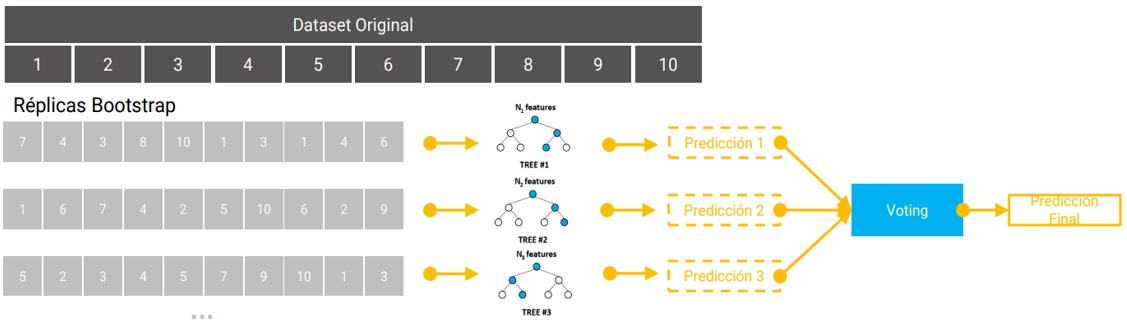

In [265]:
Image('pictures/random_forest.jpg')

- Para que sea eficaz, los árboles tienen que ser lo suficientemente distintos (*árboles no correlacionados*).
- Algoritmo muy utilizado por su *elevada precisión y simplicidad*.
- Se usa tanto en modelos predictivos como descriptivos (feature importances).
- Es muy fácil que tienda al overfiting. **Profundidad ideal de 5-6**


Usaremos *RandomForestClassifier* del método *ensemble* de sckit-learn

In [266]:
RandomForestClassifier??

Init signature:
RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)
Source:        
class RandomForestClassifier(ForestClassifier):
    """
    A random forest classifier.

    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control over-fitting.
    The sub-sample size is controlled with the `max_samples` parameter if
    `bootstrap=True` (default), otherwise the whole dataset is used to build
    each tree.

    For a comparison between tree-based ensemble models

In [267]:
# Instancio el modelo
rf = RandomForestClassifier(
    n_estimators = 3, # número de réplicas o estimadores (3 DecisinTree distintos)
    criterion = 'gini', # Por defecto
    max_depth = 5, # profundidad del árbol
    min_samples_split = 2, # Por defecto
    min_samples_leaf = 1, # Por defecto
    min_weight_fraction_leaf = 0.0, # Por defecto
    max_features = 'sqrt', # Por defecto
    max_leaf_nodes = None, # Por defecto
    min_impurity_decrease = 0.0, # Por defecto
    bootstrap = True, # Por defecto
    oob_score = False, # Por defecto
    n_jobs = None, # Por defecto
    random_state = 42,
    verbose = 0, # Por defecto
    warm_start = False, # Por defecto
    class_weight = None, # Por defecto
    ccp_alpha = 0.0, # Por defecto
    max_samples = None # Por defecto
)

In [268]:
RandomForestClassifier.fit??

Signature: RandomForestClassifier.fit(self, X, y, sample_weight=None)
Source:   
    @_fit_context(prefer_skip_nested_validation=True)
    def fit(self, X, y, sample_weight=None):
        """
        Build a forest of trees from the training set (X, y).

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The training input samples. Internally, its dtype will be converted
            to ``dtype=np.float32``. If a sparse matrix is provided, it will be
            converted into a sparse ``csc_matrix``.

        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).

        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted. Splits
            that would create child nodes with net zero or negative weight are
            igno

Para entrenar el modelo le tenemos que pasar el y_train en 1D

In [269]:
y_train.shape

(169057, 1)

In [270]:
# Me devuelve un array de 1D (vector)
np.ravel(y_train).shape

(169057,)

In [271]:
np.ravel(y_train)

array([0., 0., 0., ..., 0., 0., 0.])

In [272]:
# Entreno el modelo
rf.fit(
    X = X_train, # train sólo con atributos
    y = np.ravel(y_train) # train sólo con el target
)

RandomForestClassifier(max_depth=5, n_estimators=3, random_state=42)

Una vez que se ha entrenado el modelo, podemos acceder a la información de los estimadores (modelos base) y trabajar con ellos como si fuesen modelos independientes.

Podemos trabajar con la información que nos aportan los estimadores, para ver cuáles son los atributos más importantes, de varias formas:
1. Visualizando los diagramas de árbol y viendo cuáles son los atributos más importantes
2. Mediante el **Feature Importances**, que promedia el *Information Gain* (IG) del predictor en todo el ensamble

1. *Visualización de los árboles de los estimadores*

In [273]:
# Estimadores generados (modelos base)
tree_list = rf.estimators_
tree_list

[DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1608637542),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1273642419),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1935803228)]

In [274]:
export_graphviz??

Signature:
export_graphviz(
    decision_tree,
    out_file=None,
    *,
    max_depth=None,
    feature_names=None,
    class_names=None,
    label='all',
    filled=False,
    leaves_parallel=False,
    impurity=True,
    node_ids=False,
    proportion=False,
    rotate=False,
    rounded=False,
    special_characters=False,
    precision=3,
    fontname='helvetica',
)
Source:   
@validate_params(
    {
        "decision_tree": "no_validation",
        "out_file": [str, None, HasMethods("write")],
        "max_depth": [Interval(Integral, 0, None, closed="left"), None],
        "feature_names": ["array-like", None],
        "class_names": ["array-like", "boolean", None],
        "label": [StrOptions({"all", "root", "none"})],
        "filled": ["boolean"],
        "leaves_parallel": ["boolean"],
        "impurity": ["boolean"],
        "node_ids": ["boolean"],
        "proportion": ["boolean"],
        "rotate": ["boolean"],
        "rounded": ["boolean"],
        "special_characters"

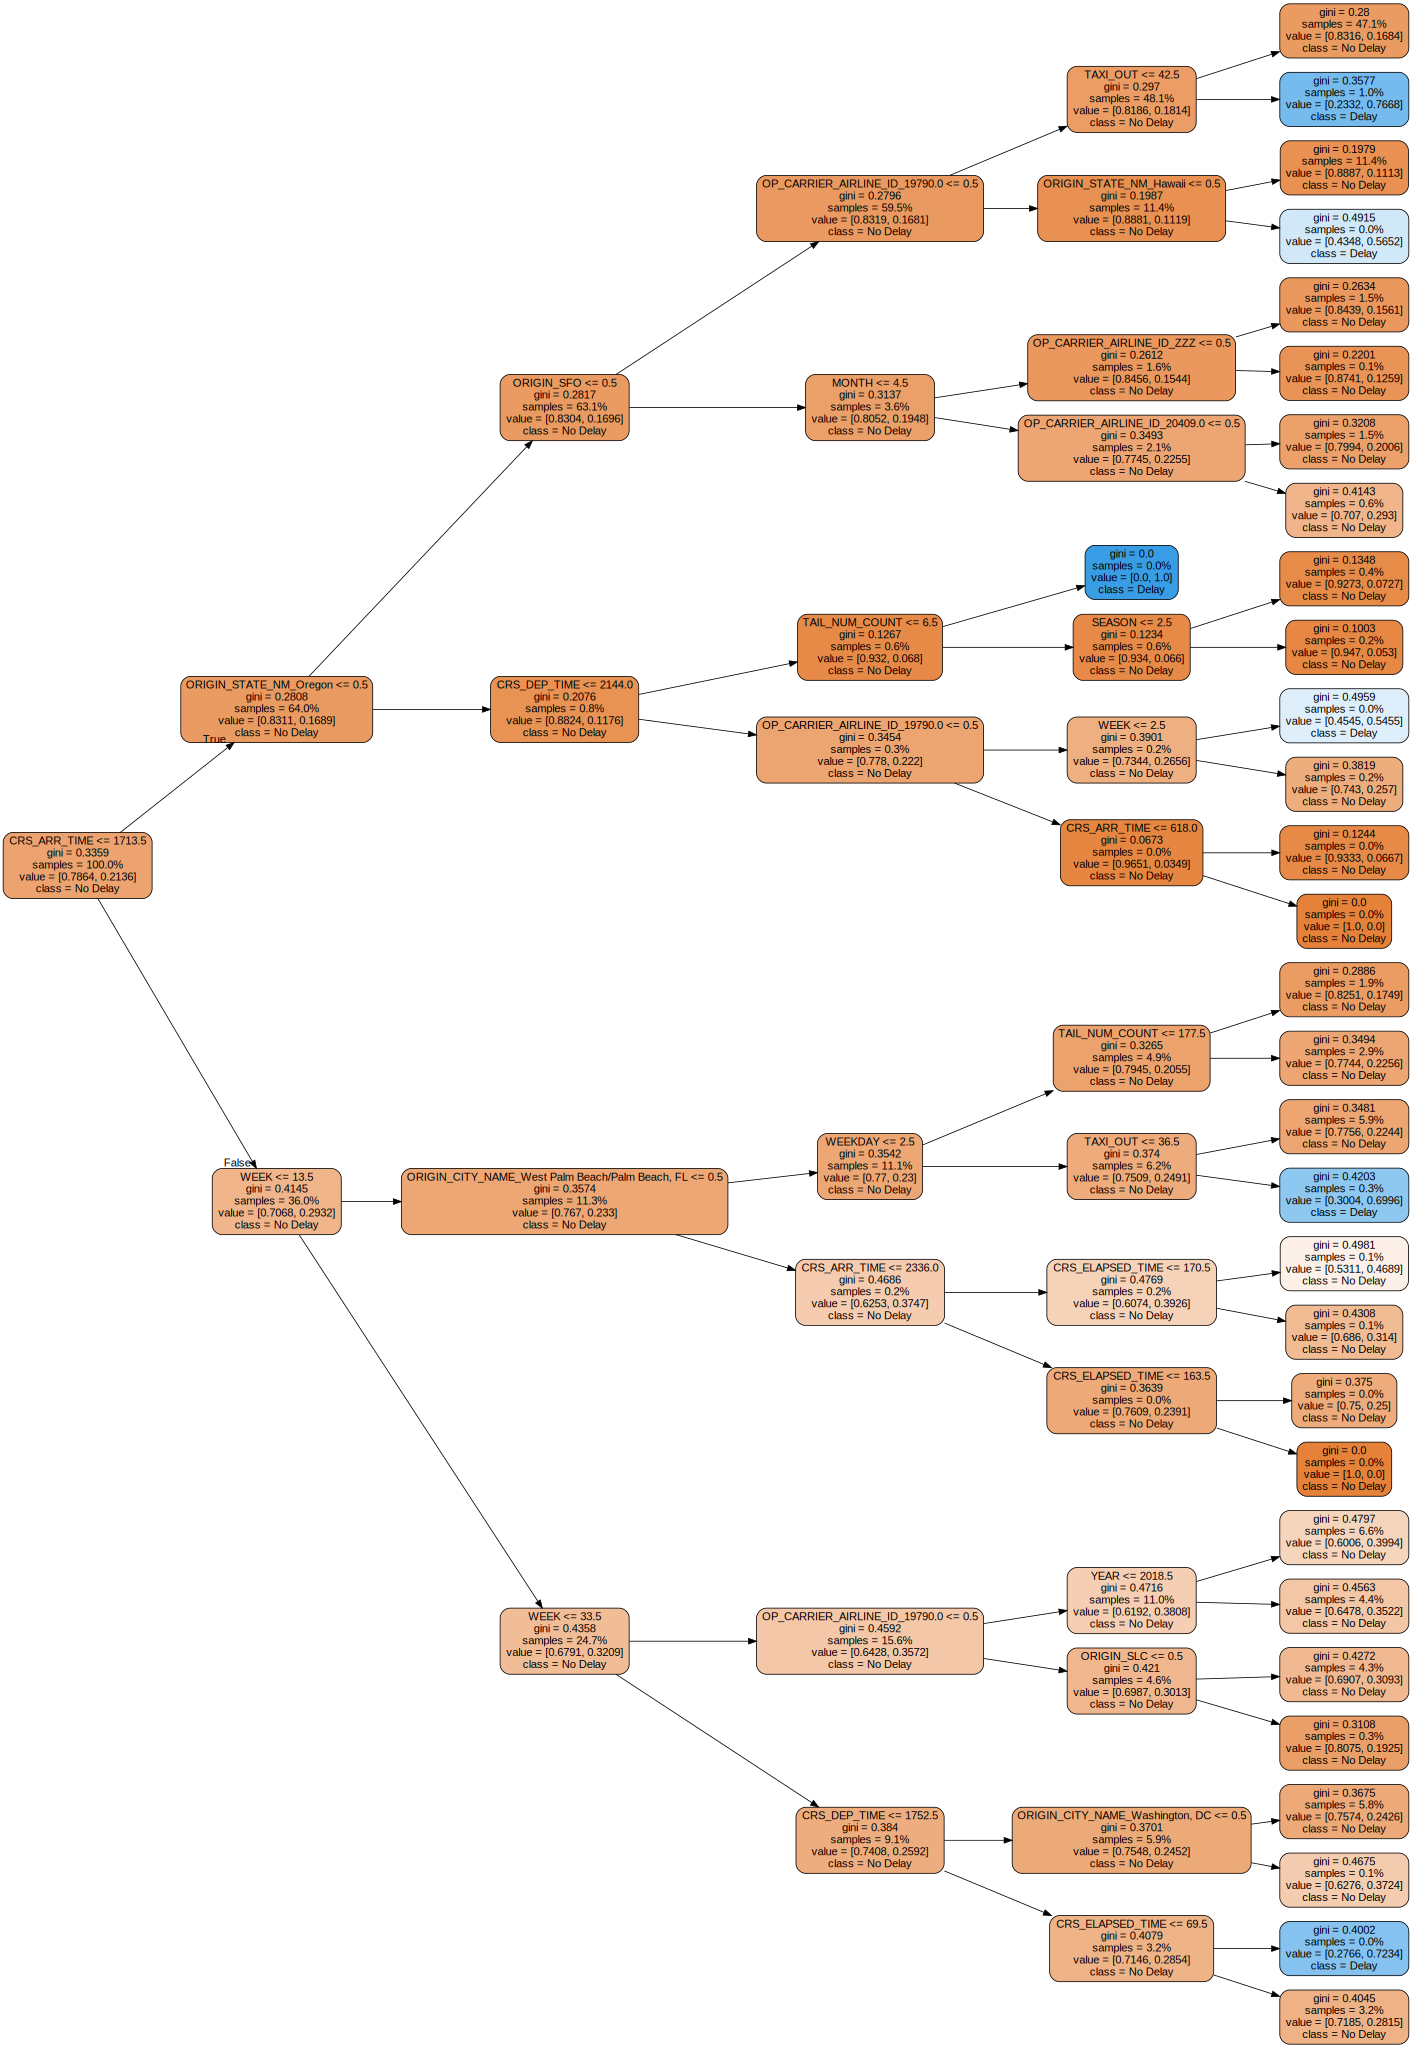

<Figure size 800x800 with 0 Axes>

In [275]:
# Visualización del estimador 1
plt.figure(figsize=(8,8))

# Exporto los datos a un formato DOT
dot_data_tree_1 = export_graphviz(
    decision_tree = tree_list[0],
    out_file = None,    
    max_depth=None,
    feature_names = X_test.columns,
    class_names = ['No Delay', 'Delay'],
    label = 'all',
    filled = True,
    leaves_parallel = False,
    impurity = True,
    node_ids = False,
    proportion = True,
    rotate = True,
    rounded = True,
    special_characters = False,
    precision = 4,
    fontname='helvetica',
)

# Grafico los estimadores
graph_tree_1 = graphviz.Source(dot_data_tree_1)
graph_tree_1

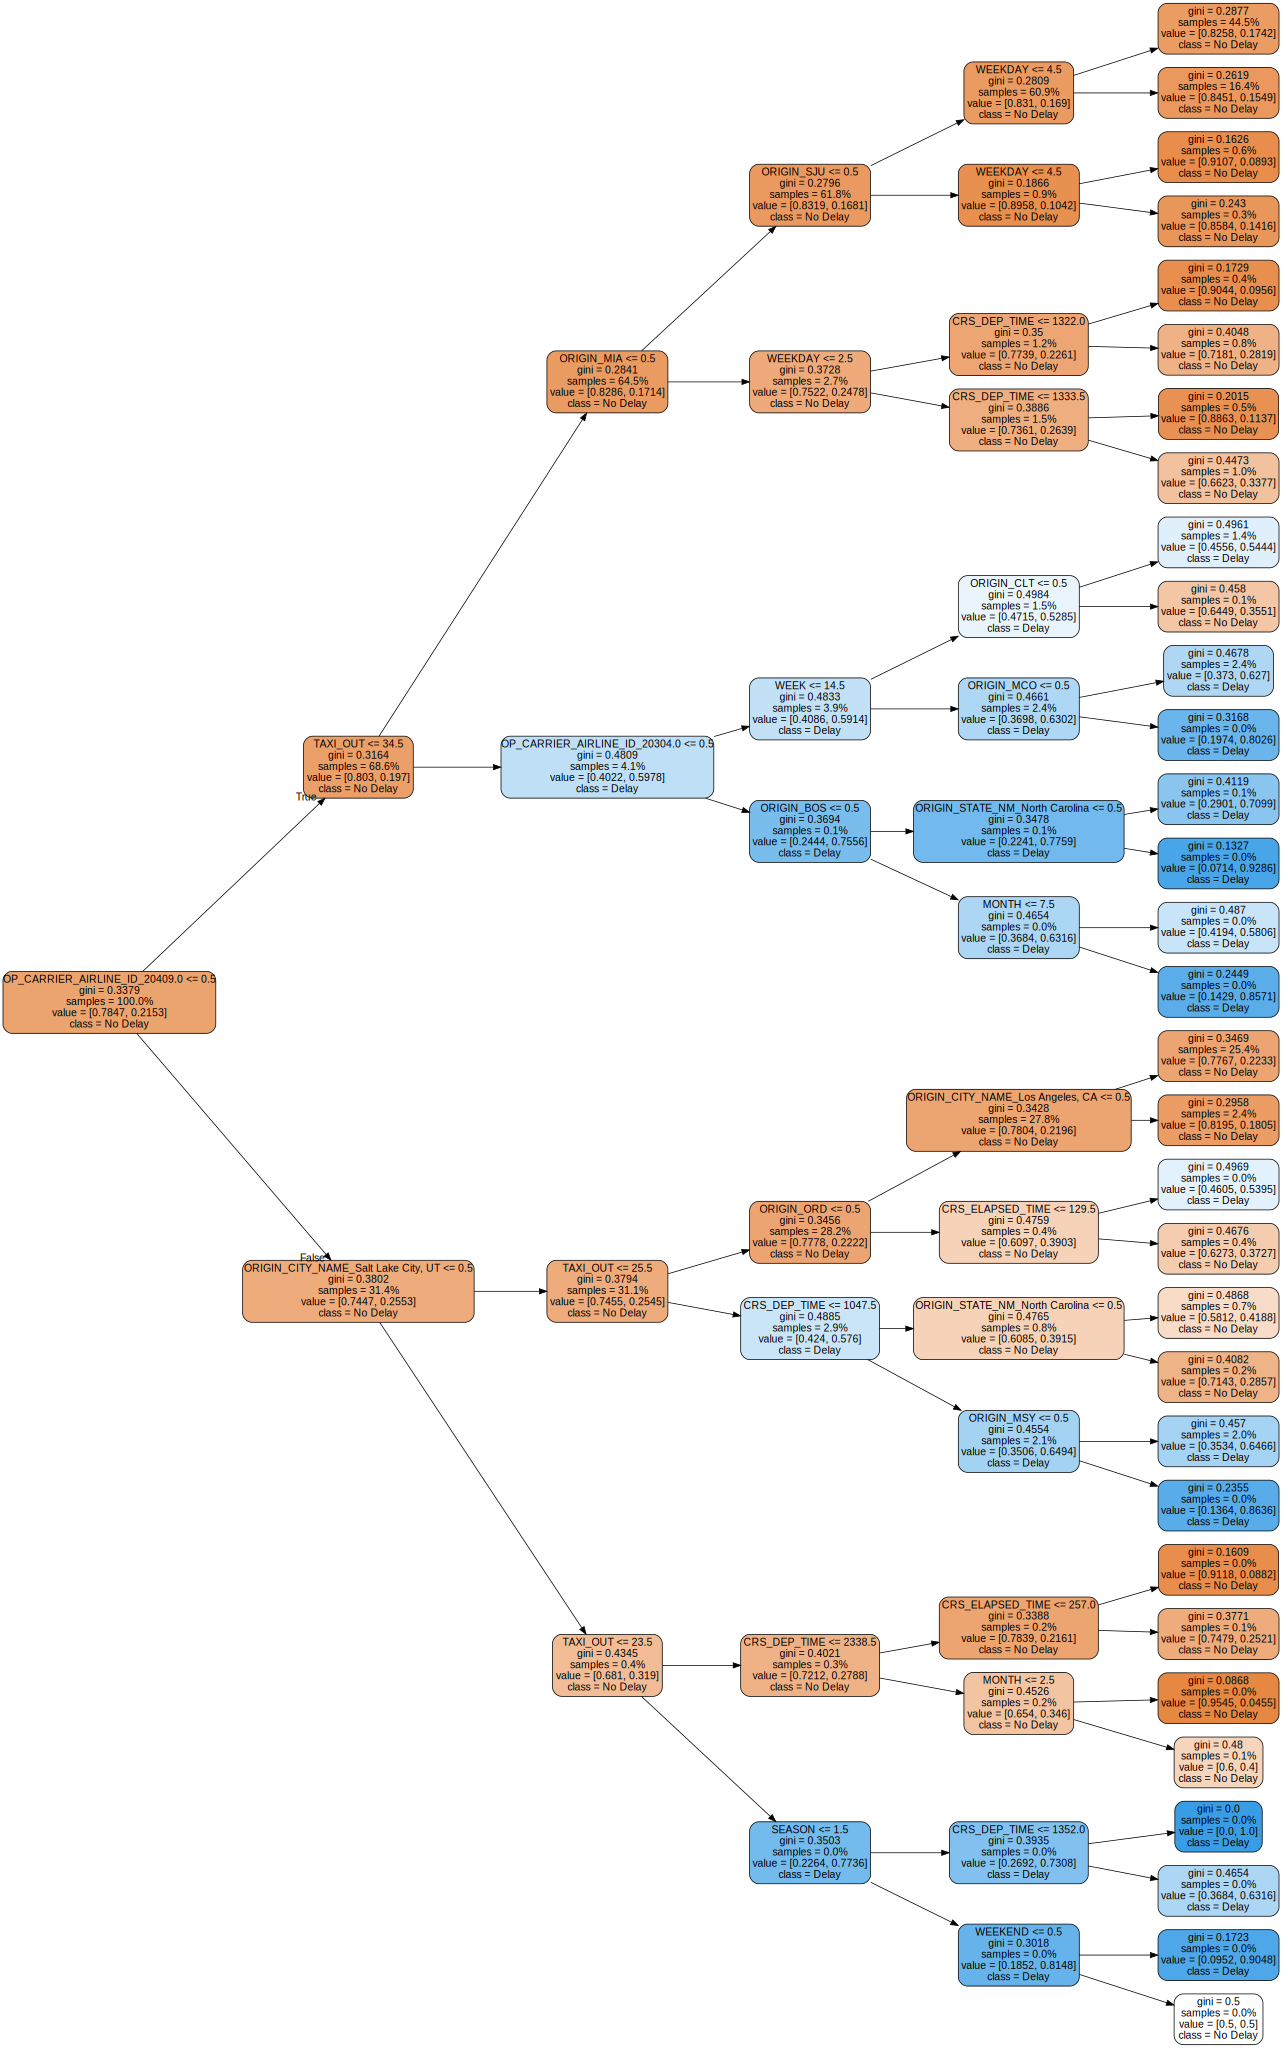

<Figure size 800x800 with 0 Axes>

In [276]:
# Visualización del estimador 2
plt.figure(figsize=(8,8))

# Exporto los datos a un formato DOT
dot_data_tree_2 = export_graphviz(
    decision_tree = tree_list[1],
    out_file = None,    
    max_depth=None,
    feature_names = X_test.columns,
    class_names = ['No Delay', 'Delay'],
    label = 'all',
    filled = True,
    leaves_parallel = False,
    impurity = True,
    node_ids = False,
    proportion = True,
    rotate = True,
    rounded = True,
    special_characters = False,
    precision = 4,
    fontname='helvetica',
)

# Grafico los estimadores
graph_tree_2 = graphviz.Source(dot_data_tree_2)
graph_tree_2

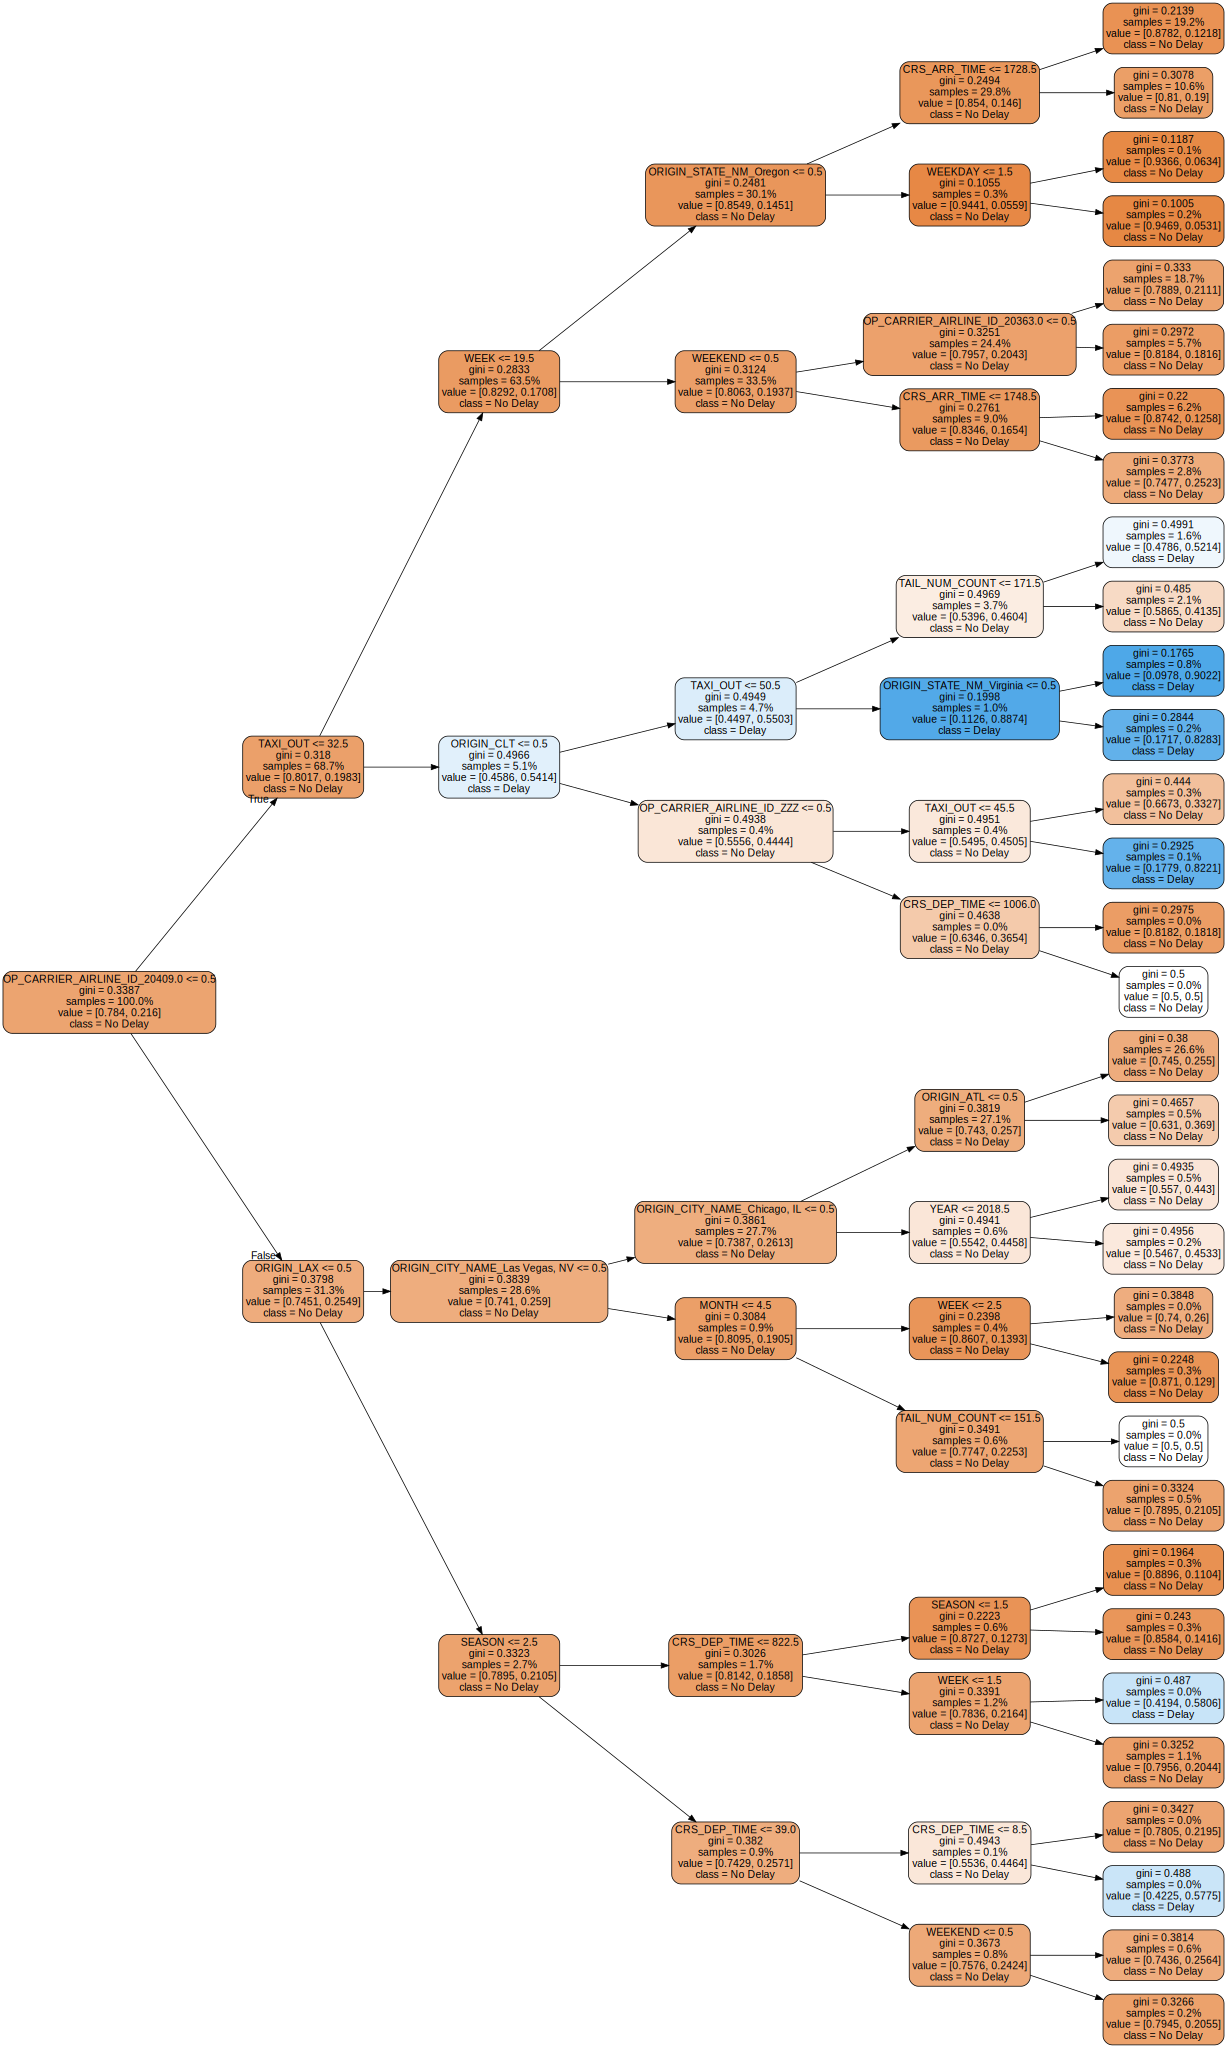

<Figure size 800x800 with 0 Axes>

In [277]:
# Visualización del estimador 3
plt.figure(figsize=(8,8))

# Exporto los datos a un formato DOT
dot_data_tree_3 = export_graphviz(
    decision_tree = tree_list[2],
    out_file = None,    
    max_depth=None,
    feature_names = X_test.columns,
    class_names = ['No Delay', 'Delay'],
    label = 'all',
    filled = True,
    leaves_parallel = False,
    impurity = True,
    node_ids = False,
    proportion = True,
    rotate = True,
    rounded = True,
    special_characters = False,
    precision = 4,
    fontname='helvetica',
)

# Grafico los estimadores
graph_tree_3 = graphviz.Source(dot_data_tree_3)
graph_tree_3

2. *Feature Importance*

Una alternativa a la visualización de importancia de atributos es el Feature Importance, que promedia el Information Gain del predictor en todo el ensamble. 

Las puntuaciones de las feature importance desempeñan un papel importante en un modelo predictivo, ya que nos dan información sobre los datos, información sobre el modelo y la base para la reducción de la dimensionalidad y la selección de características que pueden mejorar la eficiencia y la eficacia de un modelo predictivo sobre el problema:
1. *Información sobre el conjunto de datos*. Los puntajes relativos pueden resaltar qué características pueden ser más relevantes para el objetivo y, por el contrario, qué características son las menos relevantes. Esto podemos usarlo para recopilar más o diferentes datos.
2. *Innformación sobre el modelo*. Los puntajes de importancia nos proporcionan información sobre ese modelo específico y qué características son las más importantes y las menos importantes para el modelo al hacer una predicción.
3. *Mejorar el modelo predictivo*. Esto se puede lograr mediante el uso de puntuaciones de importancia para eliminar aquellas características con puntuaciones más bajas y mantener aquellas características con puntuaciones más altas. Con esto se logra una *reducción de la dimensionalidad*, que en algunos casos mejora el rendimiento del modelo.

El algoritmo encuentran un conjunto de **coeficientes para usar en la suma ponderada para hacer una predicción**. Estos coeficientes se pueden usar directamente como un tipo crudo de puntaje de feature importance.

In [278]:
# Coeficientes de los feature_importances
feature_importances = rf.feature_importances_
feature_importances

array([2.27398889e-02, 6.69160161e-01, 1.34848127e-01, 2.68759007e-03,
       1.03055085e-03, 1.87339281e-03, 2.77998698e-03, 5.32593673e-02,
       3.24476563e-03, 3.40448092e-03, 5.28790228e-03, 0.00000000e+00,
       2.17361031e-02, 0.00000000e+00, 0.00000000e+00, 1.10740547e-03,
       1.17111861e-03, 0.00000000e+00, 0.00000000e+00, 4.22089097e-02,
       0.00000000e+00, 0.00000000e+00, 8.81353759e-05, 0.00000000e+00,
       0.00000000e+00, 1.84936063e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.07649666e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.49191426e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

Vemos cuáles son los atributos más importantes, con sus coeficientes de ponderación, que usa el modelo para hacer la predicción.

In [279]:
# Atributos más importantes
rf_feature_importances = pd.Series(
    feature_importances, 
    index = X_train.columns
).sort_values(ascending = False).head(20)
rf_feature_importances

TAXI_OUT                                          0.67
CRS_ARR_TIME                                      0.13
WEEK                                              0.05
OP_CARRIER_AIRLINE_ID_20409.0                     0.04
CRS_DEP_TIME                                      0.02
OP_CARRIER_AIRLINE_ID_19790.0                     0.02
ORIGIN_CITY_NAME_Chicago, IL                      0.01
TAIL_NUM_COUNT                                    0.01
ORIGIN_MIA                                        0.00
WEEKEND                                           0.00
ORIGIN_ORD                                        0.00
WEEKDAY                                           0.00
MONTH                                             0.00
CRS_ELAPSED_TIME                                  0.00
ORIGIN_CLT                                        0.00
YEAR                                              0.00
ORIGIN_ATL                                        0.00
ORIGIN_LAX                                        0.00
ORIGIN_CIT

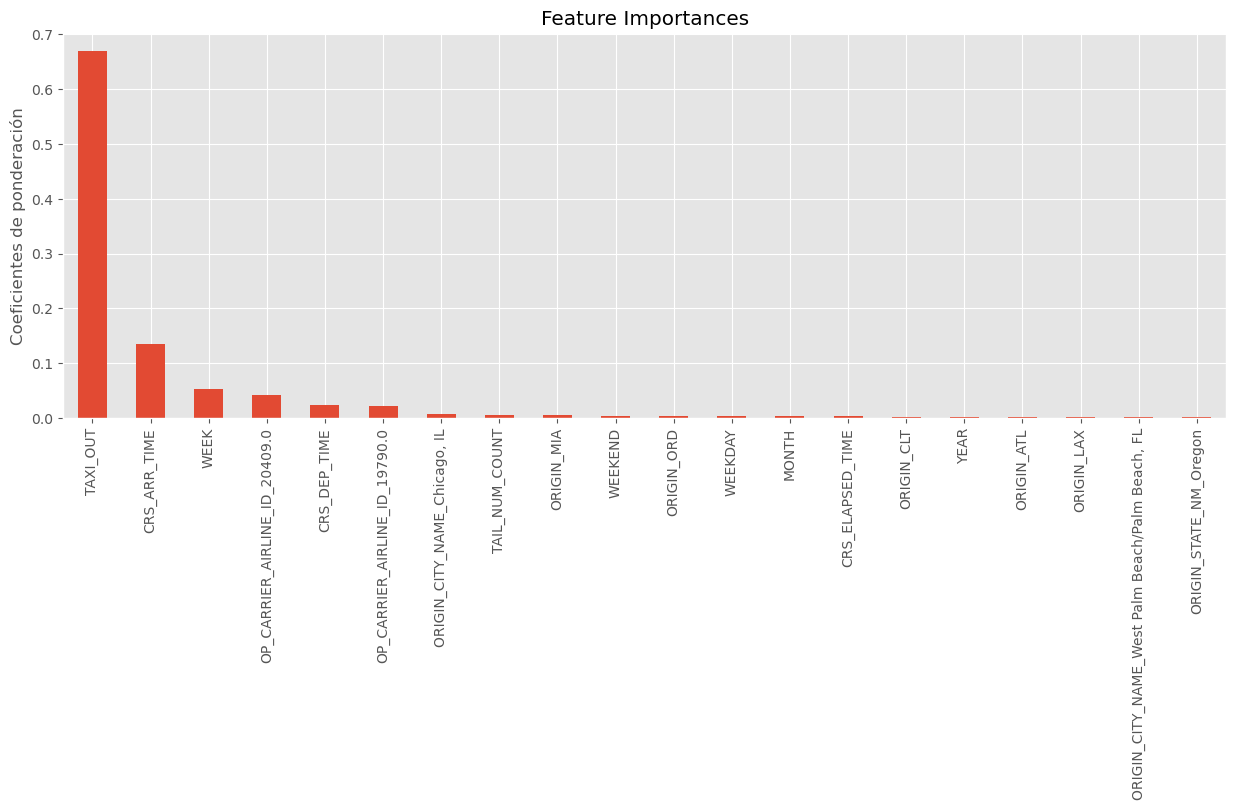

In [280]:
# Visualizamos los atributos importantes
plt.figure(figsize=(15,5))
rf_feature_importances.plot(kind = 'bar', ylabel = 'Coeficientes de ponderación')
plt.title('Feature Importances');

*Control del overfiting*

In [281]:
# Vemos donde se produce el overfitting
for i in range(1, 18):
    df_overfit = DecisionTreeClassifier(max_depth=i, random_state=42, min_samples_split = 500) # Instanciamos el modelo
    df_overfit.fit(X_train, y_train) # Entrenamos el modelo
    train_accuracy = df_overfit.score(X_train, y_train) # acc del train
    test_accuracy = df_overfit.score(X_test, y_test) # acc del test
    val_accuracy = df_overfit.score(val_df_X, val_df_y) # acc del val
    print('Profundidad del árbol: {}. Acc_train: {} - Acc_test: {} - Acc_val: {}'.format(i, train_accuracy, test_accuracy, val_accuracy))

Profundidad del árbol: 1. Acc_train: 0.794678717828898 - Acc_test: 0.7963160136286201 - Acc_val: 0.8106273370672915
Profundidad del árbol: 2. Acc_train: 0.7975889788651165 - Acc_test: 0.7982857751277683 - Acc_val: 0.8121519474892074


Profundidad del árbol: 3. Acc_train: 0.800079263207084 - Acc_test: 0.7998296422487223 - Acc_val: 0.8142703535491326
Profundidad del árbol: 4. Acc_train: 0.8019070491017822 - Acc_test: 0.801692930153322 - Acc_val: 0.8146073726950298
Profundidad del árbol: 5. Acc_train: 0.802954033255056 - Acc_test: 0.8029173764906303 - Acc_val: 0.8141419653030765
Profundidad del árbol: 6. Acc_train: 0.8037111743376494 - Acc_test: 0.8031303236797275 - Acc_val: 0.814992537433198
Profundidad del árbol: 7. Acc_train: 0.8047522433262154 - Acc_test: 0.8048339011925043 - Acc_val: 0.8156505271942354
Profundidad del árbol: 8. Acc_train: 0.8059589369265987 - Acc_test: 0.804195059625213 - Acc_val: 0.8152011683330391
Profundidad del árbol: 9. Acc_train: 0.8067574841621465 - Acc_test: 0.803822402044293 - Acc_val: 0.8121198504276933
Profundidad del árbol: 10. Acc_train: 0.8071301395387355 - Acc_test: 0.8033432708688245 - Acc_val: 0.8114618606666559
Profundidad del árbol: 11. Acc_train: 0.8083486634685343 - Acc_test: 

Los mejores resultados los obtenemos para una profundidad de 7, con un acc de 0.8156

In [282]:
for i in range(1, 18):
    df_overfit = DecisionTreeClassifier(max_depth=i, random_state=42, min_samples_split = 500) # Instanciamos el modelo
    df_overfit.fit(X_train, y_train) # Entrenamos el modelo

    y_train_score = pd.DataFrame(df_overfit.predict_proba(X = X_train)[:,1], index = y_train.index, columns = ['DelayScore_dt']) 
    y_test_score = pd.DataFrame(df_overfit.predict_proba(X = X_test)[:,1], index = y_test.index, columns = ['DelayScore_dt']) 
    y_val_score = pd.DataFrame(df_overfit.predict_proba(X = val_df_X)[:,1], index = val_df_y.index, columns = ['DelayScore_dt']) 

    AUC_train = metrics.roc_auc_score(y_train, y_train_score)
    AUC_test = metrics.roc_auc_score(y_test, y_test_score)
    AUC_val = metrics.roc_auc_score(val_df_y, y_val_score)
  
    print('Profundidad de árbol: {}. AUC_train: {} - AUC_test: {} - AUC_Val: {}'.format(i, AUC_train, AUC_test, AUC_val))

Profundidad de árbol: 1. AUC_train: 0.5689650676633251 - AUC_test: 0.5714936307962702 - AUC_Val: 0.5613778268373949
Profundidad de árbol: 2. AUC_train: 0.6343891976473679 - AUC_test: 0.6322272661575088 - AUC_Val: 0.6283040136940719
Profundidad de árbol: 3. AUC_train: 0.6596142441928153 - AUC_test: 0.6566235588017176 - AUC_Val: 0.651546789529985
Profundidad de árbol: 4. AUC_train: 0.6803856479158885 - AUC_test: 0.6762564032255843 - AUC_Val: 0.6713527909702178
Profundidad de árbol: 5. AUC_train: 0.6933739151011526 - AUC_test: 0.6868712978794775 - AUC_Val: 0.6804467244110811
Profundidad de árbol: 6. AUC_train: 0.7046516533783733 - AUC_test: 0.6981604545843509 - AUC_Val: 0.689106919687651
Profundidad de árbol: 7. AUC_train: 0.7132684825394768 - AUC_test: 0.7038337540554852 - AUC_Val: 0.6985050639964778
Profundidad de árbol: 8. AUC_train: 0.7205723982396101 - AUC_test: 0.7068106557715637 - AUC_Val: 0.7018907788043134
Profundidad de árbol: 9. AUC_train: 0.726789809517846 - AUC_test: 0.710991

Los mejores resultados los obtenemos para una profundidad de 9, con un AUC de 0.7076

In [283]:
# Para 50 estimadores y un min_samples_split de 500
for i in range(1, 20):
    df_overfit = RandomForestClassifier(n_estimators = 50, criterion = 'gini', max_depth = i, min_samples_split = 500, bootstrap = True, random_state = 42) # Instancio modelo
    df_overfit.fit(X = X_train, y = np.ravel(y_train)) # Entrenamos el modelo
    
    y_train_score = pd.DataFrame(df_overfit.predict_proba(X = X_train)[:,1], index = y_train.index, columns=['DelayScore'])
    y_test_score = pd.DataFrame(df_overfit.predict_proba(X = X_test)[:,1], index = y_test.index, columns=['DelayScore'])
    y_val_score = pd.DataFrame(df_overfit.predict_proba(X = val_df_X)[:,1], index = val_df_y.index, columns=['DelayScore'])

    AUC_train = metrics.roc_auc_score(y_train, y_train_score)     
    AUC_test = metrics.roc_auc_score(y_test, y_test_score)     
    AUC_val = metrics.roc_auc_score(val_df_y, y_val_score)

    print('Profundidad de árbol: {}. AUC_train: {} - AUC_test: {} - AUC_Val: {}'.format(i, AUC_train, AUC_test, AUC_val))

Profundidad de árbol: 1. AUC_train: 0.6610362618665112 - AUC_test: 0.6565236937825283 - AUC_Val: 0.64656752916795
Profundidad de árbol: 2. AUC_train: 0.6882921625721049 - AUC_test: 0.6823545556213607 - AUC_Val: 0.6739843998835092
Profundidad de árbol: 3. AUC_train: 0.7000451299910659 - AUC_test: 0.6925571924058996 - AUC_Val: 0.6865814890872681
Profundidad de árbol: 4. AUC_train: 0.7069687517865323 - AUC_test: 0.6979005960392394 - AUC_Val: 0.6914805538428631
Profundidad de árbol: 5. AUC_train: 0.7099386358775781 - AUC_test: 0.6990825207579774 - AUC_Val: 0.6932695283148222
Profundidad de árbol: 6. AUC_train: 0.7171897052064472 - AUC_test: 0.7068490913862915 - AUC_Val: 0.699524022902654
Profundidad de árbol: 7. AUC_train: 0.7191667917469948 - AUC_test: 0.7077834907461822 - AUC_Val: 0.7002896394435263
Profundidad de árbol: 8. AUC_train: 0.7236083613947961 - AUC_test: 0.7119053598591449 - AUC_Val: 0.7042189476954116
Profundidad de árbol: 9. AUC_train: 0.7298809253275498 - AUC_test: 0.716760

*Comparación entre el DecisionTree y el RandomForest*

Comparamos el rendimiento de ambos modelos para una profundidad de árbol de 5, un mínimo de registros por split de 500 y un random state de 42.

Como vamos a utilizar la métrica AUC/ROC Curve, necesitamos que los modelos me de la predicción en probabilidad (*predict_proba* y no *predict*).

In [284]:
dt = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=5,
    min_samples_split=500,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=42,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0,
)

dt.fit(
    X = X_test,
    y = y_test
)

DecisionTreeClassifier(max_depth=5, min_samples_split=500, random_state=42)

In [285]:
# Dataframe de los scorings de X_test
y_test_score_dt = pd.DataFrame(
    dt.predict_proba(X = X_test)[:,1], # Probabilidad de obtener 1 para cada valor del X_test 
    index = y_test.index, # Le doy el mismo índice que el de y_test
    columns = ['DelayScore_dt']) # Le doy un nombre a la columna

y_test_score_dt.head()

,DelayScore_dt
5,0.10
15,0.15
26,0.36
28,0.10
36,0.15


In [340]:
rf = RandomForestClassifier(
    n_estimators = 50, 
    max_depth = 5, 
    min_samples_split=500, 
    random_state=42
)

rf.fit(
    X_train, 
    np.ravel(y_train)
)

RandomForestClassifier(max_depth=5, min_samples_split=500, n_estimators=50,
                       random_state=42)

In [341]:
y_test_score_rf = pd.DataFrame(
    rf.predict_proba(X_test)[:,1], 
    index = y_test.index, 
    columns = ['DelayScore_rf'])
y_test_score_rf.head()

,DelayScore_rf
5,0.17
15,0.19
26,0.20
28,0.18
36,0.21


Hacemos una tabla de resultados en el que aparece el target real y las predicciones en probabilidad del DecisionTree y del RandomForest

In [349]:
results_df_= y_test.join(y_test_score_dt)
results_df_= results_df_.join(y_test_score_rf)
results_df_.sample(20)

,ARR_DEL15,DelayScore_dt,DelayScore_rf
216207,0.00,0.25,0.22
103205,0.00,0.34,0.27
233439,0.00,0.23,0.24
4820,0.00,0.16,0.20
45206,0.00,0.16,0.19
134526,0.00,0.15,0.20
88786,0.00,0.15,0.15
196809,0.00,0.22,0.22
181549,0.00,0.15,0.17
222461,1.00,0.15,0.20


Determinamos la ROC Curve y el AUC

In [343]:
# AUC del DecisionTree
print(metrics.roc_auc_score(
    results_df_['ARR_DEL15'], # y_test
    results_df_['DelayScore_dt'] # y_test_score_dt
    )
)

0.6931513901148161


In [290]:
# AUC del RandomForest
print(metrics.roc_auc_score(
    results_df_['ARR_DEL15'], # y_test
    results_df_['DelayScore_rf'] # y_test_score_rf
    )
)

0.6990825207579774


In [291]:
fpr_dt, tpr_dt, th_dt = metrics.roc_curve(results_df_['ARR_DEL15'], results_df_['DelayScore_dt'])

In [292]:
fpr_rf, tpr_rf, th_rf = metrics.roc_curve(results_df_['ARR_DEL15'], results_df_['DelayScore_rf'])

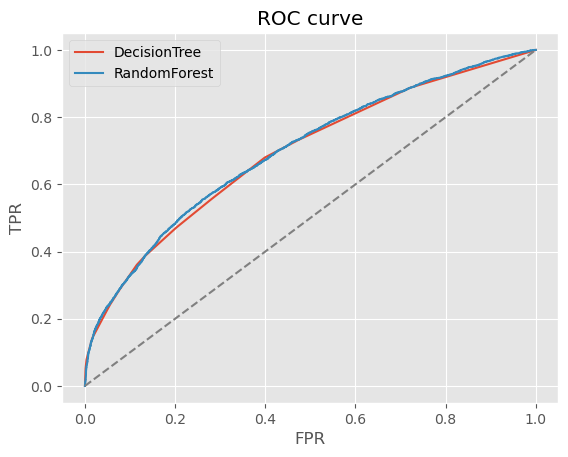

In [293]:
# Visualizamos la ROC Curve de ambos modelos
plt.clf()
plt.plot(fpr_dt, tpr_dt, label = 'DecisionTree')
plt.plot(fpr_rf, tpr_rf, label = 'RandomForest')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend()
plt.show()

*Métrica del Gain Store y Lift Store*

**Un aspecto importante a tener en cuenta es que el valor de score obtenido es un valor CONTINUO, por lo que deberemos trabajar con deciles**. 

Los deciles son números que dividen los datos en 10 grupos con la misma frecuencia. Cada grupo vendrá dado por un intervalo de probabilidades

El primer decil es el punto donde el 10% de todos los valores de datos se encuentran por debajo de él. El segundo decil es el punto donde el 20% de todos los valores de datos se encuentran por debajo de él, y así sucesivamente.

Pasos a seguir para determinar las métricas Gain y Lift:
1. Hacer un train/test split
2. Obtener las probabilidades del y_test usando el modelo considerado
3. Ordenar los datos según la probabilidad del y_test, en orden descendiente
4. Dividir los datos en 10 partes iguales (deciles) o en 100 partes iguales (percentiles)
5. Obtener el número de observaciones en cada decil
6. Obtener el número de observaciones positivas acumuladas en cada decil
7. Obtener el porcentaje de observaciones positivas acumuladas en cada decil. esto se llama **Gain Score**
8. Dividir el Gain Score por el porcentaje de datos usados cada proporcion de los 10 deciles. Por ejemplo, para el tercel decil, seria dividir su gain entre 30. Esto se llama **Cumulative Lift**

In [344]:
# Número de valores diferentes
y_test_score_rf.nunique()

DelayScore_rf    14331
dtype: int64

Para determinar los deciles usamos la función **qcut** de Pandas

In [ ]:
pd.qcut?

Lo hacemos primero con los datos reales, para luego hacer una función con todos los pasos y pasarle el X_test

In [367]:
results_df_ = results_df_.sort_values(by='DelayScore_rf', ascending = False)
# Asignamos cada probabilidad del RandomForest a un decil
results_df_['Decile'] = pd.qcut(
    x = results_df_['DelayScore_rf'], # El input debe ser de una dimensión
    q = 10, # números de deciles
    labels = None,
    retbins = False,
    precision = 3,
    duplicates = 'raise'
)
# Resumen de resultados por intervalos de probabilidad (deciles)
results_summary_table = results_df_.pivot_table(
    index = 'Decile', 
    values = target, 
    aggfunc = [len, np.sum, np.mean]
)
results_summary_table
# Renombramos las columnas
results_summary_table.columns = ['Nº Vuelos', 'Nº Vuelos con Retraso', 'Accuracy']
results_summary_table['Accuracy'] = results_summary_table['Accuracy']*100
results_summary_table['Porcentaje Nº Vuelos'] = (results_summary_table['Nº Vuelos'] / results_summary_table['Nº Vuelos'].sum())*100
results_summary_table['Porcentaje Nº Vuelos con Retraso'] = (results_summary_table['Nº Vuelos con Retraso'] / results_summary_table['Nº Vuelos con Retraso'].sum())*100
results_summary_table['Nº Vuelos Acumulado'] = results_summary_table['Nº Vuelos'].cumsum()
results_summary_table['Nº Vuelos con Retraso Acumulados'] = results_summary_table['Nº Vuelos con Retraso'].cumsum()
results_summary_table['Porcentaje Nº Vuelos Acumulado'] = results_summary_table['Porcentaje Nº Vuelos'].cumsum()
results_summary_table['Porcentaje Nº Vuelos con Retraso Acumulado'] = results_summary_table['Porcentaje Nº Vuelos con Retraso'].cumsum()
results_summary_table['Cumulative Lift'] = results_summary_table['Porcentaje Nº Vuelos con Retraso Acumulado']/results_summary_table['Porcentaje Nº Vuelos Acumulado']
results_summary_table

,Nº Vuelos,Nº Vuelos con Retraso,Accuracy,Porcentaje Nº Vuelos,Porcentaje Nº Vuelos con Retraso,Nº Vuelos Acumulado,Nº Vuelos con Retraso Acumulados,Porcentaje Nº Vuelos Acumulado,Porcentaje Nº Vuelos con Retraso Acumulado,Cumulative Lift
Decile,,,,,,,,,,
"(0.124, 0.173]",1879,156.00,8.30,10.00,3.90,1879,156.00,10.00,3.90,0.39
"(0.173, 0.184]",1878,191.00,10.17,10.00,4.77,3757,347.00,20.00,8.66,0.43
"(0.184, 0.19]",1878,235.00,12.51,10.00,5.87,5635,582.00,30.00,14.53,0.48
"(0.19, 0.198]",1879,265.00,14.10,10.00,6.62,7514,847.00,40.00,21.15,0.53
"(0.198, 0.205]",1878,313.00,16.67,10.00,7.82,9392,"1,160.00",50.00,28.96,0.58
"(0.205, 0.214]",1878,350.00,18.64,10.00,8.74,11270,"1,510.00",60.00,37.70,0.63
"(0.214, 0.226]",1879,376.00,20.01,10.00,9.39,13149,"1,886.00",70.00,47.09,0.67
"(0.226, 0.241]",1878,500.00,26.62,10.00,12.48,15027,"2,386.00",80.00,59.58,0.74
"(0.241, 0.266]",1878,610.00,32.48,10.00,15.23,16905,"2,996.00",90.00,74.81,0.83


Definimos una función que genere esta tabla reumen de resultados (tabla de ganancias) para un caso genérico. En donde:
- Cases --> Nº Vuelos
- Responses --> Nº Vuelos con Retraso
- Pct. Cases --> Porcentaje Nº Vuelos
- Pct. Responses --> Porcentaje Nº Vuelos con Retraso
- Cum. Case --> Nº Vuelos Acumulado
- Cum. Responses --> Nº Vuelos con Retraso Acumulados
- Cum. Pct. Cases --> Porcentaje Nº Vuelos Acumulado
- Cum. Pct. Responses --> Porcentaje Nº Vuelos con Retraso Acumulado


In [377]:
# Defino una función que haga todos los pasos anteriores
def get_gain_table(model, X_test, y_test):
    y_score = pd.DataFrame(model.predict_proba(X_test)[:,1], index=y_test.index, columns=['Score'])
    results_df = y_test.join(y_score)
    results_df = results_df.sort_values(by='Score', ascending = False)
    results_df['Decile'] = pd.qcut(results_df['Score'], q=10)
    results_summary_table = results_df.pivot_table(index='Decile', values=y_test.columns, aggfunc=[len, np.sum, np.mean]).sort_index(ascending=False)
    results_summary_table.columns = ['Cases', 'Responses', 'Accuracy']
    results_summary_table['Accuracy'] = results_summary_table['Accuracy']*100
    results_summary_table['Pct. Cases'] = (results_summary_table['Cases'] / results_summary_table['Cases'].sum())*100
    results_summary_table['Pct. Responses'] = (results_summary_table['Responses'] / results_summary_table['Responses'].sum())*100
    results_summary_table['Cum. Cases'] = results_summary_table['Cases'].cumsum()
    results_summary_table['Cum. Responses'] = results_summary_table['Responses'].cumsum()
    results_summary_table['Cum. Pct. Cases'] = results_summary_table['Pct. Cases'].cumsum()
    results_summary_table['Cum. Pct. Responses'] = results_summary_table['Pct. Responses'].cumsum()
    results_summary_table['Cumulative Lift'] = results_summary_table['Cum. Pct. Responses']/results_summary_table['Cum. Pct. Cases']

    return results_summary_table

In [378]:
# Tabla de ganancias del RandomForest
rf_results_summary_table = get_gain_table(rf, X_test, y_test)
rf_results_summary_table

,Cases,Responses,Accuracy,Pct. Cases,Pct. Responses,Cum. Cases,Cum. Responses,Cum. Pct. Cases,Cum. Pct. Responses,Cumulative Lift
Decile,,,,,,,,,,
"(0.266, 0.455]",1879,"1,009.00",53.70,10.00,25.19,1879,"1,009.00",10.00,25.19,2.52
"(0.241, 0.266]",1878,610.00,32.48,10.00,15.23,3757,"1,619.00",20.00,40.42,2.02
"(0.226, 0.241]",1878,500.00,26.62,10.00,12.48,5635,"2,119.00",30.00,52.91,1.76
"(0.214, 0.226]",1879,376.00,20.01,10.00,9.39,7514,"2,495.00",40.00,62.30,1.56
"(0.205, 0.214]",1878,350.00,18.64,10.00,8.74,9392,"2,845.00",50.00,71.04,1.42
"(0.198, 0.205]",1878,313.00,16.67,10.00,7.82,11270,"3,158.00",60.00,78.85,1.31
"(0.19, 0.198]",1879,265.00,14.10,10.00,6.62,13149,"3,423.00",70.00,85.47,1.22
"(0.184, 0.19]",1878,235.00,12.51,10.00,5.87,15027,"3,658.00",80.00,91.34,1.14
"(0.173, 0.184]",1878,191.00,10.17,10.00,4.77,16905,"3,849.00",90.00,96.10,1.07


In [384]:
rf_results_summary_table.index = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
rf_results_summary_table

,Cases,Responses,Accuracy,Pct. Cases,Pct. Responses,Cum. Cases,Cum. Responses,Cum. Pct. Cases,Cum. Pct. Responses,Cumulative Lift
10,1879,"1,009.00",53.70,10.00,25.19,1879,"1,009.00",10.00,25.19,2.52
20,1878,610.00,32.48,10.00,15.23,3757,"1,619.00",20.00,40.42,2.02
30,1878,500.00,26.62,10.00,12.48,5635,"2,119.00",30.00,52.91,1.76
40,1879,376.00,20.01,10.00,9.39,7514,"2,495.00",40.00,62.30,1.56
50,1878,350.00,18.64,10.00,8.74,9392,"2,845.00",50.00,71.04,1.42
60,1878,313.00,16.67,10.00,7.82,11270,"3,158.00",60.00,78.85,1.31
70,1879,265.00,14.10,10.00,6.62,13149,"3,423.00",70.00,85.47,1.22
80,1878,235.00,12.51,10.00,5.87,15027,"3,658.00",80.00,91.34,1.14
90,1878,191.00,10.17,10.00,4.77,16905,"3,849.00",90.00,96.10,1.07
100,1879,156.00,8.30,10.00,3.90,18784,"4,005.00",100.00,100.00,1.00


El *Gain Store* para un decil determinado, es la relación entre el número acumulado de responses hasta ese decil y el número total de responses que hay en todo el conjunto de datos. Interpretación:
- El 78,85% de los retrasos cubiertos en el 60% superior significa que podemos identificar el 78,85% de los vuelos que probablemente se retrasarán teniendo en cuenta el 60% del total de vuelos.
- Si fuesen compras ... Podemos identificar y dirigirnos al 78,85% de los clientes que probablemente comprarán un producto, enviando un correo electrónico al 20% del total de clientes.


El *lift* mide cuánto mejor se puede hacer con un modelo en comparación sin un modelo (o modelo tonto). Es la relación entre el % de gancia y el porcentaje de expectativa aleatoria en un nivel de decil dado. La expectativa aleatoria en el x-esimo decil es x%. Interpretación:
- El cum lift de 1,42 para los 6 deciles superiores significa que al seleccionar de forma aleatoria el 60% de los vuelos según el modelo, se puede esperar que se encuentren 1,42 veces el total de vuelos con retraso que si lo hiciesemos sin modelo.

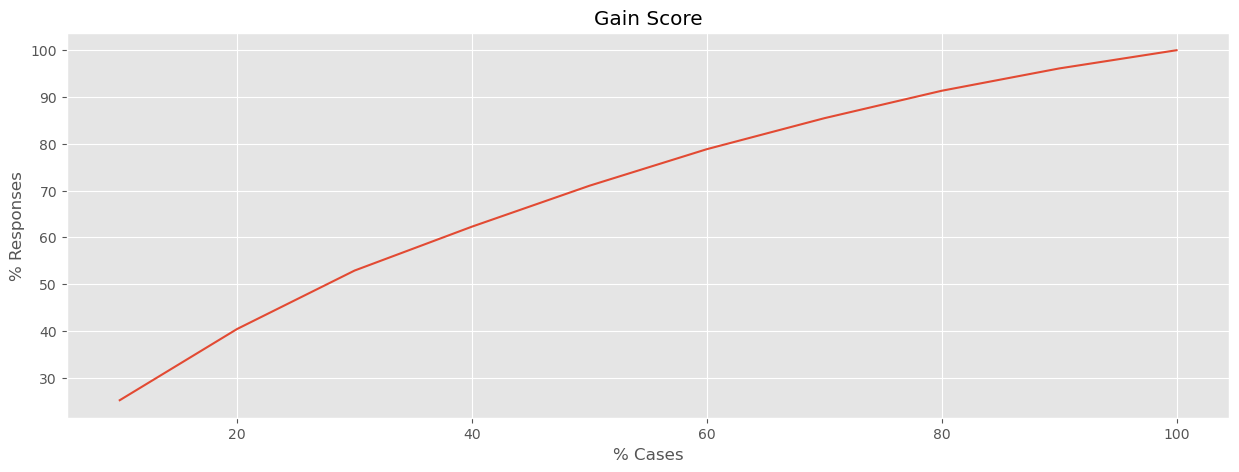

In [388]:
# Visualizamos la Gain Score
plt.figure(figsize=(15,5))
rf_results_summary_table['Cum. Pct. Responses'].plot(kind = 'line', xlabel = '% Cases', ylabel = '% Responses')
plt.title('Gain Score');

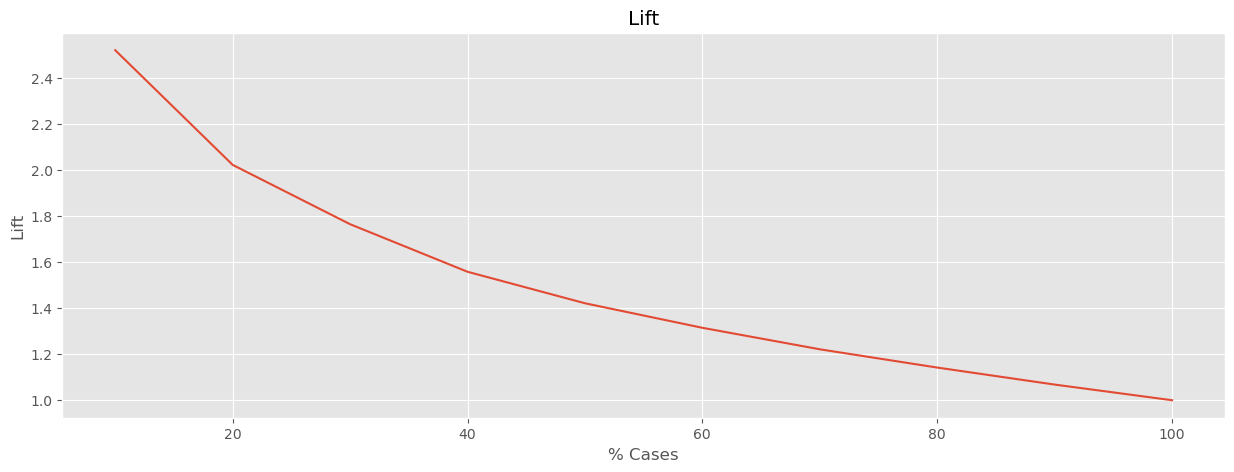

In [389]:
# Visualizamos la Lift Score
plt.figure(figsize=(15,5))
rf_results_summary_table['Cumulative Lift'].plot(kind = 'line', xlabel = '% Cases', ylabel = 'Lift')
plt.title('Lift');

### **Gradient Boosting**

El Gradient Boosting es un algoritmo basado en el ensamble de modelos debiles para obtener un modelo más robusto, de forma que cada modelo se genera sobre el anterior con la intención de correjir el error producido por este. Para ello, se utiliza un vector de pesos asociados a las distintas observaciones del dataset, inicializado con pesos uniformes (**inicialmente tenemos una réplica del dataset balanceada**).

A medida que vamos avanzando, en cada iteracción, **se incrementan los pesos de los errores** (observaciones mal clasificadas) para que tengan mayor relevancia en la construcción de futuros modelos, y **se disminuyen los pesos de los aciertos** (observaciones bien clasificadas).

Finalmente se combinan las predicciones de todos los modelos generados, mediante **Voting**.

En el GBM (Gradient Boost Machine) habitualmente se utilizan como *estimadores base* los *DecisionTree* y como *algoritmo de optimización* (para mejorar la precisión) el método *Gradient Descent* (Descenso del Gradiente).

Implementaciones más usadas:
- xGBoost (extreme Gradient Boosting). La lógica es la misma que el Gradient Boosting de sklearn, pero lo mejora.
- LightGBM. Desarrollado por Microsoft.

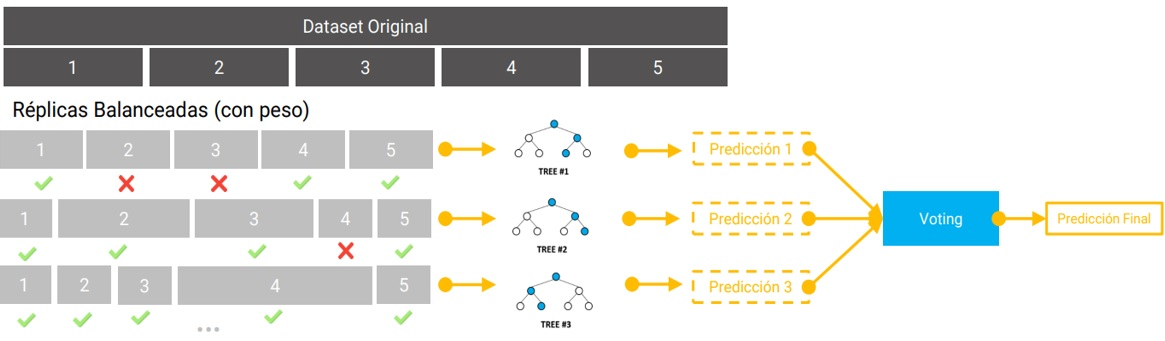

In [305]:
Image('pictures/gradient_boosting.jpg')

*¿Cómo ajustar los pesos de forma óptima?*

Para ellos se utiliza una función llamada *Loss Function* (función de coste) como el *logloss* y se utiliza un *algoritmo de optimización* llamado *Gradient Descent* (descenso del gradiente), que consiste en hacer derivadas parciales de la función de coste para decidir la dirección de avance.


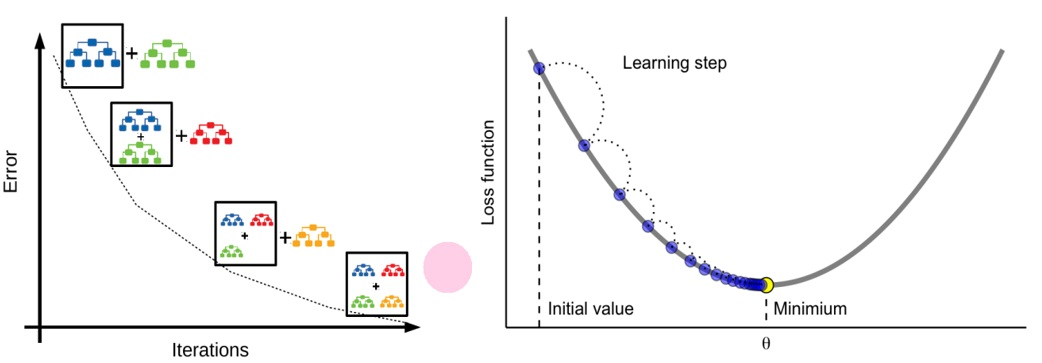

In [306]:
Image('pictures/loss_function_GBM.jpg')

Para decidir el número de iteracciones que hay que hacer, se suele buscar el cambio de pendiente más brusco en la Lost Function, para evitar mínimos relativos.

Utilizamos el Gradient Boosting de sklearn

In [ ]:
GradientBoostingClassifier??

In [308]:
# Instancio el modelo
gb = GradientBoostingClassifier(
    loss = 'log_loss', # Loss Function que utilizamos (es una buena opción para clasificación con salidad probabilísticas)
    learning_rate = 0.1, # parámetro que podemos variar para mejorar el rendimiento (son bajos)
    n_estimators = 100,
    subsample = 1.0,
    criterion = 'friedman_mse',
    min_samples_split = 500,
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0,
    max_depth = 5,
    min_impurity_decrease = 0.0,
    init = None,
    random_state = 42,
    max_features = None,
    verbose = 0,
    max_leaf_nodes = None,
    warm_start = False,
    validation_fraction = 0.1,
    n_iter_no_change = None,
    tol = 0.0001,
    ccp_alpha = 0.0
)
gb

# Entreno el modelo
gb.fit(
    X = X_train,
    y = np.ravel(y_train) # Tengo que dárselo en 1D
)

GradientBoostingClassifier(max_depth=5, min_samples_split=500, random_state=42)

In [309]:
# Predicción de probabilidades
y_test_score_gb = pd.DataFrame(
    gb.predict_proba(X_test)[:,1], 
    index = y_test.index, 
    columns = ['DelayScore_gb'])
y_test_score_gb

,DelayScore_gb
5,0.09
15,0.16
26,0.34
28,0.19
36,0.13
...,...
250090,0.16
250100,0.14
250110,0.04
250123,0.57


In [310]:
y_test_score_gb.nunique()

DelayScore_gb    18695
dtype: int64

In [316]:
# Tabla de resultados
results_gb = y_test.join(y_test_score_gb)
results_gb

,ARR_DEL15,DelayScore_gb
5,0.00,0.09
15,0.00,0.16
26,0.00,0.34
28,1.00,0.19
36,1.00,0.13
...,...,...
250090,0.00,0.16
250100,0.00,0.14
250110,0.00,0.04
250123,0.00,0.57


***Validación con la métrica AUC/ROC Curve***

In [312]:
# AUC
print(metrics.roc_auc_score(
    y_test, 
    y_test_score_gb))

0.7602153458795626


***Tabla de ganancias***

In [375]:
gb_results_summary_table = get_gain_table(
    model = gb, 
    X_test = X_test, 
    y_test = y_test
)
gb_results_summary_table

,Cases,Responses,Accuracy,Pct. Cases,Pct. Responses,Cum. Cases,Cum. Responses,Cum. Pct. Cases,Cum. Pct. Responses,Cumulative Lift
Decile,,,,,,,,,,
"(0.416, 0.989]",1879,"1,233.00",65.62,10.00,30.79,1879,"1,233.00",10.00,30.79,3.08
"(0.294, 0.416]",1878,675.00,35.94,10.00,16.85,3757,"1,908.00",20.00,47.64,2.38
"(0.235, 0.294]",1878,499.00,26.57,10.00,12.46,5635,"2,407.00",30.00,60.10,2.00
"(0.197, 0.235]",1879,392.00,20.86,10.00,9.79,7514,"2,799.00",40.00,69.89,1.75
"(0.166, 0.197]",1878,302.00,16.08,10.00,7.54,9392,"3,101.00",50.00,77.43,1.55
"(0.141, 0.166]",1878,270.00,14.38,10.00,6.74,11270,"3,371.00",60.00,84.17,1.40
"(0.119, 0.141]",1879,217.00,11.55,10.00,5.42,13149,"3,588.00",70.00,89.59,1.28
"(0.0982, 0.119]",1878,179.00,9.53,10.00,4.47,15027,"3,767.00",80.00,94.06,1.18
"(0.078, 0.0982]",1878,144.00,7.67,10.00,3.60,16905,"3,911.00",90.00,97.65,1.09


***Feature Importances***

In [314]:
# Atributos más importantes
gb_feature_importances = pd.Series(
    gb.feature_importances_, 
    index = X_train.columns
).sort_values(ascending = False).head(20)
gb_feature_importances

TAXI_OUT                         0.43
WEEK                             0.16
CRS_DEP_TIME                     0.10
CRS_ARR_TIME                     0.08
WEEKDAY                          0.06
OP_CARRIER_AIRLINE_ID_20409.0    0.04
CRS_ELAPSED_TIME                 0.03
YEAR                             0.02
MONTH                            0.01
WEEKEND                          0.01
ORIGIN_STATE_NM_Florida          0.01
OP_CARRIER_AIRLINE_ID_20363.0    0.01
OP_CARRIER_AIRLINE_ID_19790.0    0.01
TAIL_NUM_COUNT                   0.00
ORIGIN_STATE_NM_Virginia         0.00
ORIGIN_DCA                       0.00
ORIGIN_CLT                       0.00
ORIGIN_CITY_NAME_Charlotte, NC   0.00
ORIGIN_STATE_NM_Texas            0.00
ORIGIN_CITY_NAME_San Jose, CA    0.00
dtype: float64

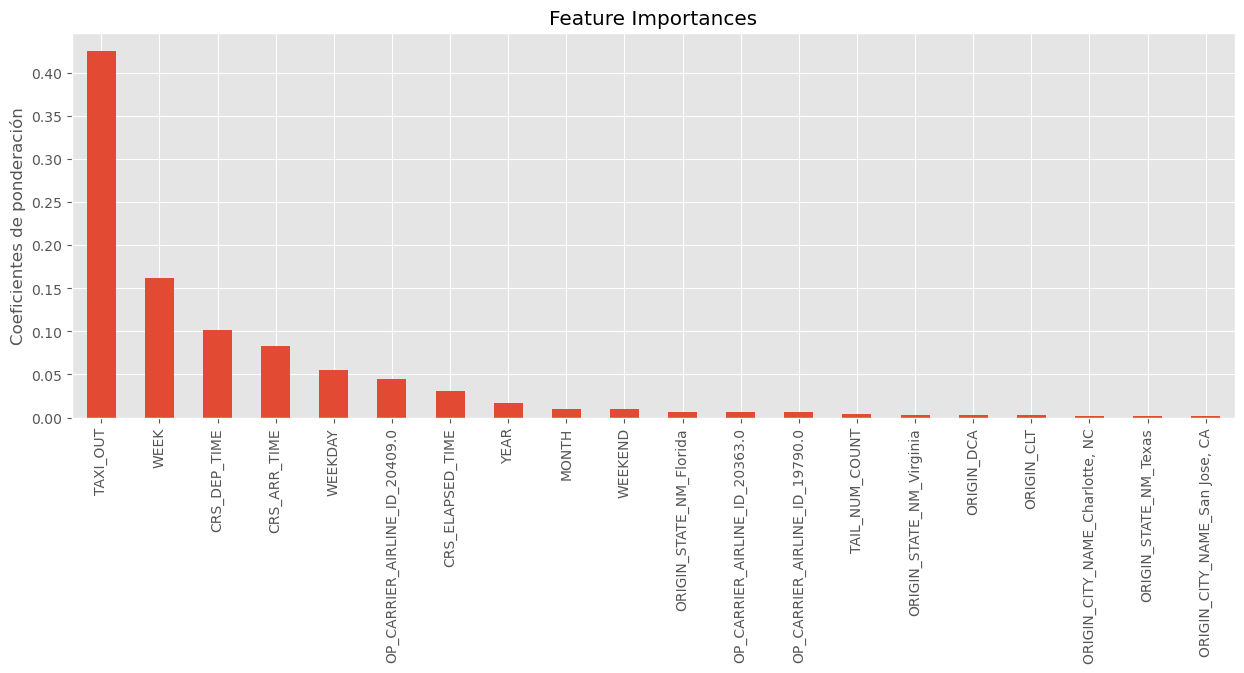

In [315]:
# Visualizamos los atributos importantes
plt.figure(figsize=(15,5))
gb_feature_importances.plot(kind = 'bar', ylabel = 'Coeficientes de ponderación')
plt.title('Feature Importances');

# **5. COMPARACIÓN DE MODELOS**

Comparamos los tres modelos vistos: 
- DecisionTree
- RandomForest
- GradientBoosting

In [316]:
# Parámetros que usamos
RANDOM_STATE = 42
n_estimators = 50
max_depth = 5

# Definición de los modelos
models = [ 
    ('DecisionTree', DecisionTreeClassifier(max_depth = max_depth, random_state = RANDOM_STATE)),
    ('RandomForest', RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, random_state = RANDOM_STATE)),
    ('GradientBoosting', GradientBoostingClassifier(n_estimators = n_estimators, max_depth = max_depth, random_state = RANDOM_STATE))
]

In [317]:
for model in models:
    print (model)

('DecisionTree', DecisionTreeClassifier(max_depth=5, random_state=42))
('RandomForest', RandomForestClassifier(max_depth=5, n_estimators=50, random_state=42))
('GradientBoosting', GradientBoostingClassifier(max_depth=5, n_estimators=50, random_state=42))


ROC AUC Score for DecisionTree: 0.6868521223090529
ROC AUC Score for RandomForest: 0.699962485150548
ROC AUC Score for GradientBoosting: 0.7428600692736489


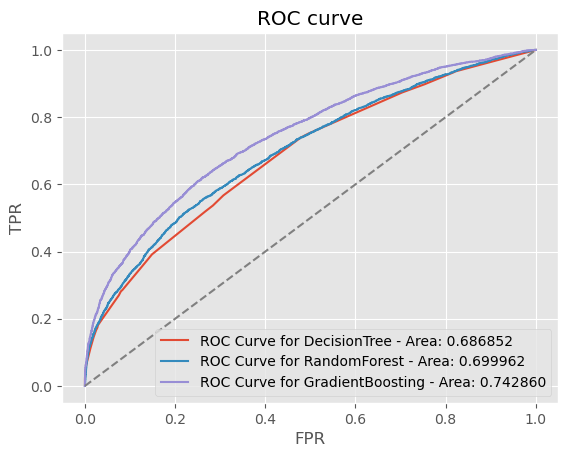

In [318]:
# Entrenamiento y validación con AUC/Roc Curve de los modelos
plt.clf() # Inicializamos la gráfica (borramos su contenido)
for model in models:
    model_name = model[0] # Nombre del modelo
    model_instance = model[1] # Instanciamos el modelo
    model_instance.fit(X_train, np.ravel(y_train)) # Entrenamos el modelo (le damos el y_train en 1D)
    predictions = model_instance.predict_proba(X_test)[:,1] # Obtenemos las predicciones de probabilidad
    auc_score = metrics.roc_auc_score(y_test, predictions) # Obtenemos el AUC
    print('ROC AUC Score for {}: {}'.format(model_name, auc_score))

    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions) # False Positive Rate, True Positive Rate (ejes de la ROC Curve) y threshold del modelo
    plt.plot(fpr, tpr, label = 'ROC Curve for {} - Area: {:2f}'.format(model_name, auc_score)) # Dibujamos la ROC Curve y le ponemos etiqueta

plt.plot([0, 1], [0, 1], color = 'gray', linestyle='--') # Estimador Random
plt.xlabel('FPR') # Etiqueta eje x
plt.ylabel('TPR') # Etiqueta eje y
plt.legend(loc="lower right") # Leyenda con ubicación abajo a la derecha
plt.title('ROC curve') # Título
plt.show()

Podemos apreciar que el modelo que peor rendimiento tiene es el DecisionTree y el que mejor rendimiento tiene es el GradientBoosting

# **5. Uso de hiperparámetros** --> GridSearch 

Cada vez que se hace un K-Fold, se va a obtener un resultado diferente --> Lo que se se hace es repetirlo "n" veces

In [324]:
# repite el kfolk 5 veces con 5 iteracciones cada kfolk
cv = RepeatedKFold(n_splits=10, n_repeats=15, random_state=None)

Vamos a ver como podemos utilizar sklearn para probar diferentes hiperparametros para un modelo dentro de un K-Folk Cross Validation. Lo vamos a hacer para un **DecisionTreeClassifier**

**Defino los hiperparámetros**

In [331]:
# diccionario con los parametros y estrategias de imputación para las variables categóricas
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": np.arange(2, 7), # [2, 3, 4, 5, 6]
    "min_samples_split": [3, 5, 10, 15, 20]
}

**1.- RandomizedSearchCV**

explora sólo algunas combinaciones de nuestro param_grid

In [ ]:
RandomizedSearchCV??

In [332]:
st = time.time()

# Lo invoco
rand_cv = RandomizedSearchCV(
    estimator = DecisionTreeClassifier(), # le paso el modelo
    param_distributions = param_grid, # le paso el diccionario de imputaciones e hiperparametros
    cv = cv, # le paso el número de veces que repite el kfolk cross validation
    return_train_score = True, # incluye los scores del train (para tener en cuenta el overfitting o underfitting)
    verbose = False,
    n_jobs = -1 # para usar todos los procesadores
)

# Lo entreno pasandole el train
rand_cv.fit(X_train, y_train)

score_rand = rand_cv.score(X_train, y_train)

et = time.time()

tt_rand = round((et - st)/60, 2)
print("Total time took: ", str(tt_rand), " minutes!")
print(f'El score del mejor estimador es: {round(score_rand,2)}')

Total time took:  8.3  minutes!
El score del mejor estimador es: 0.8


In [333]:
rand_cv.cv_results_

{'mean_fit_time': array([1.88542116, 1.4212946 , 1.81299684, 2.95811394, 2.69706007,
        2.98572977, 2.39465582, 2.61451053, 1.55545994, 1.55276469]),
 'std_fit_time': array([0.7189075 , 0.15437755, 0.17377677, 0.24360429, 0.29345608,
        0.31703923, 0.30433338, 0.26943386, 0.19518833, 0.19599377]),
 'mean_score_time': array([0.07339485, 0.04811997, 0.04679912, 0.04628102, 0.04775553,
        0.04662682, 0.05052947, 0.04737527, 0.05145327, 0.05186618]),
 'std_score_time': array([0.11496697, 0.01088803, 0.00914093, 0.01118377, 0.01182615,
        0.01062603, 0.01452289, 0.01048981, 0.01271328, 0.01349413]),
 'param_min_samples_split': masked_array(data=[15, 20, 10, 20, 20, 15, 10, 10, 3, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[2, 2, 3, 6, 5, 6, 4, 5, 2, 2],
              mask=[False, False, False, False, False, Fal

In [334]:
rand_cv.best_params_

{'min_samples_split': 15, 'max_depth': 6, 'criterion': 'entropy'}

**2.- GridSearchCV**

Explora todas las combinaciones posibles del diccionario de hiperparametros que le pasemos

In [335]:
st = time.time()

# Lo invoco
grid_cv = GridSearchCV(
    estimator = DecisionTreeClassifier(), # le paso el modelo
    param_grid = param_grid, # le paso el diccionario de imputaciones e hiperparametros
    cv = cv, # le paso el número de veces que repite el kfolk cross validation
    return_train_score = True, # incluye los scores del train (para tener en cuenta el overfitting o underfitting)
    verbose = False,
    n_jobs = -1 # para usar todos los procesadores
)

# Lo entreno pasándole el train
grid_cv.fit(X_train, y_train)

# Obtengo el score del mejor estimador
score_grid = grid_cv.score(X_train, y_train)

et = time.time()
tt_grid = round((et - st)/60, 2)
print("Total time took: ", str(tt_grid), " minutes!")
print(f'El score del mejor estimador es: {round(score_rand,2)}')

Total time took:  43.12  minutes!
El score del mejor estimador es: 0.8


In [336]:
grid_cv.best_params_

{'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 15}

**3.- Comparación de resultados**

In [337]:
pd.concat(
    [
        pd.DataFrame(
            data = list(rand_cv.best_params_.values()) + [round(score_rand, 3)], 
            index = list(rand_cv.best_params_.keys()) + ["Score"],
            columns = ["RandomizedSearchCV"]
        ),
        
        pd.DataFrame(
            data = list(grid_cv.best_params_.values()) + [round(score_grid, 3)], 
            index = list(grid_cv.best_params_.keys()) + ["Score"],
            columns = ["GridSearchCV"]
        ),
    ],
    axis = 1
)

,RandomizedSearchCV,GridSearchCV
min_samples_split,15,15
max_depth,6,6
criterion,entropy,gini
Score,0.80,0.80


In [338]:
# Comparamos los tiempos de ejecución entre ambos
print(f'El Gridserach es {round((tt_grid/tt_rand), 2)} más lento que el RandomizedSearchCV')

El Gridserach es 5.2 más lento que el RandomizedSearchCV


**4.- Se elije el mejor estimador**

En función del score que ha sacado

In [339]:
final_pipe = rand_cv if score_rand >= score_grid else grid_cv

In [340]:
final_pipe.best_estimator_

DecisionTreeClassifier(max_depth=6, min_samples_split=15)